# Sliding time window laminar model comparison with two simultaneous sources

This tutorial demonstrates how to perform laminar inference of beta bursts in a sliding time window using model comparison based on free energy as a metric of model fit, described in [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479). Two temporal Gaussian functions are simulated simultaneously in deep and superficial layers at a particular cortical location. Source reconstruction is performed on the whole time window using the Empirical Bayesian Beamformer on the simulated sensor data using a forward model based on the multilayer mesh as a localizer. This is used to select priors on each layer mesh for a sliding time window model comparison using free energy.

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt
import k3d

from lameg.invert import coregister, invert_ebb, load_source_time_series
from lameg.laminar import sliding_window_model_comparison
from lameg.simulate import run_dipole_simulation
from lameg.surf import interpolate_data
from lameg.util import get_surface_names, get_fiducial_coords
from lameg.viz import show_surface, color_map, rgbtoint
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
nas, lpa, rpa = get_fiducial_coords(subj_id, '../test_data/participants.tsv')

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id, 
    'meg',
    ses_id, 
    'spm/pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

For source reconstructions, we need an MRI and a surface mesh. The simulations will be based on a forward model using the multilayer mesh, and the model comparison will use each layer mesh

In [2]:
# Native space MRI to use for coregistration
mri_fname = os.path.join('../test_data', subj_id, 'mri', 's2023-02-28_13-33-133958-00001-00224-1.nii' )

# Mesh to use for forward model in the simulations
multilayer_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'multilayer.11.ds.link_vector.fixed.gii')

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Get name of each mesh that makes up the layers of the multilayer mesh - these will be used for the source 
# reconstruction
layer_fnames = get_surface_names(
    n_layers, 
    os.path.join('../test_data', subj_id, 'surf'), 
    'link_vector.fixed'
)

# Inflated meshes for plotting
ds_inflated = nib.load(os.path.join('../test_data', subj_id, 'surf', 'inflated.ds.gii'))
orig_inflated = nib.load(os.path.join('../test_data', subj_id, 'surf', 'inflated.gii'))

We're going to copy the data file to a temporary directory and direct all output there.

In [3]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/sliding_window_beta_burst'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [4]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
24-Jul-2024 13:52:11 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 13:52:11 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           13:52:11 - 24/07/2024
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiome

## Simulating a beta burst
We're going to simulate a beta burst as two dipoles. One in the deep layer, a more narrow but stronger drive in the superficial layer (see [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479))

Text(0, 0.5, 'Amplitude (nAm)')

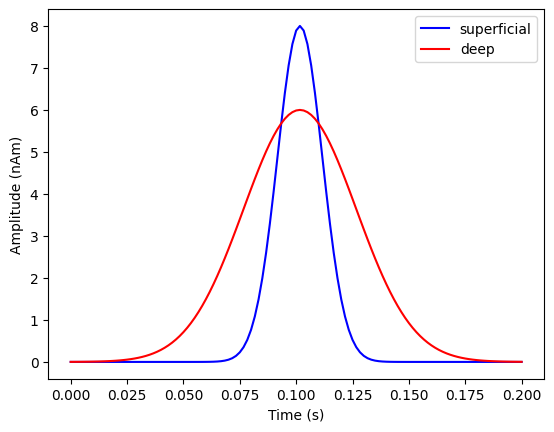

In [5]:
# Strength of each simulated source (nAm)
dipole_moment = [8, 6]
# Temporal width of the simulated superficial signal
superficial_width = .01 # 10ms
# Temporal width of the simulated deep signal
deep_width = .025 # 25ms

# Sampling rate (must match the data file)
s_rate = 600

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time = np.linspace(0,.2,121)
zero_time = time[int((len(time)-1)/2+1)]
superficial_signal = np.exp(-((time-zero_time)**2)/(2*superficial_width**2))
deep_signal = np.exp(-((time-zero_time)**2)/(2*deep_width**2))

plt.plot(time,superficial_signal*dipole_moment[0], 'b', label='superficial')
plt.plot(time,deep_signal*dipole_moment[1], 'r', label='deep')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at. The superficial signal will be simulated as a dipole at the corresponding vertex on the pial surface, and the deep signal on the white matter surface. The dipole orientations will be in opposite directions (with the superficial one pointing toward the deep one, and vice versa). This will yield a cumulative dipole moment with a beta burst-like shape

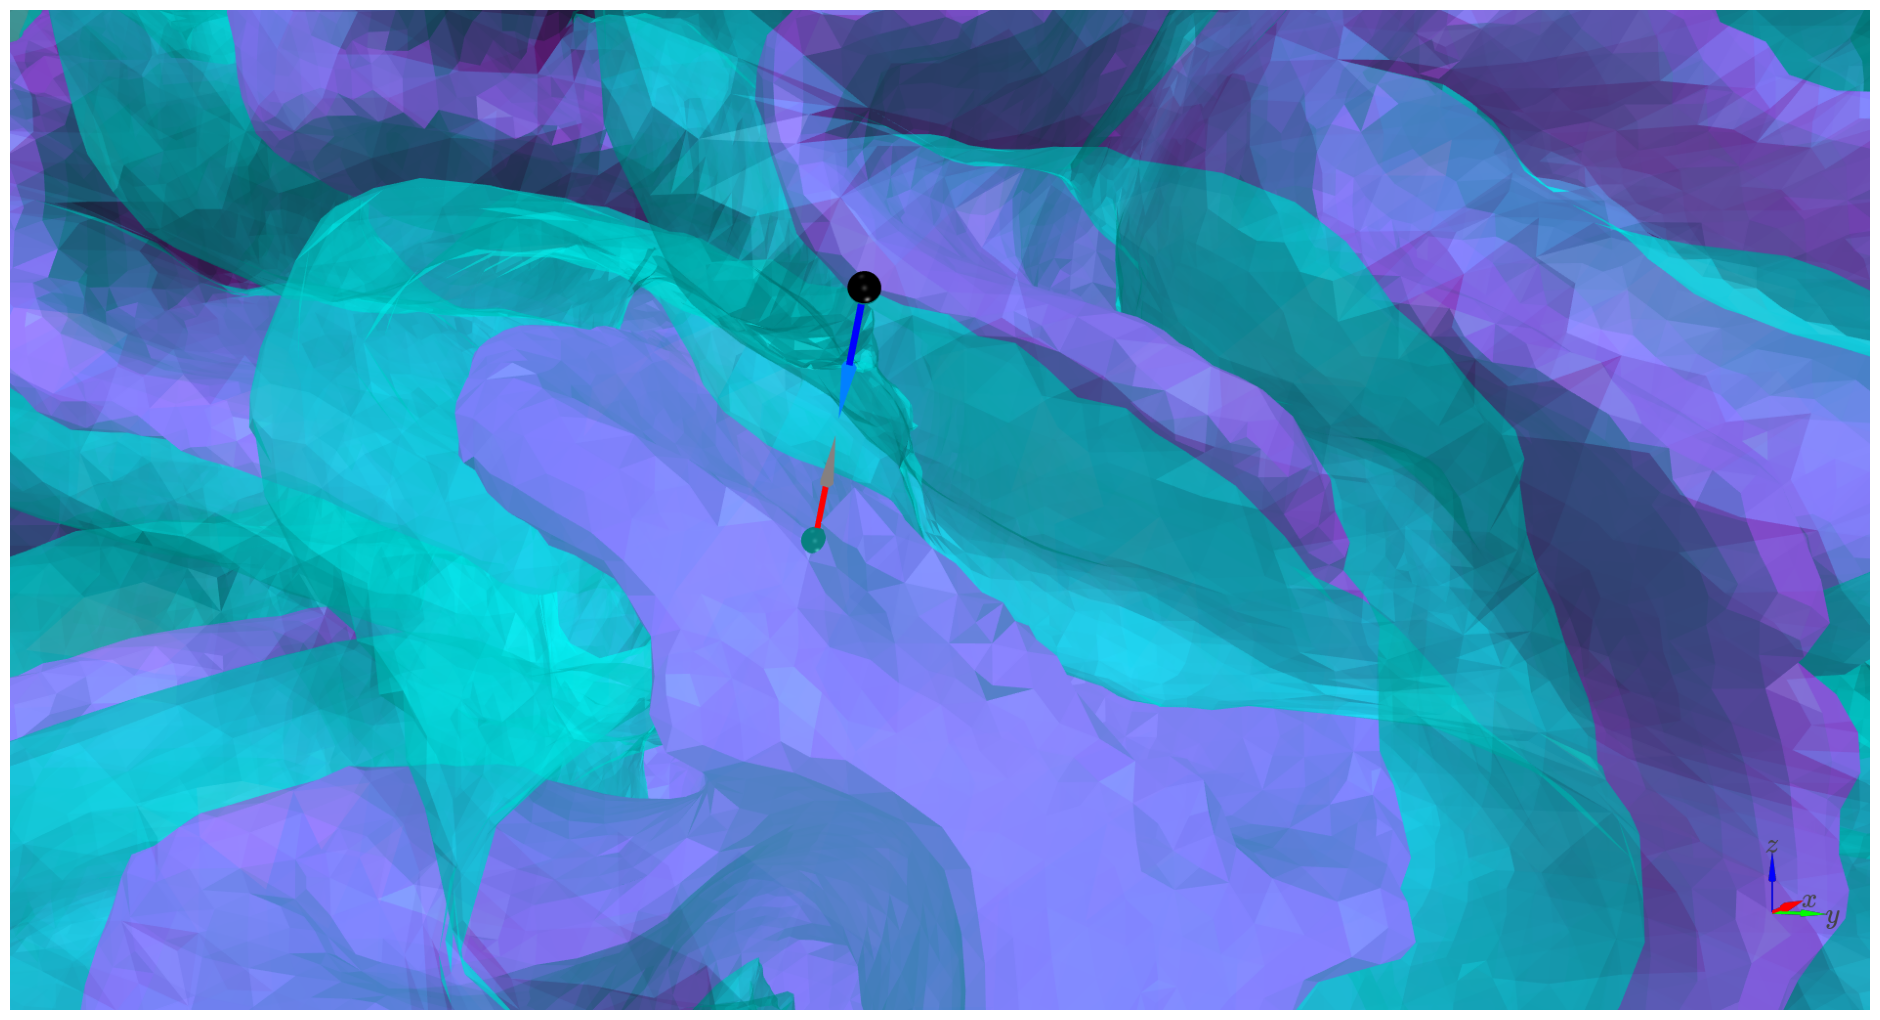

In [9]:
# Location to simulate activity at
sim_vertex = 24585
# Corresponding pial and white matter vertices
pial_vertex = sim_vertex
white_vertex = (n_layers-1)*int(verts_per_surf)+sim_vertex
pial_coord = mesh.darrays[0].data[pial_vertex,:]
white_coord = mesh.darrays[0].data[white_vertex,:]

# Orientation of the simulated superficial dipole
pial_ori=mesh.darrays[2].data[pial_vertex,:]
# Orientation of the simulated deep dipole
white_ori=-1*mesh.darrays[2].data[white_vertex,:]

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))

pial_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.gii')
pial_mesh = nib.load(pial_mesh_fname)
white_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'white.gii')
white_mesh = nib.load(white_mesh_fname)

cam_view = [85.5, -10.5, 32,
            0.5, 17, 43,
            0, 0, 1]

plot = k3d.plot(
    grid_visible=False, menu_visibility=False, camera_auto_fit=False
)

pial_vertices, pial_faces = pial_mesh.agg_data()
pial_k3d_mesh = k3d.mesh(pial_vertices, pial_faces, side="double", color=rgbtoint(col_r[0,:3]*255), opacity=0.5)
plot += pial_k3d_mesh

white_vertices, white_faces = white_mesh.agg_data()
white_k3d_mesh = k3d.mesh(white_vertices, white_faces, side="double", color=rgbtoint(col_r[-1,:3]*255), opacity=1)
plot += white_k3d_mesh

pts = k3d.points(
    np.vstack([pial_coord, white_coord]),
    point_size=1,
    color=rgbtoint([0,0,0])
)
plot += pts

dipole_vectors = k3d.vectors(
    np.vstack([pial_coord, white_coord]),
    vectors=np.vstack([pial_ori, white_ori])*2.3,
    head_size=5,
    line_width=0.1,
    colors=[rgbtoint([0,0,255]), rgbtoint([0,0,255]),
            rgbtoint([255,0,0]), rgbtoint([255,0,0])]
)
plot += dipole_vectors

plot.camera=cam_view

plot.display()

We'll simulate a 5mm patch of activity with -10 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [10]:
# Simulate a beta burst as two sources: one deep and one superficial
prefix=f'sim_{sim_vertex}_burst_'

# Size of simulated sources (mm)
sim_dipfwhm=[5, 5] # mm
# SNR of simulated data (dB)
SNR=-10

# Generate simulated data
burst_sim_fname=run_dipole_simulation(
    base_fname, 
    prefix, 
    [pial_vertex, white_vertex],
    np.vstack([superficial_signal, deep_signal]),
    np.vstack([pial_ori, white_ori]),
    dipole_moment, 
    sim_dipfwhm, 
    SNR,
    spm_instance=spm
)

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -10B

 Finish


## Localizer inversion
Now we'll run a source reconstruction using the multilayer mesh, extract the signal in the pial layer, and select a prior based on the peak.

In [11]:
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    burst_sim_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

layer_vertices = np.arange(verts_per_surf)
layer_ts, time, _ = load_source_time_series(
    burst_sim_fname, 
    mu_matrix=MU, 
    vertices=layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
prior = np.argmax(m_layer_max)

sim_coord = ds_inflated.darrays[0].data[sim_vertex,:]
prior_coord = ds_inflated.darrays[0].data[prior,:]

print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')
print('Simulated coordinate')
print(sim_coord)
print('Prior coordinate')
print(prior_coord)


Smoothing ../test_data/sub-104/surf/multilayer.11.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/sliding_window_beta_burst/sim_24585_burst_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been m

We can see that the prior is the same as the location we simulated at

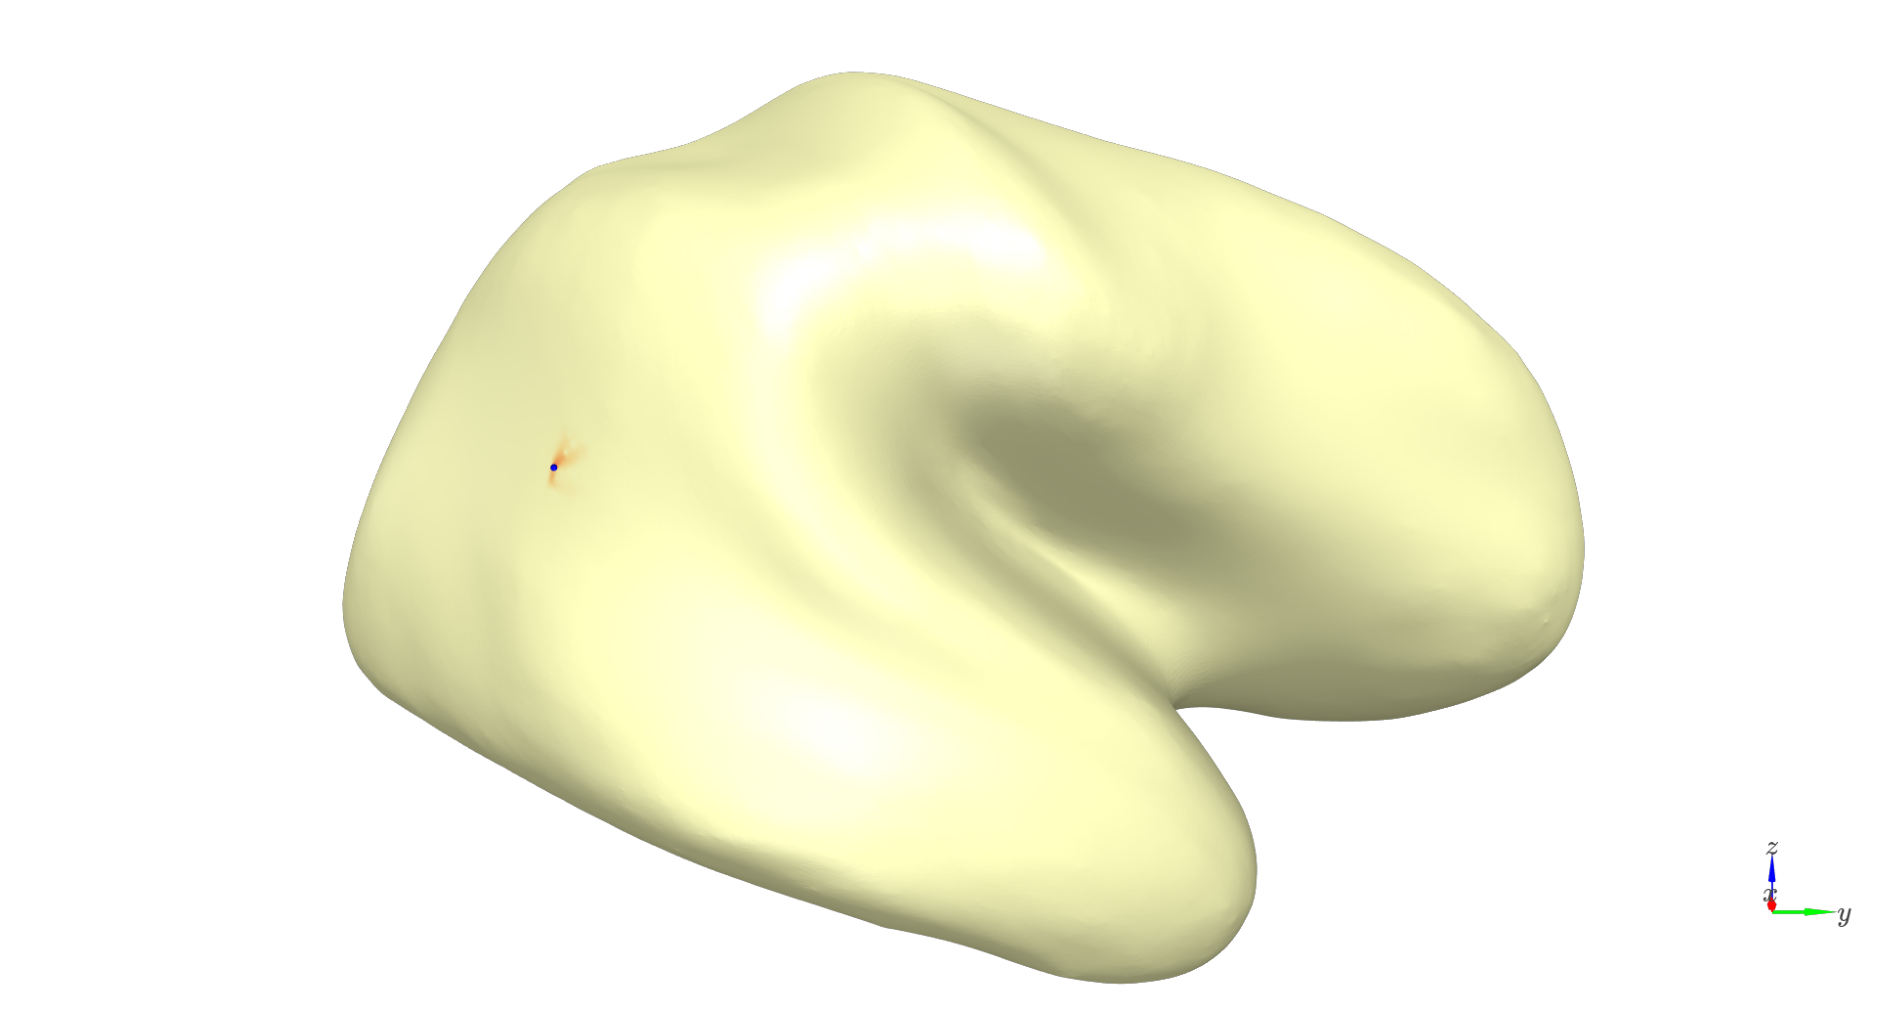

In [14]:
# Interpolate for display on the original inflated surface
interpolated_data = interpolate_data(orig_inflated, ds_inflated, m_layer_max)
          
# Plot colors and camera view
max_abs = np.max(np.abs(m_layer_max))
c_range = [-max_abs, max_abs]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]

# Plot peak
colors,_ = color_map(
    interpolated_data, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]    
)

plot = show_surface(
    orig_inflated, 
    vertex_colors=colors, 
    info=True, 
    camera_view=cam_view, 
    coords=prior_coord, 
    coord_size=2, 
    coord_color=[0,0,255]
)

## Sliding time window model comparison (pial - white matter)
Now we can run sliding time window model comparison between source models based on the pial and white matter surfaces using free energy. Specifically, we'll look at the difference in free energy between the two models (pial - white matter), in sliding and overlapping windows of 16ms. Because this window is so short, we'll use 2 temporal modes. If you increase the size of the window, you may have to increase the number of temporal modes. The free energy difference (pial - white matter) should be negative (more model evidence for the white matter surface model) at the start and end of the burst, and positive (more model evidence for the pial surface model) at the peak of the burst.

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
23-Jul-2024 08:04:30 - Running job #1
------------------------------------------------------------------------
23-Jul-2024 08:04:30 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           08:04:45 - 23/07/2024
pial.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating layout for ctf275 sy

  ReML Iteration              : 7                            ...4.000049e+01
  ReML Iteration              : 8                            ...3.249752e+01
  ReML Iteration              : 9                            ...2.509464e+01
  ReML Iteration              : 10                            ...1.824981e+01
  ReML Iteration              : 11                            ...1.244299e+01
  ReML Iteration              : 12                            ...7.962798e+00
  ReML Iteration              : 13                            ...4.813080e+00
  ReML Iteration              : 14                            ...2.775432e+00
  ReML Iteration              : 15                            ...1.545012e+00
  ReML Iteration              : 16                            ...8.406943e-01
  ReML Iteration              : 17                            ...4.528942e-01
  ReML Iteration              : 18                            ...2.448716e-01
  ReML Iteration              : 19                            ...1.

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220688e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192853e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167761e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106912e+02 [+4.50]
  ReML Iteration 5                      :        ...9.657948e+01 [+4.62]
  ReML Iteration 6                      :        ...7.521235e-03 [+4.75]
Percent variance explained -3.18 (-3.11)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.848803e+02 [+4.12]
  ReML Iteration

  ReML Iteration              : 7                            ...3.896894e+01
  ReML Iteration              : 8                            ...3.126312e+01
  ReML Iteration              : 9                            ...2.375093e+01
  ReML Iteration              : 10                            ...1.692883e+01
  ReML Iteration              : 11                            ...1.127123e+01
  ReML Iteration              : 12                            ...7.018584e+00
  ReML Iteration              : 13                            ...4.112554e+00
  ReML Iteration              : 14                            ...2.288488e+00
  ReML Iteration              : 15                            ...1.221918e+00
  ReML Iteration              : 16                            ...6.323239e-01
  ReML Iteration              : 17                            ...3.199914e-01
  ReML Iteration              : 18                            ...1.595822e-01
  ReML Iteration              : 19                            ...7.

  ReML Iteration 1                      :        ...5.819999e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188860e+02 [+4.25]
  ReML Iteration 3                      :        ...1.132917e+02 [+4.38]
  ReML Iteration 4                      :        ...1.044206e+02 [+4.50]
  ReML Iteration 5                      :        ...8.462057e+01 [+4.62]
  ReML Iteration 6                      :        ...5.306447e-05 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.49   -3.43

  ReML Iteration              : 1                            ...1.086692e+02
  ReML Iteration              : 2                            ...8.520189e+01
  ReML Iteration              : 3                            ...7.202603e+01
  ReML Iteration              : 4                            ...6.272136e+01
  ReML Iteration              : 5                            ...5.498647e+01
  ReML Iteration              : 6                            ...4.774999e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.276773e-01
  ReML Iteration              : 20                            ...7.135728e-02
  ReML Iteration              : 21                            ...4.173257e-02
  ReML Iteration              : 22                            ...2.601437e-02
  ReML Iteration              : 23                            ...1.764061e-02
  ReML Iteration              : 24                            ...1.332301e-02
  ReML Iteration              : 25                            ...1.154450e-02
  ReML Iteration              : 26                            ...1.197372e-02
  ReML Iteration              : 27                            ...1.592630e-02
  ReML Iteration              : 28                            ...3.078972e-02
  ReML Iteration              : 29                            ...1.055237e-01
  ReML Iteration              : 30                            ...3.545223e-01
  ReML Iteration              : 31                            ..

  ReML Iteration 1                      :        ...5.846572e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186720e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126599e+02 [+4.38]
  ReML Iteration 4                      :        ...1.028940e+02 [+4.50]
  ReML Iteration 5                      :        ...8.150409e+01 [+4.62]
  ReML Iteration 6                      :        ...4.239654e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.49   -3.40

  ReML Iteration              : 1                            ...1.085867e+02
  ReML Iteration              : 2                            ...8.503419e+01
  ReML Iteration              : 3                            ...7.173636e+01
  ReML Iteration              : 4                            ...6.225768e+01
  ReML Iteration              : 5                            ...5.429088e+01
  ReML Iteration              : 6                            ...4.677257e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...2.842819e-02
  ReML Iteration              : 20                            ...1.305980e-02
  ReML Iteration              : 21                            ...6.033570e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.224931e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189289e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158322e+02 [+4.38]
  ReML Iteration 4                      :        ...1.083045e+02 [+4.50]
  ReML Iteration 5                      :        ...9.120614e+01 [+4.62]
  ReML Iteration 6                      :        ...8.285650e-02 [+4.75]
  ReML Iteration 7                      :        ...5.380689e-08 [+4.88]
Percent variance explained -55.69 (-46.51)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.56 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 1                            ...1.082705e+02
  ReML Iteration              : 2                            ...8.374161e+01
  ReML Iteration              : 3                            ...6.952354e+01
  ReML Iteration              : 4                            ...5.877823e+01
  ReML Iteration              : 5                            ...4.921618e+01
  ReML Iteration              : 6                            ...3.993447e+01
  ReML Iteration              : 7                            ...3.079137e+01
  ReML Iteration              : 8                            ...2.217552e+01
  ReML Iteration              : 9                            ...1.472716e+01
  ReML Iteration              : 10                            ...8.964736e+00
  ReML Iteration              : 11                            ...5.011655e+00
  ReML Iteration              : 12                            ...2.597245e+00
  ReML Iteration              : 13                            ...1.265997

Percent variance explained -296.28 (-247.60)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.337298e+02 [+4.12]
  ReML Iteration 2                      :        ...1.149577e+02 [+4.25]
  ReML Iteration 3                      :        ...1.019008e+02 [+4.38]
  ReML Iteration 4                      :        ...7.911266e+01 [+4.50]
  ReML Iteration 5                      :        ...4.198819e+01 [+4.62]
  ReML Iteration 6                      :        ...1.889053e+00 [+4.75]
  ReML Iteration 7                      :        ...3.615767e-05 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.49   -2.8

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.353437e+02 [+4.12]
  ReML Iteration 2                      :        ...1.143530e+02 [+4.25]
  ReML Iteration 3                      :        ...1.041647e+02 [+4.38]
  ReML Iteration 4                      :        ...8.159146e+01 [+4.50]
  ReML Iteration 5                      :        ...4.381976e+01 [+4.62]
  ReML Iteration 6                      :        ...8.763774e+00 [+4.75]
  ReML Iteration 7                      :        ...5.804238e-04 [+4.88]
Percent variance explained -1462.12 (-1221.68)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.38 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Ite

Percent variance explained 74.09 (61.94)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.59 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.177107e+03 [+4.12]
  ReML Iteration 2                      :        ...9.381423e+01 [+4.25]
  ReML Iteration 3                      :        ...4.211157e+01 [+4.38]
  ReML Iteration 4                      :        ...8.754945e+00 [+4.50]
  ReML Iteration 5                      :        ...2.549586e-01 [+4.62]
  ReML Iteration 6                      :        ...1.775399e-04 [+4.75]
log evidence & hyperparameters:
    0.00 2027.91
    9.46   -1.08

  ReML Iteration              : 1                            ...2.418850e+

  ReML Iteration              : 7                            ...8.331149e-02
  ReML Iteration              : 8                            ...2.473112e-02
  ReML Iteration              : 9                            ...7.782160e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.170821e+03 [+4.12]
  ReML Iteration 2                      :        ...8.448199e+01 [+4.25]
  ReML Iteration 3                      :        ...3.228684e+01 [+4.38]
  ReML Iteration 4                      :        ...4.376051e+00 [+4.50]
  ReML Iteration 5                      :        ...5.098518e-02 [+4.62]
  ReML Iteration 6                      :        ...4.096194e-06 [+4.75]
Percent variance explained 91.33 (77.04)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  Re

Percent variance explained 95.11 (86.79)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.45 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.050154e+03 [+4.12]
  ReML Iteration 2                      :        ...1.150730e+03 [+4.25]
  ReML Iteration 3                      :        ...1.909319e+01 [+4.38]
  ReML Iteration 4                      :        ...4.826025e-03 [+4.50]
log evidence & hyperparameters:
    0.00 17615.89
    9.37    1.23

  ReML Iteration              : 1                            ...5.450129e+03
  ReML Iteration              : 2                            ...5.685914e+02
  ReML Iteration              : 3                            ...6

Percent variance explained 97.19 (87.35)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.68 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.433082e+04 [+4.12]
  ReML Iteration 2                      :        ...4.399866e+03 [+4.25]
  ReML Iteration 3                      :        ...3.605691e+02 [+4.38]
  ReML Iteration 4                      :        ...2.343761e+00 [+4.50]
  ReML Iteration 5                      :        ...9.951420e-05 [+4.62]
log evidence & hyperparameters:
    0.00 30659.43
    9.22    2.01

  ReML Iteration              : 1                            ...1.129871e+04
  ReML Iteration              : 2                            ...2.516

  ReML Iteration              : 13                            ...4.296204e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.628034e+04 [+4.12]
  ReML Iteration 2                      :        ...5.322641e+03 [+4.25]
  ReML Iteration 3                      :        ...3.797315e+02 [+4.38]
  ReML Iteration 4                      :        ...1.318139e+00 [+4.50]
  ReML Iteration 5                      :        ...1.393763e-05 [+4.62]
Percent variance explained 97.76 (90.72)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.761297e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.567452e+04
  ReML Iteration              : 2                            ...5.169824e+03
  ReML Iteration              : 3                            ...1.314433e+03
  ReML Iteration              : 4                            ...2.927657e+02
  ReML Iteration              : 5                            ...6.602098e+01
  ReML Iteration              : 6                            ...1.609746e+01
  ReML Iteration              : 7                            ...4.293532e+00
  ReML Iteration              : 8                            ...1.243287e+00
  ReML Iteration              : 9                            ...3.863777e-01
  ReML Iteration              : 10                            ...1.274774e-01
  ReML Iteration              : 11                            ...4.424796e-02
  ReML Iteration              : 12                            ...1.603968e-02
  ReML Iteration              : 13                            ...6.036217

Percent variance explained 96.23 (92.16)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.488609e+04 [+4.12]
  ReML Iteration 2                      :        ...4.815051e+03 [+4.25]
  ReML Iteration 3                      :        ...4.411373e+02 [+4.38]
  ReML Iteration 4                      :        ...3.626354e+00 [+4.50]
  ReML Iteration 5                      :        ...2.484274e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31910.34
    9.26    2.13

  ReML Iteration              : 1                            ...1.183388e+04
  ReML Iteration              : 2                            ...2.780

Percent variance explained 91.84 (79.14)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.567868e+03 [+4.12]
  ReML Iteration 2                      :        ...1.000286e+03 [+4.25]
  ReML Iteration 3                      :        ...1.419316e+01 [+4.38]
  ReML Iteration 4                      :        ...2.702607e-03 [+4.50]
log evidence & hyperparameters:
    0.00 16650.83
    9.44    1.22

  ReML Iteration              : 1                            ...5.022909e+03
  ReML Iteration              : 2                            ...4.864828e+02
  ReML Iteration              : 3                            ...5

  ReML Iteration 1                      :        ...1.429951e+04 [+4.12]
  ReML Iteration 2                      :        ...4.377126e+03 [+4.25]
  ReML Iteration 3                      :        ...3.564200e+02 [+4.38]
  ReML Iteration 4                      :        ...2.285918e+00 [+4.50]
  ReML Iteration 5                      :        ...9.444711e-05 [+4.62]
log evidence & hyperparameters:
    0.00 30589.60
    9.28    2.06

  ReML Iteration              : 1                            ...1.126861e+04
  ReML Iteration              : 2                            ...2.502265e+03
  ReML Iteration              : 3                            ...4.391978e+02
  ReML Iteration              : 4                            ...7.810927e+01
  ReML Iteration              : 5                            ...1.580150e+01
  ReML Iteration              : 6                            ...3.665685e+00
  ReML Iteration              : 7                            ...9.550744e-01
  ReML Iteration            

Percent variance explained 95.37 (91.68)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.71 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.576199e+04 [+4.12]
  ReML Iteration 2                      :        ...5.516548e+03 [+4.25]
  ReML Iteration 3                      :        ...5.985122e+02 [+4.38]
  ReML Iteration 4                      :        ...7.045349e+00 [+4.50]
  ReML Iteration 5                      :        ...1.007874e-03 [+4.62]
log evidence & hyperparameters:
    0.00 33935.74
    9.23    2.23

  ReML Iteration              : 1                            ...1.268241e+04
  ReML Iteration              : 2                            ...3.232

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.040276e+04 [+4.12]
  ReML Iteration 2                      :        ...1.792149e+03 [+4.25]
  ReML Iteration 3                      :        ...3.511732e+01 [+4.38]
  ReML Iteration 4                      :        ...1.570329e-02 [+4.50]
  ReML Iteration 5                      :        ...5.652834e-09 [+4.62]
Percent variance explained 93.25 (83.34)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.15 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.048524e+04 [+4.12]
  ReML Iteration 2                      :        ...2.113510e+03 [+4.25]
  ReML Iteration

Percent variance explained 92.75 (81.72)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.74 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.033851e+04 [+4.12]
  ReML Iteration 2                      :        ...2.045462e+03 [+4.25]
  ReML Iteration 3                      :        ...6.632588e+01 [+4.38]
  ReML Iteration 4                      :        ...6.414740e-02 [+4.50]
  ReML Iteration 5                      :        ...5.858623e-08 [+4.62]
log evidence & hyperparameters:
    0.00 22213.87
    9.39    1.60

  ReML Iteration              : 1                            ...7.528342e+03
  ReML Iteration              : 2                            ...1.077

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.499736e+04 [+4.12]
  ReML Iteration 2                      :        ...4.341984e+03 [+4.25]
  ReML Iteration 3                      :        ...2.394178e+02 [+4.38]
  ReML Iteration 4                      :        ...5.066647e-01 [+4.50]
  ReML Iteration 5                      :        ...2.036912e-06 [+4.62]
Percent variance explained 96.11 (92.03)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.78 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.863550e+04 [+4.12]
  ReML Iteration 2                      :        ...8.238258e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 1                            ...1.587802e+04
  ReML Iteration              : 2                            ...5.322251e+03
  ReML Iteration              : 3                            ...1.376687e+03
  ReML Iteration              : 4                            ...3.104098e+02
  ReML Iteration              : 5                            ...7.046429e+01
  ReML Iteration              : 6                            ...1.723616e+01
  ReML Iteration              : 7                            ...4.604402e+00
  ReML Iteration              : 8                            ...1.334342e+00
  ReML Iteration              : 9                            ...4.148426e-01
  ReML Iteration              : 10                            ...1.368986e-01
  ReML Iteration              : 11                            ...4.752387e-02
  ReML Iteration              : 12                            ...1.722839e-02
  ReML Iteration              : 13                            ...6.483827

Percent variance explained 97.79 (90.11)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.562925e+04 [+4.12]
  ReML Iteration 2                      :        ...5.406515e+03 [+4.25]
  ReML Iteration 3                      :        ...5.720257e+02 [+4.38]
  ReML Iteration 4                      :        ...6.382351e+00 [+4.50]
  ReML Iteration 5                      :        ...8.176921e-04 [+4.62]
log evidence & hyperparameters:
    0.00 33624.38
    9.17    2.16

  ReML Iteration              : 1                            ...1.255348e+04
  ReML Iteration              : 2                            ...3.161

Percent variance explained 97.25 (86.73)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.542206e+03 [+4.12]
  ReML Iteration 2                      :        ...1.699125e+03 [+4.25]
  ReML Iteration 3                      :        ...4.425238e+01 [+4.38]
  ReML Iteration 4                      :        ...2.749584e-02 [+4.50]
  ReML Iteration 5                      :        ...1.030951e-08 [+4.62]
log evidence & hyperparameters:
    0.00 20605.00
    9.34    1.43

  ReML Iteration              : 1                            ...6.796630e+03
  ReML Iteration              : 2                            ...8.769

  ReML Iteration              : 1                            ...2.098720e+03
  ReML Iteration              : 2                            ...1.143422e+02
  ReML Iteration              : 3                            ...1.313188e+01
  ReML Iteration              : 4                            ...2.284380e+00
  ReML Iteration              : 5                            ...4.748731e-01
  ReML Iteration              : 6                            ...1.121917e-01
  ReML Iteration              : 7                            ...2.950242e-02
  ReML Iteration              : 8                            ...8.481562e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.417127e+03 [+4.12]
  ReML Iteration 2                      :        ...1.165964e+02 [+4.25]
  ReML Iteration 3                      :        ...1.702730e+01 [+4.38]
  ReML Iteration 4                      :        ...9.873696e-01 [+4.50]
  ReML Iteration 5                      

  ReML Iteration              : 1                            ...3.482571e+02
  ReML Iteration              : 2                            ...5.690597e+01
  ReML Iteration              : 3                            ...2.865349e+01
  ReML Iteration              : 4                            ...1.289276e+01
  ReML Iteration              : 5                            ...4.934269e+00
  ReML Iteration              : 6                            ...1.681114e+00
  ReML Iteration              : 7                            ...5.432191e-01
  ReML Iteration              : 8                            ...1.747729e-01
  ReML Iteration              : 9                            ...5.751335e-02
  ReML Iteration              : 10                            ...1.957753e-02
  ReML Iteration              : 11                            ...6.913193e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...4.321786e+02 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 13                            ...1.702256e-02
  ReML Iteration              : 14                            ...6.734797e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.687471e+02 [+4.12]
  ReML Iteration 2                      :        ...1.090717e+02 [+4.25]
  ReML Iteration 3                      :        ...9.168002e+01 [+4.38]
  ReML Iteration 4                      :        ...5.830966e+01 [+4.50]
  ReML Iteration 5                      :        ...1.882529e+01 [+4.62]
  ReML Iteration 6                      :        ...1.379595e+00 [+4.75]
  ReML Iteration 7                      :        ...3.942766e+01 [+3.75]
  ReML Iteration 8                      :        ...1.145800e-02 [+3.88]
  ReML Iteration 9                      :        ...9.615252e-10 [+4.00]
Percent variance explained -4649.35 (-3883.49)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting f

  ReML Iteration              : 13                            ...2.063055e-01
  ReML Iteration              : 14                            ...8.580835e-02
  ReML Iteration              : 15                            ...3.582471e-02
  ReML Iteration              : 16                            ...1.510302e-02
  ReML Iteration              : 17                            ...6.449764e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.295205e+02 [+4.12]
  ReML Iteration 2                      :        ...1.158702e+02 [+4.25]
  ReML Iteration 3                      :        ...1.079420e+02 [+4.38]
  ReML Iteration 4                      :        ...8.968917e+01 [+4.50]
  ReML Iteration 5                      :        ...5.585750e+01 [+4.62]
  ReML Iteration 6                      :        ...4.223256e+00 [+4.75]
  ReML Iteration 7                      :        ...1.357873e-04 [+4.88]
Percent variance explained -882.77 (-738.46)
Nu

  ReML Iteration              : 7                            ...3.069258e+01
  ReML Iteration              : 8                            ...2.207338e+01
  ReML Iteration              : 9                            ...1.463465e+01
  ReML Iteration              : 10                            ...8.891679e+00
  ReML Iteration              : 11                            ...4.961130e+00
  ReML Iteration              : 12                            ...2.566248e+00
  ReML Iteration              : 13                            ...1.248802e+00
  ReML Iteration              : 14                            ...5.813387e-01
  ReML Iteration              : 15                            ...2.630576e-01
  ReML Iteration              : 16                            ...1.172645e-01
  ReML Iteration              : 17                            ...5.201589e-02
  ReML Iteration              : 18                            ...2.311820e-02
  ReML Iteration              : 19                            ...1.

  ReML Iteration 1                      :        ...5.908636e+02 [+4.12]
  ReML Iteration 2                      :        ...1.181777e+02 [+4.25]
  ReML Iteration 3                      :        ...1.112054e+02 [+4.38]
  ReML Iteration 4                      :        ...9.943555e+01 [+4.50]
  ReML Iteration 5                      :        ...7.471506e+01 [+4.62]
  ReML Iteration 6                      :        ...5.455900e-02 [+4.75]
  ReML Iteration 7                      :        ...3.081951e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -3.33

  ReML Iteration              : 1                            ...1.084318e+02
  ReML Iteration              : 2                            ...8.464583e+01
  ReML Iteration              : 3                            ...7.106780e+01
  ReML Iteration              : 4                            ...6.119480e+01
  ReML Iteration              : 5                            ...5.271359e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...1.036714e-01
  ReML Iteration              : 20                            ...5.402798e-02
  ReML Iteration              : 21                            ...2.849923e-02
  ReML Iteration              : 22                            ...1.527305e-02
  ReML Iteration              : 23                            ...8.332520e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219912e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193589e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169717e+02 [+4.38]
  ReML Iteration 4                      :        ...1.111904e+02 [+4.50]
  ReML Iteration 5                      :        ...2.044913e-03 [+4.62]
Percent variance explained -372.05 (-311.05)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source pri

  ReML Iteration 1                      :        ...5.824650e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188484e+02 [+4.25]
  ReML Iteration 3                      :        ...1.131807e+02 [+4.38]
  ReML Iteration 4                      :        ...1.041514e+02 [+4.50]
  ReML Iteration 5                      :        ...8.406564e+01 [+4.62]
  ReML Iteration 6                      :        ...2.912857e-05 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.43

  ReML Iteration              : 1                            ...1.086541e+02
  ReML Iteration              : 2                            ...8.517248e+01
  ReML Iteration              : 3                            ...7.197519e+01
  ReML Iteration              : 4                            ...6.263984e+01
  ReML Iteration              : 5                            ...5.486384e+01
  ReML Iteration              : 6                            ...4.757697e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.124062e-01
  ReML Iteration              : 20                            ...5.997409e-02
  ReML Iteration              : 21                            ...3.267441e-02
  ReML Iteration              : 22                            ...1.828993e-02
  ReML Iteration              : 23                            ...1.056387e-02
  ReML Iteration              : 24                            ...6.310033e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219757e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193740e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170118e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112929e+02 [+4.50]
  ReML Iteration 5                      :        ...1.349674e-03 [+4.62]
Percent variance explained -71.35 (-63.84)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal mod

  ReML Iteration              : 7                            ...3.920894e+01
  ReML Iteration              : 8                            ...3.154857e+01
  ReML Iteration              : 9                            ...2.405920e+01
  ReML Iteration              : 10                            ...1.722892e+01
  ReML Iteration              : 11                            ...1.153429e+01
  ReML Iteration              : 12                            ...7.227591e+00
  ReML Iteration              : 13                            ...4.264981e+00
  ReML Iteration              : 14                            ...2.392161e+00
  ReML Iteration              : 15                            ...1.288746e+00
  ReML Iteration              : 16                            ...6.737371e-01
  ReML Iteration              : 17                            ...3.449550e-01
  ReML Iteration              : 18                            ...1.743561e-01
  ReML Iteration              : 19                            ...8.

  ReML Iteration 1                      :        ...5.845579e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186800e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126834e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029505e+02 [+4.50]
  ReML Iteration 5                      :        ...8.161815e+01 [+4.62]
  ReML Iteration 6                      :        ...3.895184e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.40

  ReML Iteration              : 1                            ...1.085896e+02
  ReML Iteration              : 2                            ...8.504044e+01
  ReML Iteration              : 3                            ...7.174714e+01
  ReML Iteration              : 4                            ...6.227491e+01
  ReML Iteration              : 5                            ...5.431664e+01
  ReML Iteration              : 6                            ...4.680860e+01
  ReML Iteration              : 7

23-Jul-2024 08:12:23 - Done    'Source inversion, iterative'
23-Jul-2024 08:12:23 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
23-Jul-2024 08:12:24 - Running job #1
------------------------------------------------------------------------
23-Jul-2024 08:12:24 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           08:12:25 - 23/07/2024
white.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.g

  ReML Iteration              : 7                            ...3.973149e+01
  ReML Iteration              : 8                            ...3.217373e+01
  ReML Iteration              : 9                            ...2.473951e+01
  ReML Iteration              : 10                            ...1.789743e+01
  ReML Iteration              : 11                            ...1.212695e+01
  ReML Iteration              : 12                            ...7.704790e+00
  ReML Iteration              : 13                            ...4.618637e+00
  ReML Iteration              : 14                            ...2.637587e+00
  ReML Iteration              : 15                            ...1.451148e+00
  ReML Iteration              : 16                            ...7.779750e-01
  ReML Iteration              : 17                            ...4.108610e-01
  ReML Iteration              : 18                            ...2.159675e-01
  ReML Iteration              : 19                            ...1.

Percent variance explained -3.71 (-3.62)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.851609e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186316e+02 [+4.25]
  ReML Iteration 3                      :        ...1.125408e+02 [+4.38]
  ReML Iteration 4                      :        ...1.026078e+02 [+4.50]
  ReML Iteration 5                      :        ...8.092790e+01 [+4.62]
  ReML Iteration 6                      :        ...6.212565e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -2.82

  ReML Iteration              : 1                            ...1.085722e+

  ReML Iteration              : 19                            ...7.437636e-02
  ReML Iteration              : 20                            ...3.636647e-02
  ReML Iteration              : 21                            ...1.778681e-02
  ReML Iteration              : 22                            ...8.727568e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220708e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192835e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167712e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106787e+02 [+4.50]
  ReML Iteration 5                      :        ...9.655082e+01 [+4.62]
  ReML Iteration 6                      :        ...7.702722e-03 [+4.75]
Percent variance explained -4.45 (-3.72)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.64 percent average variance
Using 1 spatial source priors provi

  ReML Iteration              : 7                            ...4.034116e+01
  ReML Iteration              : 8                            ...3.290947e+01
  ReML Iteration              : 9                            ...2.554920e+01
  ReML Iteration              : 10                            ...1.870424e+01
  ReML Iteration              : 11                            ...1.285425e+01
  ReML Iteration              : 12                            ...8.302162e+00
  ReML Iteration              : 13                            ...5.072246e+00
  ReML Iteration              : 14                            ...2.962372e+00
  ReML Iteration              : 15                            ...1.675439e+00
  ReML Iteration              : 16                            ...9.310905e-01
  ReML Iteration              : 17                            ...5.171127e-01
  ReML Iteration              : 18                            ...2.935268e-01
  ReML Iteration              : 19                            ...1.

Percent variance explained -97.79 (-87.52)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.844417e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186893e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127109e+02 [+4.38]
  ReML Iteration 4                      :        ...1.030168e+02 [+4.50]
  ReML Iteration 5                      :        ...8.175194e+01 [+4.62]
  ReML Iteration 6                      :        ...3.510340e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -2.82

  ReML Iteration              : 1                            ...1.085930

  ReML Iteration              : 19                            ...9.109009e-02
  ReML Iteration              : 20                            ...4.606180e-02
  ReML Iteration              : 21                            ...2.339372e-02
  ReML Iteration              : 22                            ...1.196548e-02
  ReML Iteration              : 23                            ...6.173273e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220190e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193322e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169006e+02 [+4.38]
  ReML Iteration 4                      :        ...1.110088e+02 [+4.50]
  ReML Iteration 5                      :        ...3.631931e-03 [+4.62]
Percent variance explained -215.05 (-192.36)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.56 percent average variance
Using 1 spatial source pri

  ReML Iteration              : 1                            ...1.083566e+02
  ReML Iteration              : 2                            ...8.438599e+01
  ReML Iteration              : 3                            ...7.062229e+01
  ReML Iteration              : 4                            ...6.049212e+01
  ReML Iteration              : 5                            ...5.168394e+01
  ReML Iteration              : 6                            ...4.319562e+01
  ReML Iteration              : 7                            ...3.469933e+01
  ReML Iteration              : 8                            ...2.636297e+01
  ReML Iteration              : 9                            ...1.869246e+01
  ReML Iteration              : 10                            ...1.226419e+01
  ReML Iteration              : 11                            ...7.429474e+00
  ReML Iteration              : 12                            ...4.173106e+00
  ReML Iteration              : 13                            ...2.193830

Percent variance explained -136.86 (-114.59)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.46 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.135038e+02 [+4.12]
  ReML Iteration 2                      :        ...1.164360e+02 [+4.25]
  ReML Iteration 3                      :        ...1.061367e+02 [+4.38]
  ReML Iteration 4                      :        ...8.798554e+01 [+4.50]
  ReML Iteration 5                      :        ...5.482543e+01 [+4.62]
  ReML Iteration 6                      :        ...7.071315e-01 [+4.75]
  ReML Iteration 7                      :        ...5.090715e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.49   -2.5

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.263123e+02 [+4.12]
  ReML Iteration 2                      :        ...1.169587e+02 [+4.25]
  ReML Iteration 3                      :        ...1.107071e+02 [+4.38]
  ReML Iteration 4                      :        ...9.594588e+01 [+4.50]
  ReML Iteration 5                      :        ...6.649370e+01 [+4.62]
  ReML Iteration 6                      :        ...2.009448e+00 [+4.75]
  ReML Iteration 7                      :        ...3.092028e-05 [+4.88]
Percent variance explained -457.72 (-382.72)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.52 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Itera

  ReML Iteration              : 13                            ...3.768602e-02
  ReML Iteration              : 14                            ...1.505354e-02
  ReML Iteration              : 15                            ...6.123045e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.487466e+02 [+4.12]
  ReML Iteration 2                      :        ...1.118165e+02 [+4.25]
  ReML Iteration 3                      :        ...9.804364e+01 [+4.38]
  ReML Iteration 4                      :        ...6.952914e+01 [+4.50]
  ReML Iteration 5                      :        ...2.921148e+01 [+4.62]
  ReML Iteration 6                      :        ...2.043088e+01 [+4.75]
  ReML Iteration 7                      :        ...3.117136e-03 [+4.88]
Percent variance explained -3090.74 (-2577.07)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.48 percent average variance
Using 1 spatial source priors prov

Percent variance explained 81.37 (68.02)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.43 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.290959e+03 [+4.12]
  ReML Iteration 2                      :        ...9.260356e+01 [+4.25]
  ReML Iteration 3                      :        ...3.614854e+01 [+4.38]
  ReML Iteration 4                      :        ...6.092293e+00 [+4.50]
  ReML Iteration 5                      :        ...1.166418e-01 [+4.62]
  ReML Iteration 6                      :        ...3.743742e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2395.17
    9.45   -0.35

  ReML Iteration              : 1                            ...2.886724e+

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.279860e+03 [+4.12]
  ReML Iteration 2                      :        ...8.518020e+01 [+4.25]
  ReML Iteration 3                      :        ...3.017841e+01 [+4.38]
  ReML Iteration 4                      :        ...3.729900e+00 [+4.50]
  ReML Iteration 5                      :        ...3.613665e-02 [+4.62]
  ReML Iteration 6                      :        ...1.877558e-06 [+4.75]
Percent variance explained 92.64 (83.48)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.301381e+03 [+4.12]
  ReML Iteration

  ReML Iteration 1                      :        ...9.781160e+03 [+4.12]
  ReML Iteration 2                      :        ...1.799025e+03 [+4.25]
  ReML Iteration 3                      :        ...5.011363e+01 [+4.38]
  ReML Iteration 4                      :        ...3.566086e-02 [+4.50]
  ReML Iteration 5                      :        ...1.757294e-08 [+4.62]
log evidence & hyperparameters:
    0.00 21086.31
    9.33    2.04

  ReML Iteration              : 1                            ...7.015333e+03
  ReML Iteration              : 2                            ...9.344009e+02
  ReML Iteration              : 3                            ...1.152429e+02
  ReML Iteration              : 4                            ...1.754681e+01
  ReML Iteration              : 5                            ...3.336799e+00
  ReML Iteration              : 6                            ...7.542731e-01
  ReML Iteration              : 7                            ...1.942309e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...1.446061e+04 [+4.12]
  ReML Iteration 2                      :        ...4.494896e+03 [+4.25]
  ReML Iteration 3                      :        ...3.782028e+02 [+4.38]
  ReML Iteration 4                      :        ...2.598452e+00 [+4.50]
  ReML Iteration 5                      :        ...1.234909e-04 [+4.62]
log evidence & hyperparameters:
    0.00 30949.70
    9.19    2.58

  ReML Iteration              : 1                            ...1.142361e+04
  ReML Iteration              : 2                            ...2.576869e+03
  ReML Iteration              : 3                            ...4.581950e+02
  ReML Iteration              : 4                            ...8.203736e+01
  ReML Iteration              : 5                            ...1.664444e+01
  ReML Iteration              : 6                            ...3.866103e+00
  ReML Iteration              : 7                            ...1.007874e+00
  ReML Iteration            

  ReML Iteration              : 13                            ...4.552569e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.646328e+04 [+4.12]
  ReML Iteration 2                      :        ...5.473038e+03 [+4.25]
  ReML Iteration 3                      :        ...4.046565e+02 [+4.38]
  ReML Iteration 4                      :        ...1.504653e+00 [+4.50]
  ReML Iteration 5                      :        ...1.818833e-05 [+4.62]
Percent variance explained 99.02 (94.68)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.952895e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.615269e+04
  ReML Iteration              : 2                            ...5.532371e+03
  ReML Iteration              : 3                            ...1.464706e+03
  ReML Iteration              : 4                            ...3.358548e+02
  ReML Iteration              : 5                            ...7.694533e+01
  ReML Iteration              : 6                            ...1.890654e+01
  ReML Iteration              : 7                            ...5.061698e+00
  ReML Iteration              : 8                            ...1.468475e+00
  ReML Iteration              : 9                            ...4.568045e-01
  ReML Iteration              : 10                            ...1.507925e-01
  ReML Iteration              : 11                            ...5.235607e-02
  ReML Iteration              : 12                            ...1.898203e-02
  ReML Iteration              : 13                            ...7.144215

Percent variance explained 97.61 (89.55)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.16 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.326887e+04 [+4.12]
  ReML Iteration 2                      :        ...3.667740e+03 [+4.25]
  ReML Iteration 3                      :        ...2.403632e+02 [+4.38]
  ReML Iteration 4                      :        ...9.800263e-01 [+4.50]
  ReML Iteration 5                      :        ...1.617410e-05 [+4.62]
log evidence & hyperparameters:
    0.00 28329.00
    9.27    2.49

  ReML Iteration              : 1                            ...1.028172e+04
  ReML Iteration              : 2                            ...2.057

Percent variance explained 89.25 (80.10)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.97 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.886400e+03 [+4.12]
  ReML Iteration 2                      :        ...1.098220e+03 [+4.25]
  ReML Iteration 3                      :        ...1.728736e+01 [+4.38]
  ReML Iteration 4                      :        ...3.954663e-03 [+4.50]
log evidence & hyperparameters:
    0.00 17288.37
    9.45    1.86

  ReML Iteration              : 1                            ...5.304587e+03
  ReML Iteration              : 2                            ...5.397892e+02
  ReML Iteration              : 3                            ...5

Percent variance explained 90.02 (85.49)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.80 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.464130e+04 [+4.12]
  ReML Iteration 2                      :        ...4.629236e+03 [+4.25]
  ReML Iteration 3                      :        ...4.039449e+02 [+4.38]
  ReML Iteration 4                      :        ...2.996251e+00 [+4.50]
  ReML Iteration 5                      :        ...1.664343e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31355.93
    9.35    2.77

  ReML Iteration              : 1                            ...1.159768e+04
  ReML Iteration              : 2                            ...2.662

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.288632e+04 [+4.12]
  ReML Iteration 2                      :        ...2.994551e+03 [+4.25]
  ReML Iteration 3                      :        ...1.048229e+02 [+4.38]
  ReML Iteration 4                      :        ...9.376748e-02 [+4.50]
  ReML Iteration 5                      :        ...6.716182e-08 [+4.62]
Percent variance explained 90.92 (87.02)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.01 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.322342e+04 [+4.12]
  ReML Iteration 2                      :        ...3.638187e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 8                            ...5.873025e-02
  ReML Iteration              : 9                            ...1.809177e-02
  ReML Iteration              : 10                            ...5.940866e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.015148e+03 [+4.12]
  ReML Iteration 2                      :        ...9.780228e+02 [+4.25]
  ReML Iteration 3                      :        ...1.182877e+01 [+4.38]
  ReML Iteration 4                      :        ...2.213046e-02 [+4.50]
  ReML Iteration 5                      :        ...3.537324e-07 [+4.62]
Percent variance explained 88.96 (77.53)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.28 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  R

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.918298e+03 [+4.12]
  ReML Iteration 2                      :        ...1.249679e+03 [+4.25]
  ReML Iteration 3                      :        ...1.755133e+01 [+4.38]
  ReML Iteration 4                      :        ...1.535135e-02 [+4.50]
  ReML Iteration 5                      :        ...9.022290e-08 [+4.62]
Percent variance explained 95.06 (88.17)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.69 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.539054e+04 [+4.12]
  ReML Iteration 2                      :        ...5.212006e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...4.946822e+00
  ReML Iteration              : 8                            ...1.434759e+00
  ReML Iteration              : 9                            ...4.462535e-01
  ReML Iteration              : 10                            ...1.472984e-01
  ReML Iteration              : 11                            ...5.114073e-02
  ReML Iteration              : 12                            ...1.854095e-02
  ReML Iteration              : 13                            ...6.978107e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.779835e+04 [+4.12]
  ReML Iteration 2                      :        ...6.654042e+03 [+4.25]
  ReML Iteration 3                      :        ...6.339992e+02 [+4.38]
  ReML Iteration 4                      :        ...3.848437e+00 [+4.50]
  ReML Iteration 5                      :        ...1.203873e-04 [+4.62]
Percent variance explained 98.79 (92.65)

  ReML Iteration 1                      :        ...1.910514e+04 [+4.12]
  ReML Iteration 2                      :        ...8.747188e+03 [+4.25]
  ReML Iteration 3                      :        ...1.695439e+03 [+4.38]
  ReML Iteration 4                      :        ...7.045804e+01 [+4.50]
  ReML Iteration 5                      :        ...1.449562e-01 [+4.62]
  ReML Iteration 6                      :        ...6.499655e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42433.65
    8.93    3.10

  ReML Iteration              : 1                            ...1.596324e+04
  ReML Iteration              : 2                            ...5.386909e+03
  ReML Iteration              : 3                            ...1.403500e+03
  ReML Iteration              : 4                            ...3.180993e+02
  ReML Iteration              : 5                            ...7.241385e+01
  ReML Iteration              : 6                            ...1.773746e+01
  ReML Iteration              : 

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.426813e+04 [+4.12]
  ReML Iteration 2                      :        ...3.840359e+03 [+4.25]
  ReML Iteration 3                      :        ...1.818144e+02 [+4.38]
  ReML Iteration 4                      :        ...2.873886e-01 [+4.50]
  ReML Iteration 5                      :        ...6.504319e-07 [+4.62]
Percent variance explained 98.92 (90.48)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.34 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.443992e+04 [+4.12]
  ReML Iteration 2                      :        ...4.479665e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 8                            ...5.404168e-02
  ReML Iteration              : 9                            ...1.664580e-02
  ReML Iteration              : 10                            ...5.465751e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.794748e+03 [+4.12]
  ReML Iteration 2                      :        ...9.180633e+02 [+4.25]
  ReML Iteration 3                      :        ...1.084592e+01 [+4.38]
  ReML Iteration 4                      :        ...2.465165e-02 [+4.50]
  ReML Iteration 5                      :        ...4.858704e-07 [+4.62]
Percent variance explained 98.14 (90.86)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.40 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  R

Percent variance explained 95.42 (81.24)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...3.138717e+03 [+4.12]
  ReML Iteration 2                      :        ...1.688637e+02 [+4.25]
  ReML Iteration 3                      :        ...5.739951e+00 [+4.38]
  ReML Iteration 4                      :        ...9.401125e-02 [+4.50]
  ReML Iteration 5                      :        ...2.536530e-05 [+4.62]
log evidence & hyperparameters:
    0.00 7311.65
    9.44    0.79

  ReML Iteration              : 1                            ...1.407664e+03
  ReML Iteration              : 2                            ...7.3761

Percent variance explained 86.18 (72.16)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.65 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.255556e+03 [+4.12]
  ReML Iteration 2                      :        ...9.288603e+01 [+4.25]
  ReML Iteration 3                      :        ...3.787501e+01 [+4.38]
  ReML Iteration 4                      :        ...6.802842e+00 [+4.50]
  ReML Iteration 5                      :        ...1.477855e-01 [+4.62]
  ReML Iteration 6                      :        ...5.983882e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2282.30
    9.48   -0.37

  ReML Iteration              : 1                            ...2.736404e+

  ReML Iteration 7                      :        ...4.875568e-05 [+4.88]
log evidence & hyperparameters:
    0.00  720.16
    9.48   -1.39

  ReML Iteration              : 1                            ...1.287032e+02
  ReML Iteration              : 2                            ...7.367489e+01
  ReML Iteration              : 3                            ...5.339500e+01
  ReML Iteration              : 4                            ...3.664911e+01
  ReML Iteration              : 5                            ...2.274371e+01
  ReML Iteration              : 6                            ...1.244399e+01
  ReML Iteration              : 7                            ...5.990607e+00
  ReML Iteration              : 8                            ...2.590392e+00
  ReML Iteration              : 9                            ...1.040944e+00
  ReML Iteration              : 10                            ...4.024012e-01
  ReML Iteration              : 11                            ...1.536913e-01
  ReML Iter

  ReML Iteration              : 1                            ...1.094930e+02
  ReML Iteration              : 2                            ...8.108852e+01
  ReML Iteration              : 3                            ...6.508939e+01
  ReML Iteration              : 4                            ...5.213472e+01
  ReML Iteration              : 5                            ...4.022836e+01
  ReML Iteration              : 6                            ...2.907338e+01
  ReML Iteration              : 7                            ...1.924119e+01
  ReML Iteration              : 8                            ...1.150071e+01
  ReML Iteration              : 9                            ...6.197426e+00
  ReML Iteration              : 10                            ...3.044197e+00
  ReML Iteration              : 11                            ...1.391089e+00
  ReML Iteration              : 12                            ...6.055750e-01
  ReML Iteration              : 13                            ...2.566262

  ReML Iteration 1                      :        ...6.037811e+02 [+4.12]
  ReML Iteration 2                      :        ...1.171724e+02 [+4.25]
  ReML Iteration 3                      :        ...1.082691e+02 [+4.38]
  ReML Iteration 4                      :        ...9.269005e+01 [+4.50]
  ReML Iteration 5                      :        ...6.252839e+01 [+4.62]
  ReML Iteration 6                      :        ...3.380870e-01 [+4.75]
  ReML Iteration 7                      :        ...1.167976e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -2.61

  ReML Iteration              : 1                            ...1.082750e+02
  ReML Iteration              : 2                            ...8.385210e+01
  ReML Iteration              : 3                            ...6.971134e+01
  ReML Iteration              : 4                            ...5.906925e+01
  ReML Iteration              : 5                            ...4.963085e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...3.403645e-02
  ReML Iteration              : 20                            ...1.572815e-02
  ReML Iteration              : 21                            ...7.300129e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223878e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190114e+02 [+4.25]
  ReML Iteration 3                      :        ...1.160502e+02 [+4.38]
  ReML Iteration 4                      :        ...1.088525e+02 [+4.50]
  ReML Iteration 5                      :        ...9.242221e+01 [+4.62]
  ReML Iteration 6                      :        ...5.818595e-02 [+4.75]
  ReML Iteration 7                      :        ...2.664074e-08 [+4.88]
Percent variance explained -62.10 (-51.99)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.54 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 7                            ...4.050448e+01
  ReML Iteration              : 8                            ...3.310772e+01
  ReML Iteration              : 9                            ...2.576905e+01
  ReML Iteration              : 10                            ...1.892537e+01
  ReML Iteration              : 11                            ...1.305586e+01
  ReML Iteration              : 12                            ...8.470021e+00
  ReML Iteration              : 13                            ...5.201858e+00
  ReML Iteration              : 14                            ...3.057238e+00
  ReML Iteration              : 15                            ...1.743036e+00
  ReML Iteration              : 16                            ...9.795175e-01
  ReML Iteration              : 17                            ...5.535024e-01
  ReML Iteration              : 18                            ...3.240274e-01
  ReML Iteration              : 19                            ...2.

Percent variance explained -78.68 (-65.78)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.845373e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186817e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126883e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029623e+02 [+4.50]
  ReML Iteration 5                      :        ...8.164186e+01 [+4.62]
  ReML Iteration 6                      :        ...3.825470e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -2.83

  ReML Iteration              : 1                            ...1.085902

  ReML Iteration              : 13                            ...4.552977e+00
  ReML Iteration              : 14                            ...2.591505e+00
  ReML Iteration              : 15                            ...1.420198e+00
  ReML Iteration              : 16                            ...7.577017e-01
  ReML Iteration              : 17                            ...3.976743e-01
  ReML Iteration              : 18                            ...2.073062e-01
  ReML Iteration              : 19                            ...1.082865e-01
  ReML Iteration              : 20                            ...5.712328e-02
  ReML Iteration              : 21                            ...3.063007e-02
  ReML Iteration              : 22                            ...1.677458e-02
  ReML Iteration              : 23                            ...9.409634e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219827e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.085823e+02
  ReML Iteration              : 2                            ...8.502463e+01
  ReML Iteration              : 3                            ...7.171985e+01
  ReML Iteration              : 4                            ...6.223132e+01
  ReML Iteration              : 5                            ...5.425147e+01
  ReML Iteration              : 6                            ...4.671749e+01
  ReML Iteration              : 7                            ...3.914769e+01
  ReML Iteration              : 8                            ...3.147562e+01
  ReML Iteration              : 9                            ...2.398028e+01
  ReML Iteration              : 10                            ...1.715192e+01
  ReML Iteration              : 11                            ...1.146662e+01
  ReML Iteration              : 12                            ...7.173657e+00
  ReML Iteration              : 13                            ...4.225502

Percent variance explained -26.23 (-25.60)
Number of samples 6
Fixed number of temporal modes
Using 4 temporal modes, accounting for 98.21 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.836947e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187494e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128881e+02 [+4.38]
  ReML Iteration 4                      :        ...1.034437e+02 [+4.50]
  ReML Iteration 5                      :        ...8.261776e+01 [+4.62]
  ReML Iteration 6                      :        ...1.513875e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -2.84

  ReML Iteration              : 1                            ...1.086155e

Text(0, 0.5, '$\\Delta$F')

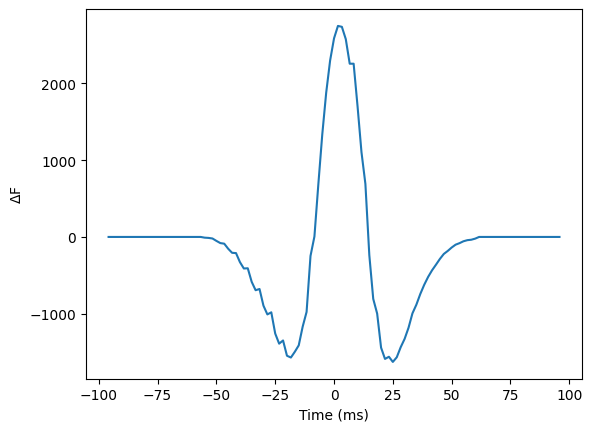

In [10]:
# Number of temporal models for sliding time window inversion
sliding_n_temp_modes = 4
# Size of sliding window (in ms)
win_size = 16
# Whether or not windows overlap
win_overlap = True

# Run sliding time window model comparison between the first layer (pial) and the last layer (white matter)
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    burst_sim_fname, 
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': sliding_n_temp_modes,
        'win_size': win_size, 
        'win_overlap': win_overlap    
    }
)

# Plot difference in free energy over time (pial minus white) - this should be negative at the beginning and end 
# of the burst, and positive at the center
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

## Simulation in each layer with sliding time window model comparison across layers
That was sliding time window model comparison with two candidate models: one based on the white matter surface, and one on the pial. Let's run it across all layers. We'll turn off SPM visualization here.

In [11]:
# Run sliding window model comparison across all layers
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    layer_fnames, 
    burst_sim_fname, 
    viz=False,
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': sliding_n_temp_modes,
        'win_size': win_size, 
        'win_overlap': win_overlap    
    }
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
23-Jul-2024 08:20:05 - Running job #1
------------------------------------------------------------------------
23-Jul-2024 08:20:05 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:20:29 - 23/07/2024
Completed                               :          08:20:29 - 23/07/2024
23-Jul-2024 08:20:30 - Done    'Head model specification'
23-Jul-2024 08:20:30 - Done

Smoothing ../te

  ReML Iteration              : 13                            ...4.813080e+00
  ReML Iteration              : 14                            ...2.775432e+00
  ReML Iteration              : 15                            ...1.545012e+00
  ReML Iteration              : 16                            ...8.406943e-01
  ReML Iteration              : 17                            ...4.528942e-01
  ReML Iteration              : 18                            ...2.448716e-01
  ReML Iteration              : 19                            ...1.349811e-01
  ReML Iteration              : 20                            ...7.731838e-02
  ReML Iteration              : 21                            ...4.713576e-02
  ReML Iteration              : 22                            ...3.153330e-02
  ReML Iteration              : 23                            ...2.411452e-02
  ReML Iteration              : 24                            ...2.236534e-02
  ReML Iteration              : 25                            ..

Percent variance explained -3.18 (-3.11)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.848803e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186541e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126071e+02 [+4.38]
  ReML Iteration 4                      :        ...1.027671e+02 [+4.50]
  ReML Iteration 5                      :        ...8.124830e+01 [+4.62]
  ReML Iteration 6                      :        ...5.067312e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.40

  ReML Iteration              : 1                            ...1.085802e+

  ReML Iteration              : 19                            ...7.893410e-02
  ReML Iteration              : 20                            ...3.892369e-02
  ReML Iteration              : 21                            ...1.921055e-02
  ReML Iteration              : 22                            ...9.516298e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220545e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192987e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168115e+02 [+4.38]
  ReML Iteration 4                      :        ...1.107815e+02 [+4.50]
  ReML Iteration 5                      :        ...9.678673e+01 [+4.62]
  ReML Iteration 6                      :        ...6.274923e-03 [+4.75]
Percent variance explained -3.76 (-3.14)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.64 percent average variance
Using 1 spatial source priors provi

  ReML Iteration              : 7                            ...4.049671e+01
  ReML Iteration              : 8                            ...3.309828e+01
  ReML Iteration              : 9                            ...2.575856e+01
  ReML Iteration              : 10                            ...1.891480e+01
  ReML Iteration              : 11                            ...1.304621e+01
  ReML Iteration              : 12                            ...8.461959e+00
  ReML Iteration              : 13                            ...5.195611e+00
  ReML Iteration              : 14                            ...3.052645e+00
  ReML Iteration              : 15                            ...1.739741e+00
  ReML Iteration              : 16                            ...9.771310e-01
  ReML Iteration              : 17                            ...5.516739e-01
  ReML Iteration              : 18                            ...3.224371e-01
  ReML Iteration              : 19                            ...2.

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219540e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193954e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170686e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114381e+02 [+4.50]
  ReML Iteration 5                      :        ...6.119329e-04 [+4.62]
Percent variance explained -102.05 (-91.34)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.839327e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187302e+02 [+4.25]
  ReML Iterat

  ReML Iteration              : 13                            ...4.271596e+00
  ReML Iteration              : 14                            ...2.396689e+00
  ReML Iteration              : 15                            ...1.291689e+00
  ReML Iteration              : 16                            ...6.755799e-01
  ReML Iteration              : 17                            ...3.460811e-01
  ReML Iteration              : 18                            ...1.750342e-01
  ReML Iteration              : 19                            ...8.798387e-02
  ReML Iteration              : 20                            ...4.419017e-02
  ReML Iteration              : 21                            ...2.226451e-02
  ReML Iteration              : 22                            ...1.128337e-02
  ReML Iteration              : 23                            ...5.761210e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220271e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.083523e+02
  ReML Iteration              : 2                            ...8.436812e+01
  ReML Iteration              : 3                            ...7.059169e+01
  ReML Iteration              : 4                            ...6.044402e+01
  ReML Iteration              : 5                            ...5.161384e+01
  ReML Iteration              : 6                            ...4.310131e+01
  ReML Iteration              : 7                            ...3.458346e+01
  ReML Iteration              : 8                            ...2.623471e+01
  ReML Iteration              : 9                            ...1.856605e+01
  ReML Iteration              : 10                            ...1.215404e+01
  ReML Iteration              : 11                            ...7.344595e+00
  ReML Iteration              : 12                            ...4.114827e+00
  ReML Iteration              : 13                            ...2.157715

Percent variance explained -131.99 (-110.52)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.46 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.132685e+02 [+4.12]
  ReML Iteration 2                      :        ...1.164536e+02 [+4.25]
  ReML Iteration 3                      :        ...1.061875e+02 [+4.38]
  ReML Iteration 4                      :        ...8.809583e+01 [+4.50]
  ReML Iteration 5                      :        ...5.499873e+01 [+4.62]
  ReML Iteration 6                      :        ...6.966507e-01 [+4.75]
  ReML Iteration 7                      :        ...4.941282e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.49   -3.0

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.261216e+02 [+4.12]
  ReML Iteration 2                      :        ...1.170332e+02 [+4.25]
  ReML Iteration 3                      :        ...1.108982e+02 [+4.38]
  ReML Iteration 4                      :        ...9.638892e+01 [+4.50]
  ReML Iteration 5                      :        ...6.729300e+01 [+4.62]
  ReML Iteration 6                      :        ...1.888501e+00 [+4.75]
  ReML Iteration 7                      :        ...2.732205e-05 [+4.88]
Percent variance explained -434.26 (-363.10)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.52 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Itera

  ReML Iteration              : 13                            ...3.881886e-02
  ReML Iteration              : 14                            ...1.551285e-02
  ReML Iteration              : 15                            ...6.311615e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.481871e+02 [+4.12]
  ReML Iteration 2                      :        ...1.119069e+02 [+4.25]
  ReML Iteration 3                      :        ...9.825781e+01 [+4.38]
  ReML Iteration 4                      :        ...6.992972e+01 [+4.50]
  ReML Iteration 5                      :        ...2.963693e+01 [+4.62]
  ReML Iteration 6                      :        ...1.992197e+01 [+4.75]
  ReML Iteration 7                      :        ...2.965040e-03 [+4.88]
Percent variance explained -3000.96 (-2502.21)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.48 percent average variance
Using 1 spatial source priors prov

Percent variance explained 80.93 (67.65)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.43 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.284602e+03 [+4.12]
  ReML Iteration 2                      :        ...9.264820e+01 [+4.25]
  ReML Iteration 3                      :        ...3.645073e+01 [+4.38]
  ReML Iteration 4                      :        ...6.213216e+00 [+4.50]
  ReML Iteration 5                      :        ...1.216555e-01 [+4.62]
  ReML Iteration 6                      :        ...4.068844e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2374.99
    9.45   -0.93

  ReML Iteration              : 1                            ...2.859428e+

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.252789e+03 [+4.12]
  ReML Iteration 2                      :        ...8.496677e+01 [+4.25]
  ReML Iteration 3                      :        ...3.067938e+01 [+4.38]
  ReML Iteration 4                      :        ...3.877773e+00 [+4.50]
  ReML Iteration 5                      :        ...3.928976e-02 [+4.62]
  ReML Iteration 6                      :        ...2.273609e-06 [+4.75]
Percent variance explained 91.52 (82.47)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.230722e+03 [+4.12]
  ReML Iteration

  ReML Iteration 1                      :        ...9.577157e+03 [+4.12]
  ReML Iteration 2                      :        ...1.713524e+03 [+4.25]
  ReML Iteration 3                      :        ...4.507226e+01 [+4.38]
  ReML Iteration 4                      :        ...2.857097e-02 [+4.50]
  ReML Iteration 5                      :        ...1.115342e-08 [+4.62]
log evidence & hyperparameters:
    0.00 20675.33
    9.35    1.45

  ReML Iteration              : 1                            ...6.828571e+03
  ReML Iteration              : 2                            ...8.852217e+02
  ReML Iteration              : 3                            ...1.075287e+02
  ReML Iteration              : 4                            ...1.628120e+01
  ReML Iteration              : 5                            ...3.089823e+00
  ReML Iteration              : 6                            ...6.978687e-01
  ReML Iteration              : 7                            ...1.796401e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...1.415647e+04 [+4.12]
  ReML Iteration 2                      :        ...4.274138e+03 [+4.25]
  ReML Iteration 3                      :        ...3.379670e+02 [+4.38]
  ReML Iteration 4                      :        ...2.038198e+00 [+4.50]
  ReML Iteration 5                      :        ...7.431538e-05 [+4.62]
log evidence & hyperparameters:
    0.00 30271.48
    9.23    1.99

  ReML Iteration              : 1                            ...1.113115e+04
  ReML Iteration              : 2                            ...2.437199e+03
  ReML Iteration              : 3                            ...4.228887e+02
  ReML Iteration              : 4                            ...7.476683e+01
  ReML Iteration              : 5                            ...1.508708e+01
  ReML Iteration              : 6                            ...3.496122e+00
  ReML Iteration              : 7                            ...9.104390e-01
  ReML Iteration            

  ReML Iteration              : 13                            ...3.998899e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.605357e+04 [+4.12]
  ReML Iteration 2                      :        ...5.139938e+03 [+4.25]
  ReML Iteration 3                      :        ...3.506996e+02 [+4.38]
  ReML Iteration 4                      :        ...1.117232e+00 [+4.50]
  ReML Iteration 5                      :        ...9.994134e-06 [+4.62]
Percent variance explained 97.76 (93.47)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.907980e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.559666e+04
  ReML Iteration              : 2                            ...5.112233e+03
  ReML Iteration              : 3                            ...1.291259e+03
  ReML Iteration              : 4                            ...2.862734e+02
  ReML Iteration              : 5                            ...6.439671e+01
  ReML Iteration              : 6                            ...1.568256e+01
  ReML Iteration              : 7                            ...4.180443e+00
  ReML Iteration              : 8                            ...1.210188e+00
  ReML Iteration              : 9                            ...3.760352e-01
  ReML Iteration              : 10                            ...1.240551e-01
  ReML Iteration              : 11                            ...4.305810e-02
  ReML Iteration              : 12                            ...1.560796e-02
  ReML Iteration              : 13                            ...5.873656

Percent variance explained 95.24 (87.38)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.16 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.272335e+04 [+4.12]
  ReML Iteration 2                      :        ...3.322425e+03 [+4.25]
  ReML Iteration 3                      :        ...1.929970e+02 [+4.38]
  ReML Iteration 4                      :        ...6.131806e-01 [+4.50]
  ReML Iteration 5                      :        ...6.117755e-06 [+4.62]
log evidence & hyperparameters:
    0.00 27159.58
    9.33    1.88

  ReML Iteration              : 1                            ...9.762886e+03
  ReML Iteration              : 2                            ...1.844

Percent variance explained 89.29 (80.14)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.97 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.229727e+03 [+4.12]
  ReML Iteration 2                      :        ...1.210021e+03 [+4.25]
  ReML Iteration 3                      :        ...2.125627e+01 [+4.38]
  ReML Iteration 4                      :        ...6.003007e-03 [+4.50]
log evidence & hyperparameters:
    0.00 17974.98
    9.42    1.31

  ReML Iteration              : 1                            ...5.610281e+03
  ReML Iteration              : 2                            ...6.012858e+02
  ReML Iteration              : 3                            ...6

Percent variance explained 94.33 (89.58)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.80 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.576512e+04 [+4.12]
  ReML Iteration 2                      :        ...5.519157e+03 [+4.25]
  ReML Iteration 3                      :        ...5.991486e+02 [+4.38]
  ReML Iteration 4                      :        ...7.061726e+00 [+4.50]
  ReML Iteration 5                      :        ...1.012841e-03 [+4.62]
log evidence & hyperparameters:
    0.00 33943.09
    9.22    2.23

  ReML Iteration              : 1                            ...1.268545e+04
  ReML Iteration              : 2                            ...3.234

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.407330e+04 [+4.12]
  ReML Iteration 2                      :        ...3.712935e+03 [+4.25]
  ReML Iteration 3                      :        ...1.686326e+02 [+4.38]
  ReML Iteration 4                      :        ...2.462494e-01 [+4.50]
  ReML Iteration 5                      :        ...4.763954e-07 [+4.62]
Percent variance explained 95.08 (91.00)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.01 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.425382e+04 [+4.12]
  ReML Iteration 2                      :        ...4.344073e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...2.529388e-01
  ReML Iteration              : 8                            ...7.204021e-02
  ReML Iteration              : 9                            ...2.219776e-02
  ReML Iteration              : 10                            ...7.290201e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.568046e+03 [+4.12]
  ReML Iteration 2                      :        ...1.139289e+03 [+4.25]
  ReML Iteration 3                      :        ...1.497782e+01 [+4.38]
  ReML Iteration 4                      :        ...1.735842e-02 [+4.50]
  ReML Iteration 5                      :        ...1.557373e-07 [+4.62]
Percent variance explained 92.08 (80.24)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.28 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.418855e+03 [+4.12]
  ReML Iteration 2                      :        ...1.094224e+03 [+4.25]
  ReML Iteration 3                      :        ...1.402446e+01 [+4.38]
  ReML Iteration 4                      :        ...1.844427e-02 [+4.50]
  ReML Iteration 5                      :        ...1.951416e-07 [+4.62]
Percent variance explained 92.30 (85.60)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.69 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.476083e+04 [+4.12]
  ReML Iteration 2                      :        ...4.719420e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...4.042582e+00
  ReML Iteration              : 8                            ...1.169860e+00
  ReML Iteration              : 9                            ...3.634366e-01
  ReML Iteration              : 10                            ...1.198867e-01
  ReML Iteration              : 11                            ...4.160899e-02
  ReML Iteration              : 12                            ...1.508219e-02
  ReML Iteration              : 13                            ...5.675691e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.715582e+04 [+4.12]
  ReML Iteration 2                      :        ...6.067087e+03 [+4.25]
  ReML Iteration 3                      :        ...5.124104e+02 [+4.38]
  ReML Iteration 4                      :        ...2.462861e+00 [+4.50]
  ReML Iteration 5                      :        ...4.901682e-05 [+4.62]
Percent variance explained 96.96 (90.93)

  ReML Iteration 1                      :        ...1.867249e+04 [+4.12]
  ReML Iteration 2                      :        ...8.277670e+03 [+4.25]
  ReML Iteration 3                      :        ...1.496066e+03 [+4.38]
  ReML Iteration 4                      :        ...5.328025e+01 [+4.50]
  ReML Iteration 5                      :        ...7.835798e-02 [+4.62]
  ReML Iteration 6                      :        ...1.769931e-07 [+4.75]
log evidence & hyperparameters:
    0.00 41250.32
    9.00    2.51

  ReML Iteration              : 1                            ...1.553530e+04
  ReML Iteration              : 2                            ...5.067118e+03
  ReML Iteration              : 3                            ...1.273240e+03
  ReML Iteration              : 4                            ...2.812534e+02
  ReML Iteration              : 5                            ...6.314475e+01
  ReML Iteration              : 6                            ...1.536327e+01
  ReML Iteration              : 

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.393210e+04 [+4.12]
  ReML Iteration 2                      :        ...3.622289e+03 [+4.25]
  ReML Iteration 3                      :        ...1.596047e+02 [+4.38]
  ReML Iteration 4                      :        ...2.199934e-01 [+4.50]
  ReML Iteration 5                      :        ...3.794942e-07 [+4.62]
Percent variance explained 97.72 (89.39)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.34 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.416022e+04 [+4.12]
  ReML Iteration 2                      :        ...4.276820e+03 [+4.25]
  ReML Iteration

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.613984e+03 [+4.12]
  ReML Iteration 2                      :        ...8.706880e+02 [+4.25]
  ReML Iteration 3                      :        ...1.014318e+01 [+4.38]
  ReML Iteration 4                      :        ...2.702318e-02 [+4.50]
  ReML Iteration 5                      :        ...6.285600e-07 [+4.62]
Percent variance explained 96.97 (89.77)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.40 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.021284e+03 [+4.12]
  ReML Iteration 2                      :        ...1.141365e+03 [+4.25]
  ReML Iteration

  ReML Iteration 1                      :        ...3.095873e+03 [+4.12]
  ReML Iteration 2                      :        ...1.652985e+02 [+4.25]
  ReML Iteration 3                      :        ...5.930225e+00 [+4.38]
  ReML Iteration 4                      :        ...1.014899e-01 [+4.50]
  ReML Iteration 5                      :        ...2.941651e-05 [+4.62]
log evidence & hyperparameters:
    0.00 7210.88
    9.45    0.20

  ReML Iteration              : 1                            ...1.377151e+03
  ReML Iteration              : 2                            ...7.241613e+01
  ReML Iteration              : 3                            ...1.247097e+01
  ReML Iteration              : 4                            ...2.889869e+00
  ReML Iteration              : 5                            ...6.959943e-01
  ReML Iteration              : 6                            ...1.764883e-01
  ReML Iteration              : 7                            ...4.801893e-02
  ReML Iteration             

  ReML Iteration 1                      :        ...1.244246e+03 [+4.12]
  ReML Iteration 2                      :        ...9.299383e+01 [+4.25]
  ReML Iteration 3                      :        ...3.844955e+01 [+4.38]
  ReML Iteration 4                      :        ...7.050000e+00 [+4.50]
  ReML Iteration 5                      :        ...1.595805e-01 [+4.62]
  ReML Iteration 6                      :        ...6.970039e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2246.00
    9.48   -0.96

  ReML Iteration              : 1                            ...2.689276e+02
  ReML Iteration              : 2                            ...6.003628e+01
  ReML Iteration              : 3                            ...3.351406e+01
  ReML Iteration              : 4                            ...1.665547e+01
  ReML Iteration              : 5                            ...7.040580e+00
  ReML Iteration              : 6                            ...2.605194e+00
  ReML Iteration              : 7

  ReML Iteration 7                      :        ...5.808725e-05 [+4.88]
log evidence & hyperparameters:
    0.00  705.65
    9.48   -1.98

  ReML Iteration              : 1                            ...1.279570e+02
  ReML Iteration              : 2                            ...7.384481e+01
  ReML Iteration              : 3                            ...5.365277e+01
  ReML Iteration              : 4                            ...3.695955e+01
  ReML Iteration              : 5                            ...2.304778e+01
  ReML Iteration              : 6                            ...1.268275e+01
  ReML Iteration              : 7                            ...6.141521e+00
  ReML Iteration              : 8                            ...2.669549e+00
  ReML Iteration              : 9                            ...1.077134e+00
  ReML Iteration              : 10                            ...4.175898e-01
  ReML Iteration              : 11                            ...1.597953e-01
  ReML Iter

  ReML Iteration              : 1                            ...1.094366e+02
  ReML Iteration              : 2                            ...8.114793e+01
  ReML Iteration              : 3                            ...6.518715e+01
  ReML Iteration              : 4                            ...5.227651e+01
  ReML Iteration              : 5                            ...4.041068e+01
  ReML Iteration              : 6                            ...2.927797e+01
  ReML Iteration              : 7                            ...1.943788e+01
  ReML Iteration              : 8                            ...1.166071e+01
  ReML Iteration              : 9                            ...6.307561e+00
  ReML Iteration              : 10                            ...3.109349e+00
  ReML Iteration              : 11                            ...1.425151e+00
  ReML Iteration              : 12                            ...6.218524e-01
  ReML Iteration              : 13                            ...2.639686

  ReML Iteration 1                      :        ...6.033350e+02 [+4.12]
  ReML Iteration 2                      :        ...1.172066e+02 [+4.25]
  ReML Iteration 3                      :        ...1.083685e+02 [+4.38]
  ReML Iteration 4                      :        ...9.291330e+01 [+4.50]
  ReML Iteration 5                      :        ...6.290993e+01 [+4.62]
  ReML Iteration 6                      :        ...3.243314e-01 [+4.75]
  ReML Iteration 7                      :        ...1.075106e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -3.19

  ReML Iteration              : 1                            ...1.082768e+02
  ReML Iteration              : 2                            ...8.387919e+01
  ReML Iteration              : 3                            ...6.975741e+01
  ReML Iteration              : 4                            ...5.914076e+01
  ReML Iteration              : 5                            ...4.973303e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...3.517106e-02
  ReML Iteration              : 20                            ...1.627239e-02
  ReML Iteration              : 21                            ...7.560219e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223701e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190256e+02 [+4.25]
  ReML Iteration 3                      :        ...1.160877e+02 [+4.38]
  ReML Iteration 4                      :        ...1.089472e+02 [+4.50]
  ReML Iteration 5                      :        ...9.263323e+01 [+4.62]
  ReML Iteration 6                      :        ...5.437969e-02 [+4.75]
  ReML Iteration 7                      :        ...2.328861e-08 [+4.88]
Percent variance explained -62.14 (-52.02)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.54 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 7                            ...4.056768e+01
  ReML Iteration              : 8                            ...3.318458e+01
  ReML Iteration              : 9                            ...2.585447e+01
  ReML Iteration              : 10                            ...1.901153e+01
  ReML Iteration              : 11                            ...1.313468e+01
  ReML Iteration              : 12                            ...8.535906e+00
  ReML Iteration              : 13                            ...5.252986e+00
  ReML Iteration              : 14                            ...3.094913e+00
  ReML Iteration              : 15                            ...1.770150e+00
  ReML Iteration              : 16                            ...9.992584e-01
  ReML Iteration              : 17                            ...5.687728e-01
  ReML Iteration              : 18                            ...3.375644e-01
  ReML Iteration              : 19                            ...2.

  ReML Iteration              : 25                            ...5.884021e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219188e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194307e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171626e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116787e+02 [+4.50]
  ReML Iteration 5                      :        ...2.389646e-05 [+4.62]
Percent variance explained -68.50 (-57.27)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.844685e+02 [+4.12]
  ReML It

  ReML Iteration              : 7                            ...3.960206e+01
  ReML Iteration              : 8                            ...3.201841e+01
  ReML Iteration              : 9                            ...2.456983e+01
  ReML Iteration              : 10                            ...1.772989e+01
  ReML Iteration              : 11                            ...1.197757e+01
  ReML Iteration              : 12                            ...7.583690e+00
  ReML Iteration              : 13                            ...4.528151e+00
  ReML Iteration              : 14                            ...2.574142e+00
  ReML Iteration              : 15                            ...1.408592e+00
  ReML Iteration              : 16                            ...7.501502e-01
  ReML Iteration              : 17                            ...3.928098e-01
  ReML Iteration              : 18                            ...2.041562e-01
  ReML Iteration              : 19                            ...1.

  ReML Iteration 1                      :        ...5.846788e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186703e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126548e+02 [+4.38]
  ReML Iteration 4                      :        ...1.028817e+02 [+4.50]
  ReML Iteration 5                      :        ...8.147920e+01 [+4.62]
  ReML Iteration 6                      :        ...4.316827e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.40

  ReML Iteration              : 1                            ...1.085861e+02
  ReML Iteration              : 2                            ...8.503283e+01
  ReML Iteration              : 3                            ...7.173400e+01
  ReML Iteration              : 4                            ...6.225392e+01
  ReML Iteration              : 5                            ...5.428525e+01
  ReML Iteration              : 6                            ...4.676471e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...8.988674e-02
  ReML Iteration              : 20                            ...4.533260e-02
  ReML Iteration              : 21                            ...2.295085e-02
  ReML Iteration              : 22                            ...1.169600e-02
  ReML Iteration              : 23                            ...6.009213e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220221e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193293e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168928e+02 [+4.38]
  ReML Iteration 4                      :        ...1.109889e+02 [+4.50]
  ReML Iteration 5                      :        ...3.833887e-03 [+4.62]
Percent variance explained -26.98 (-26.33)
Number of samples 6
Fixed number of temporal modes
Using 4 temporal modes, accounting for 98.21 percent average variance
Using 1 spatial source priors

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
23-Jul-2024 08:28:34 - Running job #1
------------------------------------------------------------------------
23-Jul-2024 08:28:34 - Running 'Source inversion, iterative'
Using 1 iterations of 1 patches
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_burst_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldspatchiter 1/1
Checking leadfields
ans =

    0.3898    0.7842
    0.0190    0.0898

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 5
Fixed number of temp

  ReML Iteration 1                      :        ...5.830868e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187983e+02 [+4.25]
  ReML Iteration 3                      :        ...1.130326e+02 [+4.38]
  ReML Iteration 4                      :        ...1.037928e+02 [+4.50]
  ReML Iteration 5                      :        ...8.332991e+01 [+4.62]
  ReML Iteration 6                      :        ...4.994492e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.47   -3.39

  ReML Iteration              : 1                            ...1.086343e+02
  ReML Iteration              : 2                            ...8.513319e+01
  ReML Iteration              : 3                            ...7.190729e+01
  ReML Iteration              : 4                            ...6.253107e+01
  ReML Iteration              : 5                            ...5.470044e+01
  ReML Iteration              : 6                            ...4.734690e+01
  ReML Iteration              : 7

  ReML Iteration              : 13                            ...4.193077e+00
  ReML Iteration              : 14                            ...2.343098e+00
  ReML Iteration              : 15                            ...1.256990e+00
  ReML Iteration              : 16                            ...6.539542e-01
  ReML Iteration              : 17                            ...3.329491e-01
  ReML Iteration              : 18                            ...1.671900e-01
  ReML Iteration              : 19                            ...8.334163e-02
  ReML Iteration              : 20                            ...4.145553e-02
  ReML Iteration              : 21                            ...2.065708e-02
  ReML Iteration              : 22                            ...1.033980e-02
  ReML Iteration              : 23                            ...5.208106e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220404e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.085585e+02
  ReML Iteration              : 2                            ...8.497213e+01
  ReML Iteration              : 3                            ...7.162931e+01
  ReML Iteration              : 4                            ...6.208681e+01
  ReML Iteration              : 5                            ...5.403569e+01
  ReML Iteration              : 6                            ...4.641644e+01
  ReML Iteration              : 7                            ...3.875818e+01
  ReML Iteration              : 8                            ...3.101332e+01
  ReML Iteration              : 9                            ...2.348238e+01
  ReML Iteration              : 10                            ...1.666886e+01
  ReML Iteration              : 11                            ...1.104485e+01
  ReML Iteration              : 12                            ...6.840111e+00
  ReML Iteration              : 13                            ...3.983598

Percent variance explained -9.52 (-7.95)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.842292e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187064e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127613e+02 [+4.38]
  ReML Iteration 4                      :        ...1.031380e+02 [+4.50]
  ReML Iteration 5                      :        ...8.199725e+01 [+4.62]
  ReML Iteration 6                      :        ...2.858211e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.37

  ReML Iteration              : 1                            ...1.085993e+

  ReML Iteration              : 7                            ...3.954862e+01
  ReML Iteration              : 8                            ...3.195438e+01
  ReML Iteration              : 9                            ...2.450000e+01
  ReML Iteration              : 10                            ...1.766109e+01
  ReML Iteration              : 11                            ...1.191639e+01
  ReML Iteration              : 12                            ...7.534253e+00
  ReML Iteration              : 13                            ...4.491356e+00
  ReML Iteration              : 14                            ...2.548471e+00
  ReML Iteration              : 15                            ...1.391488e+00
  ReML Iteration              : 16                            ...7.390706e-01
  ReML Iteration              : 17                            ...3.857183e-01
  ReML Iteration              : 18                            ...1.996063e-01
  ReML Iteration              : 19                            ...1.

  ReML Iteration 1                      :        ...5.907821e+02 [+4.12]
  ReML Iteration 2                      :        ...1.181842e+02 [+4.25]
  ReML Iteration 3                      :        ...1.112243e+02 [+4.38]
  ReML Iteration 4                      :        ...9.948001e+01 [+4.50]
  ReML Iteration 5                      :        ...7.479996e+01 [+4.62]
  ReML Iteration 6                      :        ...5.353335e-02 [+4.75]
  ReML Iteration 7                      :        ...2.967737e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -3.29

  ReML Iteration              : 1                            ...1.084335e+02
  ReML Iteration              : 2                            ...8.465090e+01
  ReML Iteration              : 3                            ...7.107651e+01
  ReML Iteration              : 4                            ...6.120858e+01
  ReML Iteration              : 5                            ...5.273388e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...2.256769e-02
  ReML Iteration              : 20                            ...1.030710e-02
  ReML Iteration              : 21                            ...4.740552e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.226502e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188117e+02 [+4.25]
  ReML Iteration 3                      :        ...1.155231e+02 [+4.38]
  ReML Iteration 4                      :        ...1.075303e+02 [+4.50]
  ReML Iteration 5                      :        ...8.950637e+01 [+4.62]
  ReML Iteration 6                      :        ...1.254409e-01 [+4.75]
  ReML Iteration 7                      :        ...1.228350e-07 [+4.88]
Percent variance explained -75.73 (-67.82)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.70 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 7                            ...2.829705e+01
  ReML Iteration              : 8                            ...1.965317e+01
  ReML Iteration              : 9                            ...1.250246e+01
  ReML Iteration              : 10                            ...7.259156e+00
  ReML Iteration              : 11                            ...3.867951e+00
  ReML Iteration              : 12                            ...1.916279e+00
  ReML Iteration              : 13                            ...8.982854e-01
  ReML Iteration              : 14                            ...4.057459e-01
  ReML Iteration              : 15                            ...1.794466e-01
  ReML Iteration              : 16                            ...7.867618e-02
  ReML Iteration              : 17                            ...3.449395e-02
  ReML Iteration              : 18                            ...1.520733e-02
  ReML Iteration              : 19                            ...6.

  ReML Iteration              : 1                            ...1.093393e+02
  ReML Iteration              : 2                            ...8.125408e+01
  ReML Iteration              : 3                            ...6.536199e+01
  ReML Iteration              : 4                            ...5.253063e+01
  ReML Iteration              : 5                            ...4.073847e+01
  ReML Iteration              : 6                            ...2.964743e+01
  ReML Iteration              : 7                            ...1.979511e+01
  ReML Iteration              : 8                            ...1.195327e+01
  ReML Iteration              : 9                            ...6.510416e+00
  ReML Iteration              : 10                            ...3.230196e+00
  ReML Iteration              : 11                            ...1.488719e+00
  ReML Iteration              : 12                            ...6.523791e-01
  ReML Iteration              : 13                            ...2.777885

  ReML Iteration              : 1                            ...1.280257e+02
  ReML Iteration              : 2                            ...7.382900e+01
  ReML Iteration              : 3                            ...5.362877e+01
  ReML Iteration              : 4                            ...3.693059e+01
  ReML Iteration              : 5                            ...2.301933e+01
  ReML Iteration              : 6                            ...1.266034e+01
  ReML Iteration              : 7                            ...6.127304e+00
  ReML Iteration              : 8                            ...2.662068e+00
  ReML Iteration              : 9                            ...1.073704e+00
  ReML Iteration              : 10                            ...4.161478e-01
  ReML Iteration              : 11                            ...1.592150e-01
  ReML Iteration              : 12                            ...6.118240e-02
  ReML Iteration              : 13                            ...2.384364

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.587897e+02 [+4.12]
  ReML Iteration 2                      :        ...9.622182e+01 [+4.25]
  ReML Iteration 3                      :        ...6.475950e+01 [+4.38]
  ReML Iteration 4                      :        ...2.391536e+01 [+4.50]
  ReML Iteration 5                      :        ...2.232121e+00 [+4.62]
  ReML Iteration 6                      :        ...1.296623e-02 [+4.75]
  ReML Iteration 7                      :        ...2.759796e-07 [+4.88]
Percent variance explained 83.08 (74.30)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.83 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.571090e+03 [+4.12]
  ReML Iteration 2                      :        ...1.241580e+02 [+4.25]
  ReML Iteration 3                      :        ...1.595542e+01 [+4.38]
  ReML Iteration 4                      :        ...8.503493e-01 [+4.50]
  ReML Iteration 5                      :        ...1.548619e-03 [+4.62]
Percent variance explained 94.29 (80.65)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.07 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.319032e+03 [+4.12]
  ReML Iteration 2                      :        ...4.598409e+02 [+4.25]
  ReML Iteration

  ReML Iteration 1                      :        ...9.562705e+03 [+4.12]
  ReML Iteration 2                      :        ...1.707561e+03 [+4.25]
  ReML Iteration 3                      :        ...4.473174e+01 [+4.38]
  ReML Iteration 4                      :        ...2.812180e-02 [+4.50]
  ReML Iteration 5                      :        ...1.079671e-08 [+4.62]
log evidence & hyperparameters:
    0.00 20646.25
    9.35    1.48

  ReML Iteration              : 1                            ...6.815362e+03
  ReML Iteration              : 2                            ...8.818014e+02
  ReML Iteration              : 3                            ...1.069983e+02
  ReML Iteration              : 4                            ...1.619456e+01
  ReML Iteration              : 5                            ...3.072945e+00
  ReML Iteration              : 6                            ...6.940168e-01
  ReML Iteration              : 7                            ...1.786440e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...1.686777e+04 [+4.12]
  ReML Iteration 2                      :        ...6.485971e+03 [+4.25]
  ReML Iteration 3                      :        ...8.617426e+02 [+4.38]
  ReML Iteration 4                      :        ...1.567655e+01 [+4.50]
  ReML Iteration 5                      :        ...5.533050e-03 [+4.62]
log evidence & hyperparameters:
    0.00 36597.51
    9.12    2.33

  ReML Iteration              : 1                            ...1.376062e+04
  ReML Iteration              : 2                            ...3.866935e+03
  ReML Iteration              : 3                            ...8.365590e+02
  ReML Iteration              : 4                            ...1.674526e+02
  ReML Iteration              : 5                            ...3.575818e+01
  ReML Iteration              : 6                            ...8.497559e+00
  ReML Iteration              : 7                            ...2.238896e+00
  ReML Iteration            

  ReML Iteration              : 13                            ...6.822629e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.772861e+04 [+4.12]
  ReML Iteration 2                      :        ...6.588640e+03 [+4.25]
  ReML Iteration 3                      :        ...6.196846e+02 [+4.38]
  ReML Iteration 4                      :        ...3.668195e+00 [+4.50]
  ReML Iteration 5                      :        ...1.093021e-04 [+4.62]
Percent variance explained 97.97 (91.74)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.88 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.935975e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.479806e+04
  ReML Iteration              : 2                            ...4.544286e+03
  ReML Iteration              : 3                            ...1.072922e+03
  ReML Iteration              : 4                            ...2.271478e+02
  ReML Iteration              : 5                            ...4.987886e+01
  ReML Iteration              : 6                            ...1.200798e+01
  ReML Iteration              : 7                            ...3.183300e+00
  ReML Iteration              : 8                            ...9.190004e-01
  ReML Iteration              : 9                            ...2.851496e-01
  ReML Iteration              : 10                            ...9.399952e-02
  ReML Iteration              : 11                            ...3.261222e-02
  ReML Iteration              : 12                            ...1.181858e-02
  ReML Iteration              : 13                            ...4.446979

  ReML Iteration 1                      :        ...1.049928e+04 [+4.12]
  ReML Iteration 2                      :        ...2.120090e+03 [+4.25]
  ReML Iteration 3                      :        ...7.173664e+01 [+4.38]
  ReML Iteration 4                      :        ...7.562435e-02 [+4.50]
  ReML Iteration 5                      :        ...8.212279e-08 [+4.62]
log evidence & hyperparameters:
    0.00 22540.61
    9.38    1.65

  ReML Iteration              : 1                            ...7.677036e+03
  ReML Iteration              : 2                            ...1.121169e+03
  ReML Iteration              : 3                            ...1.459898e+02
  ReML Iteration              : 4                            ...2.269171e+01
  ReML Iteration              : 5                            ...4.348316e+00
  ReML Iteration              : 6                            ...9.859899e-01
  ReML Iteration              : 7                            ...2.542537e-01
  ReML Iteration            

  ReML Iteration              : 1                            ...7.053951e+03
  ReML Iteration              : 2                            ...9.447622e+02
  ReML Iteration              : 3                            ...1.168888e+02
  ReML Iteration              : 4                            ...1.781819e+01
  ReML Iteration              : 5                            ...3.389858e+00
  ReML Iteration              : 6                            ...7.664000e-01
  ReML Iteration              : 7                            ...1.973690e-01
  ReML Iteration              : 8                            ...5.617830e-02
  ReML Iteration              : 9                            ...1.730472e-02
  ReML Iteration              : 10                            ...5.682252e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.897116e+03 [+4.12]
  ReML Iteration 2                      :        ...9.456104e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.329557e+04
  ReML Iteration              : 2                            ...3.584764e+03
  ReML Iteration              : 3                            ...7.457636e+02
  ReML Iteration              : 4                            ...1.457710e+02
  ReML Iteration              : 5                            ...3.077574e+01
  ReML Iteration              : 6                            ...7.275704e+00
  ReML Iteration              : 7                            ...1.912310e+00
  ReML Iteration              : 8                            ...5.497406e-01
  ReML Iteration              : 9                            ...1.702021e-01
  ReML Iteration              : 10                            ...5.604115e-02
  ReML Iteration              : 11                            ...1.943021e-02
  ReML Iteration              : 12                            ...7.038812e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

  ReML Iteration 1                      :        ...1.414587e+04 [+4.12]
  ReML Iteration 2                      :        ...4.266566e+03 [+4.25]
  ReML Iteration 3                      :        ...3.366321e+02 [+4.38]
  ReML Iteration 4                      :        ...2.020879e+00 [+4.50]
  ReML Iteration 5                      :        ...7.300247e-05 [+4.62]
log evidence & hyperparameters:
    0.00 30247.97
    9.30    2.09

  ReML Iteration              : 1                            ...1.112097e+04
  ReML Iteration              : 2                            ...2.432422e+03
  ReML Iteration              : 3                            ...4.217008e+02
  ReML Iteration              : 4                            ...7.452446e+01
  ReML Iteration              : 5                            ...1.503537e+01
  ReML Iteration              : 6                            ...3.483862e+00
  ReML Iteration              : 7                            ...9.072130e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...9.614814e+03 [+4.12]
  ReML Iteration 2                      :        ...1.729119e+03 [+4.25]
  ReML Iteration 3                      :        ...4.596970e+01 [+4.38]
  ReML Iteration 4                      :        ...2.977269e-02 [+4.50]
  ReML Iteration 5                      :        ...1.213695e-08 [+4.62]
log evidence & hyperparameters:
    0.00 20751.14
    9.40    1.53

  ReML Iteration              : 1                            ...6.863003e+03
  ReML Iteration              : 2                            ...8.941732e+02
  ReML Iteration              : 3                            ...1.089207e+02
  ReML Iteration              : 4                            ...1.650879e+01
  ReML Iteration              : 5                            ...3.134180e+00
  ReML Iteration              : 6                            ...7.079935e-01
  ReML Iteration              : 7                            ...1.822586e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...1.658843e+04 [+4.12]
  ReML Iteration 2                      :        ...6.232075e+03 [+4.25]
  ReML Iteration 3                      :        ...7.875408e+02 [+4.38]
  ReML Iteration 4                      :        ...1.285781e+01 [+4.50]
  ReML Iteration 5                      :        ...3.621232e-03 [+4.62]
log evidence & hyperparameters:
    0.00 35913.01
    9.17    2.35

  ReML Iteration              : 1                            ...1.348754e+04
  ReML Iteration              : 2                            ...3.699665e+03
  ReML Iteration              : 3                            ...7.821927e+02
  ReML Iteration              : 4                            ...1.543843e+02
  ReML Iteration              : 5                            ...3.274520e+01
  ReML Iteration              : 6                            ...7.757558e+00
  ReML Iteration              : 7                            ...2.040962e+00
  ReML Iteration            

  ReML Iteration              : 13                            ...6.830510e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.773219e+04 [+4.12]
  ReML Iteration 2                      :        ...6.591982e+03 [+4.25]
  ReML Iteration 3                      :        ...6.204115e+02 [+4.38]
  ReML Iteration 4                      :        ...3.677236e+00 [+4.50]
  ReML Iteration 5                      :        ...1.098453e-04 [+4.62]
Percent variance explained 97.54 (91.61)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 96.15 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.886183e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.456128e+04
  ReML Iteration              : 2                            ...4.383764e+03
  ReML Iteration              : 3                            ...1.014551e+03
  ReML Iteration              : 4                            ...2.119801e+02
  ReML Iteration              : 5                            ...4.623759e+01
  ReML Iteration              : 6                            ...1.109642e+01
  ReML Iteration              : 7                            ...2.937244e+00
  ReML Iteration              : 8                            ...8.473366e-01
  ReML Iteration              : 9                            ...2.628127e-01
  ReML Iteration              : 10                            ...8.661824e-02
  ReML Iteration              : 11                            ...3.004790e-02
  ReML Iteration              : 12                            ...1.088856e-02
  ReML Iteration              : 13                            ...4.096881

  ReML Iteration 1                      :        ...1.275423e+04 [+4.12]
  ReML Iteration 2                      :        ...3.341423e+03 [+4.25]
  ReML Iteration 3                      :        ...1.954519e+02 [+4.38]
  ReML Iteration 4                      :        ...6.299314e-01 [+4.50]
  ReML Iteration 5                      :        ...6.468820e-06 [+4.62]
log evidence & hyperparameters:
    0.00 27225.32
    9.26    1.86

  ReML Iteration              : 1                            ...9.792182e+03
  ReML Iteration              : 2                            ...1.855954e+03
  ReML Iteration              : 3                            ...2.879895e+02
  ReML Iteration              : 4                            ...4.822928e+01
  ReML Iteration              : 5                            ...9.514689e+00
  ReML Iteration              : 6                            ...2.183684e+00
  ReML Iteration              : 7                            ...5.661699e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...6.490255e+03 [+4.12]
  ReML Iteration 2                      :        ...7.091100e+02 [+4.25]
  ReML Iteration 3                      :        ...7.085512e+00 [+4.38]
  ReML Iteration 4                      :        ...1.237111e-03 [+4.50]
log evidence & hyperparameters:
    0.00 14482.70
    9.39    1.02

  ReML Iteration              : 1                            ...4.085568e+03
  ReML Iteration              : 2                            ...3.317389e+02
  ReML Iteration              : 3                            ...3.301128e+01
  ReML Iteration              : 4                            ...4.720873e+00
  ReML Iteration              : 5                            ...8.796849e-01
  ReML Iteration              : 6                            ...1.972917e-01
  ReML Iteration              : 7                            ...5.062672e-02
  ReML Iteration              : 8                            ...1.438477e-02
  ReML Iteration        

  ReML Iteration              : 7                            ...8.471629e-02
  ReML Iteration              : 8                            ...2.516021e-02
  ReML Iteration              : 9                            ...7.919198e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.160094e+03 [+4.12]
  ReML Iteration 2                      :        ...8.443675e+01 [+4.25]
  ReML Iteration 3                      :        ...3.250801e+01 [+4.38]
  ReML Iteration 4                      :        ...4.447489e+00 [+4.50]
  ReML Iteration 5                      :        ...5.279915e-02 [+4.62]
  ReML Iteration 6                      :        ...4.429422e-06 [+4.75]
Percent variance explained 91.79 (82.74)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.08 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  Re

  ReML Iteration              : 1                            ...1.675395e+02
  ReML Iteration              : 2                            ...6.762801e+01
  ReML Iteration              : 3                            ...4.446428e+01
  ReML Iteration              : 4                            ...2.672072e+01
  ReML Iteration              : 5                            ...1.399664e+01
  ReML Iteration              : 6                            ...6.348672e+00
  ReML Iteration              : 7                            ...2.558440e+00
  ReML Iteration              : 8                            ...9.563759e-01
  ReML Iteration              : 9                            ...3.457545e-01
  ReML Iteration              : 10                            ...1.245510e-01
  ReML Iteration              : 11                            ...4.548536e-02
  ReML Iteration              : 12                            ...1.698122e-02
  ReML Iteration              : 13                            ...6.501074

  ReML Iteration              : 7                            ...1.246270e+01
  ReML Iteration              : 8                            ...6.468283e+00
  ReML Iteration              : 9                            ...3.034933e+00
  ReML Iteration              : 10                            ...1.320180e+00
  ReML Iteration              : 11                            ...5.477472e-01
  ReML Iteration              : 12                            ...2.221485e-01
  ReML Iteration              : 13                            ...8.963767e-02
  ReML Iteration              : 14                            ...3.638710e-02
  ReML Iteration              : 15                            ...1.495289e-02
  ReML Iteration              : 16                            ...6.239635e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.362383e+02 [+4.12]
  ReML Iteration 2                      :        ...1.141515e+02 [+4.25]
  ReML Iteration 3       

  ReML Iteration              : 1                            ...1.083334e+02
  ReML Iteration              : 2                            ...8.308186e+01
  ReML Iteration              : 3                            ...6.840755e+01
  ReML Iteration              : 4                            ...5.706512e+01
  ReML Iteration              : 5                            ...4.681102e+01
  ReML Iteration              : 6                            ...3.687224e+01
  ReML Iteration              : 7                            ...2.730657e+01
  ReML Iteration              : 8                            ...1.868433e+01
  ReML Iteration              : 9                            ...1.168145e+01
  ReML Iteration              : 10                            ...6.657276e+00
  ReML Iteration              : 11                            ...3.482718e+00
  ReML Iteration              : 12                            ...1.696989e+00
  ReML Iteration              : 13                            ...7.845292

Percent variance explained -150.59 (-134.61)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.926563e+02 [+4.12]
  ReML Iteration 2                      :        ...1.180363e+02 [+4.25]
  ReML Iteration 3                      :        ...1.107906e+02 [+4.38]
  ReML Iteration 4                      :        ...9.846365e+01 [+4.50]
  ReML Iteration 5                      :        ...7.287409e+01 [+4.62]
  ReML Iteration 6                      :        ...7.956821e-02 [+4.75]
  ReML Iteration 7                      :        ...6.531986e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -3.2

  ReML Iteration              : 13                            ...2.899947e+00
  ReML Iteration              : 14                            ...1.509133e+00
  ReML Iteration              : 15                            ...7.517499e-01
  ReML Iteration              : 16                            ...3.625897e-01
  ReML Iteration              : 17                            ...1.711350e-01
  ReML Iteration              : 18                            ...7.975889e-02
  ReML Iteration              : 19                            ...3.697315e-02
  ReML Iteration              : 20                            ...1.714006e-02
  ReML Iteration              : 21                            ...7.976184e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223439e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190467e+02 [+4.25]
  ReML Iteration 3                      :        ...1.161437e+02 [+4.38]
  ReML Iteration 4         

  ReML Iteration              : 1                            ...1.086299e+02
  ReML Iteration              : 2                            ...8.512437e+01
  ReML Iteration              : 3                            ...7.189206e+01
  ReML Iteration              : 4                            ...6.250668e+01
  ReML Iteration              : 5                            ...5.466384e+01
  ReML Iteration              : 6                            ...4.729544e+01
  ReML Iteration              : 7                            ...3.990030e+01
  ReML Iteration              : 8                            ...3.237677e+01
  ReML Iteration              : 9                            ...2.496198e+01
  ReML Iteration              : 10                            ...1.811790e+01
  ReML Iteration              : 11                            ...1.232439e+01
  ReML Iteration              : 12                            ...7.865691e+00
  ReML Iteration              : 13                            ...4.739633

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220185e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193327e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169020e+02 [+4.38]
  ReML Iteration 4                      :        ...1.110123e+02 [+4.50]
  ReML Iteration 5                      :        ...3.597112e-03 [+4.62]
Percent variance explained -42.62 (-35.68)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.836408e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187537e+02 [+4.25]
  ReML Iterati

  ReML Iteration              : 7                            ...3.877395e+01
  ReML Iteration              : 8                            ...3.103199e+01
  ReML Iteration              : 9                            ...2.350241e+01
  ReML Iteration              : 10                            ...1.668820e+01
  ReML Iteration              : 11                            ...1.106164e+01
  ReML Iteration              : 12                            ...6.853307e+00
  ReML Iteration              : 13                            ...3.993094e+00
  ReML Iteration              : 14                            ...2.208126e+00
  ReML Iteration              : 15                            ...1.170827e+00
  ReML Iteration              : 16                            ...6.012157e-01
  ReML Iteration              : 17                            ...3.016541e-01
  ReML Iteration              : 18                            ...1.490279e-01
  ReML Iteration              : 19                            ...7.

  ReML Iteration 1                      :        ...5.841179e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187153e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127877e+02 [+4.38]
  ReML Iteration 4                      :        ...1.032016e+02 [+4.50]
  ReML Iteration 5                      :        ...8.212599e+01 [+4.62]
  ReML Iteration 6                      :        ...2.543493e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.37

  ReML Iteration              : 1                            ...1.086027e+02
  ReML Iteration              : 2                            ...8.506815e+01
  ReML Iteration              : 3                            ...7.179498e+01
  ReML Iteration              : 4                            ...6.235136e+01
  ReML Iteration              : 5                            ...5.443104e+01
  ReML Iteration              : 6                            ...4.696875e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.130916e-01
  ReML Iteration              : 20                            ...6.045681e-02
  ReML Iteration              : 21                            ...3.302875e-02
  ReML Iteration              : 22                            ...1.856040e-02
  ReML Iteration              : 23                            ...1.077729e-02
  ReML Iteration              : 24                            ...6.482999e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219746e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193751e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170147e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113003e+02 [+4.50]
  ReML Iteration 5                      :        ...1.305242e-03 [+4.62]
Percent variance explained -24.66 (-24.22)
model evidences relative to maximum:

ans =

   1.0e+03 *

  Columns 1 t

  ReML Iteration              : 19                            ...1.622372e-01
  ReML Iteration              : 20                            ...1.032725e-01
  ReML Iteration              : 21                            ...7.761557e-02
  ReML Iteration              : 22                            ...8.038583e-02
  ReML Iteration              : 23                            ...1.555997e-01
  ReML Iteration              : 24                            ...4.161343e-01
  ReML Iteration              : 25                            ...6.820069e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219211e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194283e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171563e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116625e+02 [+4.50]
  ReML Iteration 5                      :        ...3.877280e-05 [+4.62]
Percent variance explained -40.72 (-4

Percent variance explained -24.22 (-23.62)
Number of samples 8
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.856300e+02 [+4.12]
  ReML Iteration 2                      :        ...1.185941e+02 [+4.25]
  ReML Iteration 3                      :        ...1.124300e+02 [+4.38]
  ReML Iteration 4                      :        ...1.023421e+02 [+4.50]
  ReML Iteration 5                      :        ...8.039555e+01 [+4.62]
  ReML Iteration 6                      :        ...8.386325e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.07
    9.48   -3.33

  ReML Iteration              : 1                            ...1.085589e

  ReML Iteration              : 19                            ...8.278367e-02
  ReML Iteration              : 20                            ...4.113166e-02
  ReML Iteration              : 21                            ...2.046987e-02
  ReML Iteration              : 22                            ...1.023190e-02
  ReML Iteration              : 23                            ...5.146056e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220421e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193103e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168424e+02 [+4.38]
  ReML Iteration 4                      :        ...1.108602e+02 [+4.50]
  ReML Iteration 5                      :        ...5.271292e-03 [+4.62]
Percent variance explained -58.16 (-52.06)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source prior

  ReML Iteration              : 7                            ...3.944745e+01
  ReML Iteration              : 8                            ...3.183329e+01
  ReML Iteration              : 9                            ...2.436816e+01
  ReML Iteration              : 10                            ...1.753146e+01
  ReML Iteration              : 11                            ...1.180137e+01
  ReML Iteration              : 12                            ...7.441564e+00
  ReML Iteration              : 13                            ...4.422593e+00
  ReML Iteration              : 14                            ...2.500695e+00
  ReML Iteration              : 15                            ...1.359829e+00
  ReML Iteration              : 16                            ...7.187184e-01
  ReML Iteration              : 17                            ...3.728302e-01
  ReML Iteration              : 18                            ...1.914611e-01
  ReML Iteration              : 19                            ...9.

  ReML Iteration 1                      :        ...5.832347e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187864e+02 [+4.25]
  ReML Iteration 3                      :        ...1.129974e+02 [+4.38]
  ReML Iteration 4                      :        ...1.037077e+02 [+4.50]
  ReML Iteration 5                      :        ...8.315607e+01 [+4.62]
  ReML Iteration 6                      :        ...6.957387e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.49   -3.35

  ReML Iteration              : 1                            ...1.086297e+02
  ReML Iteration              : 2                            ...8.512386e+01
  ReML Iteration              : 3                            ...7.189117e+01
  ReML Iteration              : 4                            ...6.250525e+01
  ReML Iteration              : 5                            ...5.466170e+01
  ReML Iteration              : 6                            ...4.729243e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...7.297556e-02
  ReML Iteration              : 20                            ...3.559219e-02
  ReML Iteration              : 21                            ...1.736263e-02
  ReML Iteration              : 22                            ...8.496487e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220763e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192784e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167578e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106448e+02 [+4.50]
  ReML Iteration 5                      :        ...9.647307e+01 [+4.62]
  ReML Iteration 6                      :        ...8.206254e-03 [+4.75]
Percent variance explained -13.17 (-11.00)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.45 percent average variance
Using 1 spatial source priors pro

  ReML Iteration              : 1                            ...1.083927e+02
  ReML Iteration              : 2                            ...8.452066e+01
  ReML Iteration              : 3                            ...7.085301e+01
  ReML Iteration              : 4                            ...6.085547e+01
  ReML Iteration              : 5                            ...5.221506e+01
  ReML Iteration              : 6                            ...4.391335e+01
  ReML Iteration              : 7                            ...3.558666e+01
  ReML Iteration              : 8                            ...2.735352e+01
  ReML Iteration              : 9                            ...1.967909e+01
  ReML Iteration              : 10                            ...1.313485e+01
  ReML Iteration              : 11                            ...8.110164e+00
  ReML Iteration              : 12                            ...4.647929e+00
  ReML Iteration              : 13                            ...2.493013

Percent variance explained -121.79 (-101.95)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.056478e+02 [+4.12]
  ReML Iteration 2                      :        ...1.170297e+02 [+4.25]
  ReML Iteration 3                      :        ...1.078546e+02 [+4.38]
  ReML Iteration 4                      :        ...9.176296e+01 [+4.50]
  ReML Iteration 5                      :        ...6.095962e+01 [+4.62]
  ReML Iteration 6                      :        ...3.986962e-01 [+4.75]
  ReML Iteration 7                      :        ...1.622885e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.49   -3.0

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.249319e+02 [+4.12]
  ReML Iteration 2                      :        ...1.175357e+02 [+4.25]
  ReML Iteration 3                      :        ...1.121919e+02 [+4.38]
  ReML Iteration 4                      :        ...9.942338e+01 [+4.50]
  ReML Iteration 5                      :        ...7.293631e+01 [+4.62]
  ReML Iteration 6                      :        ...1.173989e+00 [+4.75]
  ReML Iteration 7                      :        ...1.059217e-05 [+4.88]
Percent variance explained -298.49 (-249.44)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Itera

  ReML Iteration              : 13                            ...9.673874e-02
  ReML Iteration              : 14                            ...3.934050e-02
  ReML Iteration              : 15                            ...1.618528e-02
  ReML Iteration              : 16                            ...6.758907e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.354516e+02 [+4.12]
  ReML Iteration 2                      :        ...1.143283e+02 [+4.25]
  ReML Iteration 3                      :        ...1.041041e+02 [+4.38]
  ReML Iteration 4                      :        ...8.146565e+01 [+4.50]
  ReML Iteration 5                      :        ...4.364743e+01 [+4.62]
  ReML Iteration 6                      :        ...8.852029e+00 [+4.75]
  ReML Iteration 7                      :        ...5.921036e-04 [+4.88]
Percent variance explained -1476.52 (-1233.72)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, ac

  ReML Iteration              : 13                            ...5.823150e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.189067e+02 [+4.12]
  ReML Iteration 2                      :        ...1.042802e+02 [+4.25]
  ReML Iteration 3                      :        ...8.115888e+01 [+4.38]
  ReML Iteration 4                      :        ...4.249895e+01 [+4.50]
  ReML Iteration 5                      :        ...8.687897e+00 [+4.62]
  ReML Iteration 6                      :        ...2.438112e-01 [+4.75]
  ReML Iteration 7                      :        ...1.446279e-04 [+4.88]
Percent variance explained 74.30 (62.11)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.59 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iter

  ReML Iteration              : 1                            ...9.978452e+02
  ReML Iteration              : 2                            ...5.920175e+01
  ReML Iteration              : 3                            ...1.444500e+01
  ReML Iteration              : 4                            ...4.074605e+00
  ReML Iteration              : 5                            ...1.093097e+00
  ReML Iteration              : 6                            ...2.933159e-01
  ReML Iteration              : 7                            ...8.213959e-02
  ReML Iteration              : 8                            ...2.437337e-02
  ReML Iteration              : 9                            ...7.667939e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.179999e+03 [+4.12]
  ReML Iteration 2                      :        ...8.452408e+01 [+4.25]
  ReML Iteration 3                      :        ...3.209968e+01 [+4.38]
  ReML Iteration 4                  

  ReML Iteration              : 7                            ...3.334490e-02
  ReML Iteration              : 8                            ...9.489901e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.592247e+03 [+4.12]
  ReML Iteration 2                      :        ...1.948523e+02 [+4.25]
  ReML Iteration 3                      :        ...1.092171e+01 [+4.38]
  ReML Iteration 4                      :        ...3.510649e-01 [+4.50]
  ReML Iteration 5                      :        ...2.349349e-04 [+4.62]
Percent variance explained 95.56 (87.20)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.45 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML I

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.100234e+04 [+4.12]
  ReML Iteration 2                      :        ...2.047252e+03 [+4.25]
  ReML Iteration 3                      :        ...4.626211e+01 [+4.38]
  ReML Iteration 4                      :        ...2.150690e-02 [+4.50]
  ReML Iteration 5                      :        ...2.725882e-09 [+4.62]
Percent variance explained 97.65 (87.77)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.68 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.444439e+04 [+4.12]
  ReML Iteration 2                      :        ...4.482950e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...3.227581e+00
  ReML Iteration              : 8                            ...9.319056e-01
  ReML Iteration              : 9                            ...2.891734e-01
  ReML Iteration              : 10                            ...9.532942e-02
  ReML Iteration              : 11                            ...3.307429e-02
  ReML Iteration              : 12                            ...1.198617e-02
  ReML Iteration              : 13                            ...4.510069e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.643370e+04 [+4.12]
  ReML Iteration 2                      :        ...5.448536e+03 [+4.25]
  ReML Iteration 3                      :        ...4.005320e+02 [+4.38]
  ReML Iteration 4                      :        ...1.472889e+00 [+4.50]
  ReML Iteration 5                      :        ...1.742427e-05 [+4.62]
Percent variance explained 98.22 (91.15)

  ReML Iteration 1                      :        ...1.898106e+04 [+4.12]
  ReML Iteration 2                      :        ...8.610919e+03 [+4.25]
  ReML Iteration 3                      :        ...1.636121e+03 [+4.38]
  ReML Iteration 4                      :        ...6.506566e+01 [+4.50]
  ReML Iteration 5                      :        ...1.216015e-01 [+4.62]
  ReML Iteration 6                      :        ...4.479617e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42091.28
    8.99    2.62

  ReML Iteration              : 1                            ...1.584042e+04
  ReML Iteration              : 2                            ...5.293883e+03
  ReML Iteration              : 3                            ...1.365000e+03
  ReML Iteration              : 4                            ...3.070748e+02
  ReML Iteration              : 5                            ...6.962123e+01
  ReML Iteration              : 6                            ...1.701969e+01
  ReML Iteration              : 

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.527354e+04 [+4.12]
  ReML Iteration 2                      :        ...4.542340e+03 [+4.25]
  ReML Iteration 3                      :        ...2.650406e+02 [+4.38]
  ReML Iteration 4                      :        ...6.251592e-01 [+4.50]
  ReML Iteration 5                      :        ...3.108792e-06 [+4.62]
Percent variance explained 96.87 (92.77)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.507038e+04 [+4.12]
  ReML Iteration 2                      :        ...4.957874e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...1.855226e-01
  ReML Iteration              : 8                            ...5.279886e-02
  ReML Iteration              : 9                            ...1.626255e-02
  ReML Iteration              : 10                            ...5.339829e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.733618e+03 [+4.12]
  ReML Iteration 2                      :        ...9.018617e+02 [+4.25]
  ReML Iteration 3                      :        ...1.059819e+01 [+4.38]
  ReML Iteration 4                      :        ...2.542150e-02 [+4.50]
  ReML Iteration 5                      :        ...5.302090e-07 [+4.62]
Percent variance explained 92.16 (79.41)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.010634e+04 [+4.12]
  ReML Iteration 2                      :        ...1.673868e+03 [+4.25]
  ReML Iteration 3                      :        ...3.058387e+01 [+4.38]
  ReML Iteration 4                      :        ...1.429934e-02 [+4.50]
  ReML Iteration 5                      :        ...1.053868e-08 [+4.62]
Percent variance explained 92.17 (86.32)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 94.96 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.408229e+04 [+4.12]
  ReML Iteration 2                      :        ...4.221314e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...1.814076e+00
  ReML Iteration              : 8                            ...5.213026e-01
  ReML Iteration              : 9                            ...1.613660e-01
  ReML Iteration              : 10                            ...5.312617e-02
  ReML Iteration              : 11                            ...1.841847e-02
  ReML Iteration              : 12                            ...6.672075e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.457462e+04 [+4.12]
  ReML Iteration 2                      :        ...4.046401e+03 [+4.25]
  ReML Iteration 3                      :        ...2.043606e+02 [+4.38]
  ReML Iteration 4                      :        ...3.655154e-01 [+4.50]
  ReML Iteration 5                      :        ...1.055711e-06 [+4.62]
Percent variance explained 94.55 (90.90)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...9.176636e+03
  ReML Iteration              : 2                            ...1.619678e+03
  ReML Iteration              : 3                            ...2.387793e+02
  ReML Iteration              : 4                            ...3.907640e+01
  ReML Iteration              : 5                            ...7.638142e+00
  ReML Iteration              : 6                            ...1.746225e+00
  ReML Iteration              : 7                            ...4.519560e-01
  ReML Iteration              : 8                            ...1.289541e-01
  ReML Iteration              : 9                            ...3.977114e-02
  ReML Iteration              : 10                            ...1.306810e-02
  ReML Iteration              : 11                            ...4.525679e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.022964e+04 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 1                            ...7.953173e+03
  ReML Iteration              : 2                            ...1.204998e+03
  ReML Iteration              : 3                            ...1.605189e+02
  ReML Iteration              : 4                            ...2.517547e+01
  ReML Iteration              : 5                            ...4.840643e+00
  ReML Iteration              : 6                            ...1.099151e+00
  ReML Iteration              : 7                            ...2.836104e-01
  ReML Iteration              : 8                            ...8.080125e-02
  ReML Iteration              : 9                            ...2.490130e-02
  ReML Iteration              : 10                            ...8.178805e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.885851e+03 [+4.12]
  ReML Iteration 2                      :        ...1.239179e+03 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.371248e+04
  ReML Iteration              : 2                            ...3.837121e+03
  ReML Iteration              : 3                            ...8.267530e+02
  ReML Iteration              : 4                            ...1.650768e+02
  ReML Iteration              : 5                            ...3.520822e+01
  ReML Iteration              : 6                            ...8.362235e+00
  ReML Iteration              : 7                            ...2.202667e+00
  ReML Iteration              : 8                            ...6.338879e-01
  ReML Iteration              : 9                            ...1.963627e-01
  ReML Iteration              : 10                            ...6.467400e-02
  ReML Iteration              : 11                            ...2.242702e-02
  ReML Iteration              : 12                            ...8.125210e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 97.90 (94.13)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.918011e+04 [+4.12]
  ReML Iteration 2                      :        ...8.830166e+03 [+4.25]
  ReML Iteration 3                      :        ...1.732145e+03 [+4.38]
  ReML Iteration 4                      :        ...7.391586e+01 [+4.50]
  ReML Iteration 5                      :        ...1.611459e-01 [+4.62]
  ReML Iteration 6                      :        ...8.136511e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42641.74
    8.96    2.64

  ReML Iteration              : 1                            ...1.603750e

  ReML Iteration              : 7                            ...2.339735e+00
  ReML Iteration              : 8                            ...6.736567e-01
  ReML Iteration              : 9                            ...2.087338e-01
  ReML Iteration              : 10                            ...6.875768e-02
  ReML Iteration              : 11                            ...2.384489e-02
  ReML Iteration              : 12                            ...8.639264e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.539617e+04 [+4.12]
  ReML Iteration 2                      :        ...4.633166e+03 [+4.25]
  ReML Iteration 3                      :        ...2.771602e+02 [+4.38]
  ReML Iteration 4                      :        ...6.857652e-01 [+4.50]
  ReML Iteration 5                      :        ...3.744762e-06 [+4.62]
Percent variance explained 98.23 (90.51)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...8.370110e+03
  ReML Iteration              : 2                            ...1.338294e+03
  ReML Iteration              : 3                            ...1.845277e+02
  ReML Iteration              : 4                            ...2.934902e+01
  ReML Iteration              : 5                            ...5.673327e+00
  ReML Iteration              : 6                            ...1.291059e+00
  ReML Iteration              : 7                            ...3.334566e-01
  ReML Iteration              : 8                            ...9.504777e-02
  ReML Iteration              : 9                            ...2.929892e-02
  ReML Iteration              : 10                            ...9.624458e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.343967e+03 [+4.12]
  ReML Iteration 2                      :        ...1.392684e+03 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 7                            ...3.197464e-02
  ReML Iteration              : 8                            ...9.104636e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.461302e+03 [+4.12]
  ReML Iteration 2                      :        ...1.837438e+02 [+4.25]
  ReML Iteration 3                      :        ...1.140970e+01 [+4.38]
  ReML Iteration 4                      :        ...3.899168e-01 [+4.50]
  ReML Iteration 5                      :        ...2.942042e-04 [+4.62]
Percent variance explained 95.69 (87.27)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.14 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML I

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...6.897605e+02 [+4.12]
  ReML Iteration 2                      :        ...8.703050e+01 [+4.25]
  ReML Iteration 3                      :        ...4.586841e+01 [+4.38]
  ReML Iteration 4                      :        ...1.017752e+01 [+4.50]
  ReML Iteration 5                      :        ...3.225545e-01 [+4.62]
  ReML Iteration 6                      :        ...2.194179e-04 [+4.75]
Percent variance explained 89.39 (75.15)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.428087e+03 [+4.12]
  ReML Iteration

  ReML Iteration 1                      :        ...8.348140e+02 [+4.12]
  ReML Iteration 2                      :        ...1.035288e+02 [+4.25]
  ReML Iteration 3                      :        ...7.064938e+01 [+4.38]
  ReML Iteration 4                      :        ...3.103939e+01 [+4.50]
  ReML Iteration 5                      :        ...4.383986e+00 [+4.62]
  ReML Iteration 6                      :        ...6.258251e-02 [+4.75]
  ReML Iteration 7                      :        ...1.215022e-05 [+4.88]
log evidence & hyperparameters:
    0.00  838.87
    9.48   -1.77

  ReML Iteration              : 1                            ...1.352599e+02
  ReML Iteration              : 2                            ...7.231934e+01
  ReML Iteration              : 3                            ...5.135356e+01
  ReML Iteration              : 4                            ...3.423849e+01
  ReML Iteration              : 5                            ...2.044609e+01
  ReML Iteration              : 6    

  ReML Iteration 1                      :        ...6.603909e+02 [+4.12]
  ReML Iteration 2                      :        ...1.131141e+02 [+4.25]
  ReML Iteration 3                      :        ...9.669702e+01 [+4.38]
  ReML Iteration 4                      :        ...6.904470e+01 [+4.50]
  ReML Iteration 5                      :        ...2.992898e+01 [+4.62]
  ReML Iteration 6                      :        ...4.266636e+00 [+4.75]
  ReML Iteration 7                      :        ...1.836098e-04 [+4.88]
log evidence & hyperparameters:
    0.00   -0.00
    9.50   -2.61

  ReML Iteration              : 1                            ...1.100222e+02
  ReML Iteration              : 2                            ...8.058874e+01
  ReML Iteration              : 3                            ...6.426980e+01
  ReML Iteration              : 4                            ...5.095415e+01
  ReML Iteration              : 5                            ...3.872621e+01
  ReML Iteration              : 6    

Percent variance explained -250.61 (-209.38)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.45 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.060554e+02 [+4.12]
  ReML Iteration 2                      :        ...1.169986e+02 [+4.25]
  ReML Iteration 3                      :        ...1.077645e+02 [+4.38]
  ReML Iteration 4                      :        ...9.156210e+01 [+4.50]
  ReML Iteration 5                      :        ...6.062305e+01 [+4.62]
  ReML Iteration 6                      :        ...4.125795e-01 [+4.75]
  ReML Iteration 7                      :        ...1.737572e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.48   -3.0

  ReML Iteration              : 13                            ...2.522148e+00
  ReML Iteration              : 14                            ...1.282960e+00
  ReML Iteration              : 15                            ...6.255764e-01
  ReML Iteration              : 16                            ...2.960333e-01
  ReML Iteration              : 17                            ...1.374700e-01
  ReML Iteration              : 18                            ...6.322051e-02
  ReML Iteration              : 19                            ...2.899518e-02
  ReML Iteration              : 20                            ...1.332799e-02
  ReML Iteration              : 21                            ...6.160251e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.224809e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189383e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158571e+02 [+4.38]
  ReML Iteration 4         

  ReML Iteration              : 1                            ...1.086096e+02
  ReML Iteration              : 2                            ...8.508262e+01
  ReML Iteration              : 3                            ...7.181995e+01
  ReML Iteration              : 4                            ...6.239129e+01
  ReML Iteration              : 5                            ...5.449084e+01
  ReML Iteration              : 6                            ...4.705256e+01
  ReML Iteration              : 7                            ...3.958324e+01
  ReML Iteration              : 8                            ...3.199586e+01
  ReML Iteration              : 9                            ...2.454523e+01
  ReML Iteration              : 10                            ...1.770564e+01
  ReML Iteration              : 11                            ...1.195599e+01
  ReML Iteration              : 12                            ...7.566246e+00
  ReML Iteration              : 13                            ...4.515158

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219562e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193933e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170630e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114237e+02 [+4.50]
  ReML Iteration 5                      :        ...6.722581e-04 [+4.62]
Percent variance explained -153.77 (-137.54)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.824927e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188462e+02 [+4.25]
  ReML Itera

  ReML Iteration              : 7                            ...3.969852e+01
  ReML Iteration              : 8                            ...3.213414e+01
  ReML Iteration              : 9                            ...2.469622e+01
  ReML Iteration              : 10                            ...1.785463e+01
  ReML Iteration              : 11                            ...1.208873e+01
  ReML Iteration              : 12                            ...7.673757e+00
  ReML Iteration              : 13                            ...4.595402e+00
  ReML Iteration              : 14                            ...2.621253e+00
  ReML Iteration              : 15                            ...1.440153e+00
  ReML Iteration              : 16                            ...7.707503e-01
  ReML Iteration              : 17                            ...4.061402e-01
  ReML Iteration              : 18                            ...2.128458e-01
  ReML Iteration              : 19                            ...1.

  ReML Iteration 1                      :        ...5.846760e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186705e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126555e+02 [+4.38]
  ReML Iteration 4                      :        ...1.028833e+02 [+4.50]
  ReML Iteration 5                      :        ...8.148249e+01 [+4.62]
  ReML Iteration 6                      :        ...4.306582e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.33

  ReML Iteration              : 1                            ...1.085862e+02
  ReML Iteration              : 2                            ...8.503301e+01
  ReML Iteration              : 3                            ...7.173431e+01
  ReML Iteration              : 4                            ...6.225442e+01
  ReML Iteration              : 5                            ...5.428600e+01
  ReML Iteration              : 6                            ...4.676575e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...9.957859e-02
  ReML Iteration              : 20                            ...5.136422e-02
  ReML Iteration              : 21                            ...2.673441e-02
  ReML Iteration              : 22                            ...1.408569e-02
  ReML Iteration              : 23                            ...7.525040e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219994e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193510e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169505e+02 [+4.38]
  ReML Iteration 4                      :        ...1.111362e+02 [+4.50]
  ReML Iteration 5                      :        ...2.470693e-03 [+4.62]
Percent variance explained -60.46 (-59.05)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.58 percent average variance
Using 1 spatial source priors

23-Jul-2024 08:43:01 - Done    'Source inversion, iterative'
23-Jul-2024 08:43:01 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
23-Jul-2024 08:43:02 - Running job #1
------------------------------------------------------------------------
23-Jul-2024 08:43:02 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           08:43:25 - 23/07/2024
Completed                               :          08:43:26 - 23/07/2024
23-Jul-2024

  ReML Iteration              : 13                            ...4.744787e+00
  ReML Iteration              : 14                            ...2.726783e+00
  ReML Iteration              : 15                            ...1.511663e+00
  ReML Iteration              : 16                            ...8.181946e-01
  ReML Iteration              : 17                            ...4.375928e-01
  ReML Iteration              : 18                            ...2.341086e-01
  ReML Iteration              : 19                            ...1.269373e-01
  ReML Iteration              : 20                            ...7.077329e-02
  ReML Iteration              : 21                            ...4.122943e-02
  ReML Iteration              : 22                            ...2.553763e-02
  ReML Iteration              : 23                            ...1.714054e-02
  ReML Iteration              : 24                            ...1.273513e-02
  ReML Iteration              : 25                            ..

  ReML Iteration              : 19                            ...7.170159e-02
  ReML Iteration              : 20                            ...3.489256e-02
  ReML Iteration              : 21                            ...1.698198e-02
  ReML Iteration              : 22                            ...8.290574e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220814e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192737e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167453e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106129e+02 [+4.50]
  ReML Iteration 5                      :        ...9.640004e+01 [+4.62]
  ReML Iteration 6                      :        ...8.694153e-03 [+4.75]
Percent variance explained -3.24 (-3.16)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provi

  ReML Iteration              : 1                            ...1.085686e+02
  ReML Iteration              : 2                            ...8.499467e+01
  ReML Iteration              : 3                            ...7.166818e+01
  ReML Iteration              : 4                            ...6.214882e+01
  ReML Iteration              : 5                            ...5.412823e+01
  ReML Iteration              : 6                            ...4.654543e+01
  ReML Iteration              : 7                            ...3.892486e+01
  ReML Iteration              : 8                            ...3.121081e+01
  ReML Iteration              : 9                            ...2.369460e+01
  ReML Iteration              : 10                            ...1.687419e+01
  ReML Iteration              : 11                            ...1.122354e+01
  ReML Iteration              : 12                            ...6.980875e+00
  ReML Iteration              : 13                            ...4.085214

Percent variance explained -36.94 (-33.05)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.820378e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188829e+02 [+4.25]
  ReML Iteration 3                      :        ...1.132826e+02 [+4.38]
  ReML Iteration 4                      :        ...1.043987e+02 [+4.50]
  ReML Iteration 5                      :        ...8.457524e+01 [+4.62]
  ReML Iteration 6                      :        ...3.908781e-05 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.49   -3.33

  ReML Iteration              : 1                            ...1.086680

  ReML Iteration              : 19                            ...1.253084e-01
  ReML Iteration              : 20                            ...6.950003e-02
  ReML Iteration              : 21                            ...4.014781e-02
  ReML Iteration              : 22                            ...2.453300e-02
  ReML Iteration              : 23                            ...1.611572e-02
  ReML Iteration              : 24                            ...1.157658e-02
  ReML Iteration              : 25                            ...9.272632e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219570e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193924e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170607e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114179e+02 [+4.50]
  ReML Iteration 5                      :        ...6.970391e-04 [+4.62]
Percent variance explained -101.35 (-

  ReML Iteration              : 1                            ...1.085901e+02
  ReML Iteration              : 2                            ...8.504148e+01
  ReML Iteration              : 3                            ...7.174894e+01
  ReML Iteration              : 4                            ...6.227779e+01
  ReML Iteration              : 5                            ...5.432094e+01
  ReML Iteration              : 6                            ...4.681462e+01
  ReML Iteration              : 7                            ...3.927372e+01
  ReML Iteration              : 8                            ...3.162580e+01
  ReML Iteration              : 9                            ...2.414286e+01
  ReML Iteration              : 10                            ...1.731066e+01
  ReML Iteration              : 11                            ...1.160627e+01
  ReML Iteration              : 12                            ...7.285081e+00
  ReML Iteration              : 13                            ...4.307173

Percent variance explained -55.86 (-46.65)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.56 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.953144e+02 [+4.12]
  ReML Iteration 2                      :        ...1.178278e+02 [+4.25]
  ReML Iteration 3                      :        ...1.101800e+02 [+4.38]
  ReML Iteration 4                      :        ...9.704433e+01 [+4.50]
  ReML Iteration 5                      :        ...7.023762e+01 [+4.62]
  ReML Iteration 6                      :        ...1.252141e-01 [+4.75]
  ReML Iteration 7                      :        ...1.611851e-07 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.49   -3.17


  ReML Iteration              : 13                            ...1.262701e+00
  ReML Iteration              : 14                            ...5.884673e-01
  ReML Iteration              : 15                            ...2.665156e-01
  ReML Iteration              : 16                            ...1.188827e-01
  ReML Iteration              : 17                            ...5.275805e-02
  ReML Iteration              : 18                            ...2.345565e-02
  ReML Iteration              : 19                            ...1.049334e-02
  ReML Iteration              : 20                            ...4.736051e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.233982e+02 [+4.12]
  ReML Iteration 2                      :        ...1.183240e+02 [+4.25]
  ReML Iteration 3                      :        ...1.142421e+02 [+4.38]
  ReML Iteration 4                      :        ...1.043623e+02 [+4.50]
  ReML Iteration 5              

  ReML Iteration              : 1                            ...1.087424e+02
  ReML Iteration              : 2                            ...8.205871e+01
  ReML Iteration              : 3                            ...6.669446e+01
  ReML Iteration              : 4                            ...5.448933e+01
  ReML Iteration              : 5                            ...4.330951e+01
  ReML Iteration              : 6                            ...3.261806e+01
  ReML Iteration              : 7                            ...2.276263e+01
  ReML Iteration              : 8                            ...1.448116e+01
  ReML Iteration              : 9                            ...8.340772e+00
  ReML Iteration              : 10                            ...4.368720e+00
  ReML Iteration              : 11                            ...2.111410e+00
  ReML Iteration              : 12                            ...9.611446e-01
  ReML Iteration              : 13                            ...4.210104

  ReML Iteration 1                      :        ...7.577456e+02 [+4.12]
  ReML Iteration 2                      :        ...1.072819e+02 [+4.25]
  ReML Iteration 3                      :        ...8.070894e+01 [+4.38]
  ReML Iteration 4                      :        ...4.343178e+01 [+4.50]
  ReML Iteration 5                      :        ...9.693105e+00 [+4.62]
  ReML Iteration 6                      :        ...3.500195e-01 [+4.75]
  ReML Iteration 7                      :        ...3.922941e-04 [+4.88]
log evidence & hyperparameters:
    0.00  554.07
    9.47   -2.09

  ReML Iteration              : 1                            ...1.209002e+02
  ReML Iteration              : 2                            ...7.568050e+01
  ReML Iteration              : 3                            ...5.646600e+01
  ReML Iteration              : 4                            ...4.043669e+01
  ReML Iteration              : 5                            ...2.658169e+01
  ReML Iteration              : 6    

  ReML Iteration              : 1                            ...2.431153e+02
  ReML Iteration              : 2                            ...6.144807e+01
  ReML Iteration              : 3                            ...3.558139e+01
  ReML Iteration              : 4                            ...1.838445e+01
  ReML Iteration              : 5                            ...8.099084e+00
  ReML Iteration              : 6                            ...3.108092e+00
  ReML Iteration              : 7                            ...1.093312e+00
  ReML Iteration              : 8                            ...3.712345e-01
  ReML Iteration              : 9                            ...1.261549e-01
  ReML Iteration              : 10                            ...4.375516e-02
  ReML Iteration              : 11                            ...1.562019e-02
  ReML Iteration              : 12                            ...5.752816e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

  ReML Iteration 1                      :        ...2.658895e+03 [+4.12]
  ReML Iteration 2                      :        ...1.336110e+02 [+4.25]
  ReML Iteration 3                      :        ...8.499227e+00 [+4.38]
  ReML Iteration 4                      :        ...2.297966e-01 [+4.50]
  ReML Iteration 5                      :        ...1.449896e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6158.32
    9.44    0.11

  ReML Iteration              : 1                            ...1.074765e+03
  ReML Iteration              : 2                            ...6.133004e+01
  ReML Iteration              : 3                            ...1.385362e+01
  ReML Iteration              : 4                            ...3.747055e+00
  ReML Iteration              : 5                            ...9.810783e-01
  ReML Iteration              : 6                            ...2.597803e-01
  ReML Iteration              : 7                            ...7.224509e-02
  ReML Iteration             

  ReML Iteration              : 7                            ...1.010814e-01
  ReML Iteration              : 8                            ...2.873415e-02
  ReML Iteration              : 9                            ...8.845103e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...6.212614e+03 [+4.12]
  ReML Iteration 2                      :        ...5.562272e+02 [+4.25]
  ReML Iteration 3                      :        ...7.283787e+00 [+4.38]
  ReML Iteration 4                      :        ...5.907990e-02 [+4.50]
  ReML Iteration 5                      :        ...4.471771e-06 [+4.62]
Percent variance explained 96.91 (84.74)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.30 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

  ReML Iteration              : 7                            ...1.018566e+00
  ReML Iteration              : 8                            ...2.916590e-01
  ReML Iteration              : 9                            ...9.011590e-02
  ReML Iteration              : 10                            ...2.963948e-02
  ReML Iteration              : 11                            ...1.027018e-02
  ReML Iteration              : 12                            ...3.719199e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.272754e+04 [+4.12]
  ReML Iteration 2                      :        ...2.905802e+03 [+4.25]
  ReML Iteration 3                      :        ...9.813817e+01 [+4.38]
  ReML Iteration 4                      :        ...8.222443e-02 [+4.50]
  ReML Iteration 5                      :        ...5.120053e-08 [+4.62]
Percent variance explained 98.07 (88.93)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...1.468723e+04
  ReML Iteration              : 2                            ...4.468706e+03
  ReML Iteration              : 3                            ...1.045256e+03
  ReML Iteration              : 4                            ...2.199246e+02
  ReML Iteration              : 5                            ...4.814042e+01
  ReML Iteration              : 6                            ...1.157225e+01
  ReML Iteration              : 7                            ...3.065616e+00
  ReML Iteration              : 8                            ...8.847150e-01
  ReML Iteration              : 9                            ...2.744616e-01
  ReML Iteration              : 10                            ...9.046735e-02
  ReML Iteration              : 11                            ...3.138506e-02
  ReML Iteration              : 12                            ...1.137350e-02
  ReML Iteration              : 13                            ...4.279432

Percent variance explained 98.24 (94.54)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.81 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.899958e+04 [+4.12]
  ReML Iteration 2                      :        ...8.631178e+03 [+4.25]
  ReML Iteration 3                      :        ...1.644864e+03 [+4.38]
  ReML Iteration 4                      :        ...6.584537e+01 [+4.50]
  ReML Iteration 5                      :        ...1.248374e-01 [+4.62]
  ReML Iteration 6                      :        ...4.735759e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42142.23
    8.99    2.66

  ReML Iteration              : 1                            ...1.585875e

  ReML Iteration              : 7                            ...1.268677e+00
  ReML Iteration              : 8                            ...3.637260e-01
  ReML Iteration              : 9                            ...1.124544e-01
  ReML Iteration              : 10                            ...3.699929e-02
  ReML Iteration              : 11                            ...1.282281e-02
  ReML Iteration              : 12                            ...4.644101e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.342587e+04 [+4.12]
  ReML Iteration 2                      :        ...3.308933e+03 [+4.25]
  ReML Iteration 3                      :        ...1.305921e+02 [+4.38]
  ReML Iteration 4                      :        ...1.460997e-01 [+4.50]
  ReML Iteration 5                      :        ...1.659024e-07 [+4.62]
Percent variance explained 96.26 (88.31)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 7                            ...8.060609e-02
  ReML Iteration              : 8                            ...2.290686e-02
  ReML Iteration              : 9                            ...7.050191e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...5.681212e+03 [+4.12]
  ReML Iteration 2                      :        ...4.602386e+02 [+4.25]
  ReML Iteration 3                      :        ...7.165869e+00 [+4.38]
  ReML Iteration 4                      :        ...8.166735e-02 [+4.50]
  ReML Iteration 5                      :        ...9.478436e-06 [+4.62]
Percent variance explained 89.47 (80.30)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.97 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.217963e+04 [+4.12]
  ReML Iteration 2                      :        ...2.612421e+03 [+4.25]
  ReML Iteration 3                      :        ...7.784104e+01 [+4.38]
  ReML Iteration 4                      :        ...5.230990e-02 [+4.50]
  ReML Iteration 5                      :        ...1.952842e-08 [+4.62]
Percent variance explained 93.03 (88.34)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.80 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.541450e+04 [+4.12]
  ReML Iteration 2                      :        ...5.231335e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...1.382832e+00
  ReML Iteration              : 8                            ...3.966616e-01
  ReML Iteration              : 9                            ...1.226702e-01
  ReML Iteration              : 10                            ...4.036629e-02
  ReML Iteration              : 11                            ...1.399083e-02
  ReML Iteration              : 12                            ...5.067362e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.370159e+04 [+4.12]
  ReML Iteration 2                      :        ...3.477367e+03 [+4.25]
  ReML Iteration 3                      :        ...1.457669e+02 [+4.38]
  ReML Iteration 4                      :        ...1.827607e-01 [+4.50]
  ReML Iteration 5                      :        ...2.609826e-07 [+4.62]
Percent variance explained 93.82 (89.80)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...7.515862e+03
  ReML Iteration              : 2                            ...1.073856e+03
  ReML Iteration              : 3                            ...1.379870e+02
  ReML Iteration              : 4                            ...2.133770e+01
  ReML Iteration              : 5                            ...4.080992e+00
  ReML Iteration              : 6                            ...9.246466e-01
  ReML Iteration              : 7                            ...2.383514e-01
  ReML Iteration              : 8                            ...6.787494e-02
  ReML Iteration              : 9                            ...2.091264e-02
  ReML Iteration              : 10                            ...6.867848e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.405134e+03 [+4.12]
  ReML Iteration 2                      :        ...1.090137e+03 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 7                            ...2.581843e-01
  ReML Iteration              : 8                            ...7.353824e-02
  ReML Iteration              : 9                            ...2.265998e-02
  ReML Iteration              : 10                            ...7.442118e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.624664e+03 [+4.12]
  ReML Iteration 2                      :        ...1.156695e+03 [+4.25]
  ReML Iteration 3                      :        ...1.536119e+01 [+4.38]
  ReML Iteration 4                      :        ...1.698309e-02 [+4.50]
  ReML Iteration 5                      :        ...1.428199e-07 [+4.62]
Percent variance explained 93.43 (86.65)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.69 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

  ReML Iteration              : 1                            ...1.576421e+04
  ReML Iteration              : 2                            ...5.236672e+03
  ReML Iteration              : 3                            ...1.341570e+03
  ReML Iteration              : 4                            ...3.004207e+02
  ReML Iteration              : 5                            ...6.794355e+01
  ReML Iteration              : 6                            ...1.658950e+01
  ReML Iteration              : 7                            ...4.427774e+00
  ReML Iteration              : 8                            ...1.282594e+00
  ReML Iteration              : 9                            ...3.986634e-01
  ReML Iteration              : 10                            ...1.315433e-01
  ReML Iteration              : 11                            ...4.566167e-02
  ReML Iteration              : 12                            ...1.655265e-02
  ReML Iteration              : 13                            ...6.229372

Percent variance explained 98.37 (92.11)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.19 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.888638e+04 [+4.12]
  ReML Iteration 2                      :        ...8.507814e+03 [+4.25]
  ReML Iteration 3                      :        ...1.592031e+03 [+4.38]
  ReML Iteration 4                      :        ...6.121302e+01 [+4.50]
  ReML Iteration 5                      :        ...1.063036e-01 [+4.62]
  ReML Iteration 6                      :        ...3.370551e-07 [+4.75]
log evidence & hyperparameters:
    0.00 41831.68
    8.97    2.62

  ReML Iteration              : 1                            ...1.574675e

  ReML Iteration              : 7                            ...1.568866e+00
  ReML Iteration              : 8                            ...4.503891e-01
  ReML Iteration              : 9                            ...1.393437e-01
  ReML Iteration              : 10                            ...4.586318e-02
  ReML Iteration              : 11                            ...1.589801e-02
  ReML Iteration              : 12                            ...5.758535e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.410686e+04 [+4.12]
  ReML Iteration 2                      :        ...3.734686e+03 [+4.25]
  ReML Iteration 3                      :        ...1.708420e+02 [+4.38]
  ReML Iteration 4                      :        ...2.529123e-01 [+4.50]
  ReML Iteration 5                      :        ...5.027414e-07 [+4.62]
Percent variance explained 98.34 (89.95)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 7                            ...1.836797e-01
  ReML Iteration              : 8                            ...5.227321e-02
  ReML Iteration              : 9                            ...1.610045e-02
  ReML Iteration              : 10                            ...5.286572e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.707397e+03 [+4.12]
  ReML Iteration 2                      :        ...8.949688e+02 [+4.25]
  ReML Iteration 3                      :        ...1.049512e+01 [+4.38]
  ReML Iteration 4                      :        ...2.576162e-02 [+4.50]
  ReML Iteration 5                      :        ...5.504017e-07 [+4.62]
Percent variance explained 97.57 (90.33)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.40 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

Percent variance explained 94.85 (80.75)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...3.117221e+03 [+4.12]
  ReML Iteration 2                      :        ...1.670648e+02 [+4.25]
  ReML Iteration 3                      :        ...5.834257e+00 [+4.38]
  ReML Iteration 4                      :        ...9.768481e-02 [+4.50]
  ReML Iteration 5                      :        ...2.731831e-05 [+4.62]
log evidence & hyperparameters:
    0.00 7261.14
    9.45    0.30

  ReML Iteration              : 1                            ...1.392337e+03
  ReML Iteration              : 2                            ...7.3080

Percent variance explained 85.64 (71.71)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.65 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.249879e+03 [+4.12]
  ReML Iteration 2                      :        ...9.293906e+01 [+4.25]
  ReML Iteration 3                      :        ...3.816193e+01 [+4.38]
  ReML Iteration 4                      :        ...6.925596e+00 [+4.50]
  ReML Iteration 5                      :        ...1.535808e-01 [+4.62]
  ReML Iteration 6                      :        ...6.458938e-05 [+4.75]
log evidence & hyperparameters:
    0.00 2264.10
    9.48   -0.85

  ReML Iteration              : 1                            ...2.712696e+

  ReML Iteration 6                      :        ...1.314227e-01 [+4.75]
  ReML Iteration 7                      :        ...5.368551e-05 [+4.88]
log evidence & hyperparameters:
    0.00  712.16
    9.48   -1.88

  ReML Iteration              : 1                            ...1.282906e+02
  ReML Iteration              : 2                            ...7.376838e+01
  ReML Iteration              : 3                            ...5.353677e+01
  ReML Iteration              : 4                            ...3.681968e+01
  ReML Iteration              : 5                            ...2.291055e+01
  ReML Iteration              : 6                            ...1.257477e+01
  ReML Iteration              : 7                            ...6.073122e+00
  ReML Iteration              : 8                            ...2.633601e+00
  ReML Iteration              : 9                            ...1.060672e+00
  ReML Iteration              : 10                            ...4.106732e-01
  ReML Iteration

  ReML Iteration              : 1                            ...1.094639e+02
  ReML Iteration              : 2                            ...8.111893e+01
  ReML Iteration              : 3                            ...6.513942e+01
  ReML Iteration              : 4                            ...5.220726e+01
  ReML Iteration              : 5                            ...4.032158e+01
  ReML Iteration              : 6                            ...2.917791e+01
  ReML Iteration              : 7                            ...1.934158e+01
  ReML Iteration              : 8                            ...1.158228e+01
  ReML Iteration              : 9                            ...6.253502e+00
  ReML Iteration              : 10                            ...3.077329e+00
  ReML Iteration              : 11                            ...1.408393e+00
  ReML Iteration              : 12                            ...6.138369e-01
  ReML Iteration              : 13                            ...2.603506

  ReML Iteration 1                      :        ...6.034889e+02 [+4.12]
  ReML Iteration 2                      :        ...1.171948e+02 [+4.25]
  ReML Iteration 3                      :        ...1.083342e+02 [+4.38]
  ReML Iteration 4                      :        ...9.283620e+01 [+4.50]
  ReML Iteration 5                      :        ...6.277801e+01 [+4.62]
  ReML Iteration 6                      :        ...3.290452e-01 [+4.75]
  ReML Iteration 7                      :        ...1.106498e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -3.09

  ReML Iteration              : 1                            ...1.082762e+02
  ReML Iteration              : 2                            ...8.386984e+01
  ReML Iteration              : 3                            ...6.974151e+01
  ReML Iteration              : 4                            ...5.911607e+01
  ReML Iteration              : 5                            ...4.969774e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...3.479436e-02
  ReML Iteration              : 20                            ...1.609153e-02
  ReML Iteration              : 21                            ...7.473716e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223758e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190209e+02 [+4.25]
  ReML Iteration 3                      :        ...1.160755e+02 [+4.38]
  ReML Iteration 4                      :        ...1.089163e+02 [+4.50]
  ReML Iteration 5                      :        ...9.256429e+01 [+4.62]
  ReML Iteration 6                      :        ...5.560796e-02 [+4.75]
  ReML Iteration 7                      :        ...2.434579e-08 [+4.88]
Percent variance explained -62.34 (-52.19)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.54 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 7                            ...4.054227e+01
  ReML Iteration              : 8                            ...3.315368e+01
  ReML Iteration              : 9                            ...2.582010e+01
  ReML Iteration              : 10                            ...1.897686e+01
  ReML Iteration              : 11                            ...1.310294e+01
  ReML Iteration              : 12                            ...8.509356e+00
  ReML Iteration              : 13                            ...5.232366e+00
  ReML Iteration              : 14                            ...3.079701e+00
  ReML Iteration              : 15                            ...1.759184e+00
  ReML Iteration              : 16                            ...9.912521e-01
  ReML Iteration              : 17                            ...5.625480e-01
  ReML Iteration              : 18                            ...3.319902e-01
  ReML Iteration              : 19                            ...2.

Percent variance explained -70.99 (-59.35)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.845190e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186831e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126926e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029727e+02 [+4.50]
  ReML Iteration 5                      :        ...8.166293e+01 [+4.62]
  ReML Iteration 6                      :        ...3.764056e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.31

  ReML Iteration              : 1                            ...1.085908

  ReML Iteration              : 13                            ...4.537898e+00
  ReML Iteration              : 14                            ...2.580955e+00
  ReML Iteration              : 15                            ...1.413143e+00
  ReML Iteration              : 16                            ...7.531077e-01
  ReML Iteration              : 17                            ...3.947119e-01
  ReML Iteration              : 18                            ...2.053851e-01
  ReML Iteration              : 19                            ...1.070174e-01
  ReML Iteration              : 20                            ...5.626205e-02
  ReML Iteration              : 21                            ...3.002818e-02
  ReML Iteration              : 22                            ...1.634262e-02
  ReML Iteration              : 23                            ...9.093157e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219849e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.085862e+02
  ReML Iteration              : 2                            ...8.503320e+01
  ReML Iteration              : 3                            ...7.173465e+01
  ReML Iteration              : 4                            ...6.225495e+01
  ReML Iteration              : 5                            ...5.428680e+01
  ReML Iteration              : 6                            ...4.676687e+01
  ReML Iteration              : 7                            ...3.921174e+01
  ReML Iteration              : 8                            ...3.155190e+01
  ReML Iteration              : 9                            ...2.406281e+01
  ReML Iteration              : 10                            ...1.723244e+01
  ReML Iteration              : 11                            ...1.153740e+01
  ReML Iteration              : 12                            ...7.230067e+00
  ReML Iteration              : 13                            ...4.266796

Percent variance explained -27.27 (-26.61)
Number of samples 6
Fixed number of temporal modes
Using 4 temporal modes, accounting for 98.21 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.836020e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187568e+02 [+4.25]
  ReML Iteration 3                      :        ...1.129101e+02 [+4.38]
  ReML Iteration 4                      :        ...1.034969e+02 [+4.50]
  ReML Iteration 5                      :        ...8.272590e+01 [+4.62]
  ReML Iteration 6                      :        ...1.323811e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.32

  ReML Iteration              : 1                            ...1.086183e

Using 274 spatial modesNumber of samples 5
Fixed number of temporal modes
Using 4 temporal modes, accounting for 100.00 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.825756e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188395e+02 [+4.25]
  ReML Iteration 3                      :        ...1.131543e+02 [+4.38]
  ReML Iteration 4                      :        ...1.040875e+02 [+4.50]
  ReML Iteration 5                      :        ...8.393421e+01 [+4.62]
  ReML Iteration 6                      :        ...7.078817e-05 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.47   -3.30

  ReML Iteration              : 1                            ...1.086505e+02
  ReML Iteratio

  ReML Iteration              : 13                            ...4.722685e+00
  ReML Iteration              : 14                            ...2.711092e+00
  ReML Iteration              : 15                            ...1.500959e+00
  ReML Iteration              : 16                            ...8.110238e-01
  ReML Iteration              : 17                            ...4.327694e-01
  ReML Iteration              : 18                            ...2.307747e-01
  ReML Iteration              : 19                            ...1.245144e-01
  ReML Iteration              : 20                            ...6.888549e-02
  ReML Iteration              : 21                            ...3.963318e-02
  ReML Iteration              : 22                            ...2.406454e-02
  ReML Iteration              : 23                            ...1.565101e-02
  ReML Iteration              : 24                            ...1.107134e-02
  ReML Iteration              : 25                            ..

  ReML Iteration 1                      :        ...5.850136e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186434e+02 [+4.25]
  ReML Iteration 3                      :        ...1.125756e+02 [+4.38]
  ReML Iteration 4                      :        ...1.026914e+02 [+4.50]
  ReML Iteration 5                      :        ...8.109590e+01 [+4.62]
  ReML Iteration 6                      :        ...5.596925e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.26

  ReML Iteration              : 1                            ...1.085764e+02
  ReML Iteration              : 2                            ...8.501176e+01
  ReML Iteration              : 3                            ...7.169765e+01
  ReML Iteration              : 4                            ...6.219588e+01
  ReML Iteration              : 5                            ...5.419850e+01
  ReML Iteration              : 6                            ...4.664350e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...7.229306e-02
  ReML Iteration              : 20                            ...3.521685e-02
  ReML Iteration              : 21                            ...1.715811e-02
  ReML Iteration              : 22                            ...8.385684e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220790e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192759e+02 [+4.25]
  ReML Iteration 3                      :        ...1.167512e+02 [+4.38]
  ReML Iteration 4                      :        ...1.106278e+02 [+4.50]
  ReML Iteration 5                      :        ...9.643423e+01 [+4.62]
  ReML Iteration 6                      :        ...8.463950e-03 [+4.75]
Percent variance explained -3.25 (-2.72)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.46 percent average variance
Using 1 spatial source priors provi

  ReML Iteration              : 7                            ...3.938110e+01
  ReML Iteration              : 8                            ...3.175398e+01
  ReML Iteration              : 9                            ...2.428195e+01
  ReML Iteration              : 10                            ...1.744686e+01
  ReML Iteration              : 11                            ...1.172650e+01
  ReML Iteration              : 12                            ...7.381400e+00
  ReML Iteration              : 13                            ...4.378117e+00
  ReML Iteration              : 14                            ...2.469931e+00
  ReML Iteration              : 15                            ...1.339563e+00
  ReML Iteration              : 16                            ...7.057941e-01
  ReML Iteration              : 17                            ...3.647366e-01
  ReML Iteration              : 18                            ...1.864245e-01
  ReML Iteration              : 19                            ...9.

Percent variance explained -130.68 (-109.13)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.55 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.855824e+02 [+4.12]
  ReML Iteration 2                      :        ...1.185979e+02 [+4.25]
  ReML Iteration 3                      :        ...1.124412e+02 [+4.38]
  ReML Iteration 4                      :        ...1.023690e+02 [+4.50]
  ReML Iteration 5                      :        ...8.044934e+01 [+4.62]
  ReML Iteration 6                      :        ...8.151179e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.07
    9.49   -3.25

  ReML Iteration              : 1                            ...1.0856

  ReML Iteration              : 13                            ...2.843833e+00
  ReML Iteration              : 14                            ...1.475034e+00
  ReML Iteration              : 15                            ...7.324375e-01
  ReML Iteration              : 16                            ...3.522526e-01
  ReML Iteration              : 17                            ...1.658361e-01
  ReML Iteration              : 18                            ...7.712517e-02
  ReML Iteration              : 19                            ...3.569002e-02
  ReML Iteration              : 20                            ...1.652185e-02
  ReML Iteration              : 21                            ...7.679641e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223623e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190318e+02 [+4.25]
  ReML Iteration 3                      :        ...1.161043e+02 [+4.38]
  ReML Iteration 4         

  ReML Iteration              : 1                            ...1.082846e+02
  ReML Iteration              : 2                            ...8.397035e+01
  ReML Iteration              : 3                            ...6.991259e+01
  ReML Iteration              : 4                            ...5.938198e+01
  ReML Iteration              : 5                            ...5.007846e+01
  ReML Iteration              : 6                            ...4.106021e+01
  ReML Iteration              : 7                            ...3.211745e+01
  ReML Iteration              : 8                            ...2.356435e+01
  ReML Iteration              : 9                            ...1.600508e+01
  ReML Iteration              : 10                            ...9.992481e+00
  ReML Iteration              : 11                            ...5.736554e+00
  ReML Iteration              : 12                            ...3.050929e+00
  ReML Iteration              : 13                            ...1.522482

Percent variance explained -190.59 (-170.50)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.57 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.228138e+02 [+4.12]
  ReML Iteration 2                      :        ...1.157467e+02 [+4.25]
  ReML Iteration 3                      :        ...1.041543e+02 [+4.38]
  ReML Iteration 4                      :        ...8.375570e+01 [+4.50]
  ReML Iteration 5                      :        ...4.843662e+01 [+4.62]
  ReML Iteration 6                      :        ...1.182685e+00 [+4.75]
  ReML Iteration 7                      :        ...1.420536e-05 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.49   -2.8

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.279852e+02 [+4.12]
  ReML Iteration 2                      :        ...1.163577e+02 [+4.25]
  ReML Iteration 3                      :        ...1.091746e+02 [+4.38]
  ReML Iteration 4                      :        ...9.244338e+01 [+4.50]
  ReML Iteration 5                      :        ...6.039136e+01 [+4.62]
  ReML Iteration 6                      :        ...3.127001e+00 [+4.75]
  ReML Iteration 7                      :        ...7.462940e-05 [+4.88]
Percent variance explained -632.52 (-566.23)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.56 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Itera

  ReML Iteration              : 13                            ...2.359522e-02
  ReML Iteration              : 14                            ...9.367608e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.592394e+02 [+4.12]
  ReML Iteration 2                      :        ...1.102761e+02 [+4.25]
  ReML Iteration 3                      :        ...9.444022e+01 [+4.38]
  ReML Iteration 4                      :        ...6.301586e+01 [+4.50]
  ReML Iteration 5                      :        ...2.283162e+01 [+4.62]
  ReML Iteration 6                      :        ...3.022319e+01 [+3.62]
  ReML Iteration 7                      :        ...6.771682e-03 [+3.75]
Percent variance explained -4426.68 (-3960.80)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]


  ReML Iteration 1                      :        ...1.984442e+03 [+4.12]
  ReML Iteration 2                      :        ...1.017409e+02 [+4.25]
  ReML Iteration 3                      :        ...1.618859e+01 [+4.38]
  ReML Iteration 4                      :        ...9.638694e-01 [+4.50]
  ReML Iteration 5                      :        ...2.532697e-03 [+4.62]
log evidence & hyperparameters:
    0.00 4418.54
    9.44   -0.19

  ReML Iteration              : 1                            ...6.479337e+02
  ReML Iteration              : 2                            ...5.373436e+01
  ReML Iteration              : 3                            ...1.911683e+01
  ReML Iteration              : 4                            ...6.671384e+00
  ReML Iteration              : 5                            ...2.059183e+00
  ReML Iteration              : 6                            ...6.009975e-01
  ReML Iteration              : 7                            ...1.762906e-01
  ReML Iteration             

  ReML Iteration 1                      :        ...5.362927e+03 [+4.12]
  ReML Iteration 2                      :        ...4.679686e+02 [+4.25]
  ReML Iteration 3                      :        ...3.681206e+00 [+4.38]
  ReML Iteration 4                      :        ...3.155624e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12173.86
    9.41    0.92

  ReML Iteration              : 1                            ...3.136248e+03
  ReML Iteration              : 2                            ...2.094351e+02
  ReML Iteration              : 3                            ...2.049054e+01
  ReML Iteration              : 4                            ...3.003736e+00
  ReML Iteration              : 5                            ...5.688629e-01
  ReML Iteration              : 6                            ...1.285907e-01
  ReML Iteration              : 7                            ...3.311872e-02
  ReML Iteration              : 8                            ...9.426227e-03
Inverting subject 1

ans

  ReML Iteration              : 7                            ...1.850003e-01
  ReML Iteration              : 8                            ...5.264987e-02
  ReML Iteration              : 9                            ...1.621660e-02
  ReML Iteration              : 10                            ...5.324733e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.726208e+03 [+4.12]
  ReML Iteration 2                      :        ...8.999105e+02 [+4.25]
  ReML Iteration 3                      :        ...1.056888e+01 [+4.38]
  ReML Iteration 4                      :        ...2.551701e-02 [+4.50]
  ReML Iteration 5                      :        ...5.358414e-07 [+4.62]
Percent variance explained 97.50 (90.47)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.88 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

  ReML Iteration              : 7                            ...2.366657e+00
  ReML Iteration              : 8                            ...6.814712e-01
  ReML Iteration              : 9                            ...2.111652e-01
  ReML Iteration              : 10                            ...6.956040e-02
  ReML Iteration              : 11                            ...2.412362e-02
  ReML Iteration              : 12                            ...8.740320e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.543312e+04 [+4.12]
  ReML Iteration 2                      :        ...4.660761e+03 [+4.25]
  ReML Iteration 3                      :        ...2.809053e+02 [+4.38]
  ReML Iteration 4                      :        ...7.050884e-01 [+4.50]
  ReML Iteration 5                      :        ...3.960030e-06 [+4.62]
Percent variance explained 98.49 (90.91)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration 1                      :        ...1.957579e+04 [+4.12]
  ReML Iteration 2                      :        ...9.276004e+03 [+4.25]
  ReML Iteration 3                      :        ...1.937015e+03 [+4.38]
  ReML Iteration 4                      :        ...9.494121e+01 [+4.50]
  ReML Iteration 5                      :        ...2.807890e-01 [+4.62]
  ReML Iteration 6                      :        ...2.652948e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43755.43
    8.92    2.75

  ReML Iteration              : 1                            ...1.642981e+04
  ReML Iteration              : 2                            ...5.749508e+03
  ReML Iteration              : 3                            ...1.558353e+03
  ReML Iteration              : 4                            ...3.635616e+02
  ReML Iteration              : 5                            ...8.409821e+01
  ReML Iteration              : 6                            ...2.076267e+01
  ReML Iteration              : 

  ReML Iteration              : 13                            ...4.841910e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.665739e+04 [+4.12]
  ReML Iteration 2                      :        ...5.635577e+03 [+4.25]
  ReML Iteration 3                      :        ...4.326511e+02 [+4.38]
  ReML Iteration 4                      :        ...1.729735e+00 [+4.50]
  ReML Iteration 5                      :        ...2.407570e-05 [+4.62]
Percent variance explained 97.75 (91.39)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.77 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.704355e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 7                            ...2.724015e-01
  ReML Iteration              : 8                            ...7.759906e-02
  ReML Iteration              : 9                            ...2.391307e-02
  ReML Iteration              : 10                            ...7.853980e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.773301e+03 [+4.12]
  ReML Iteration 2                      :        ...1.203192e+03 [+4.25]
  ReML Iteration 3                      :        ...1.642647e+01 [+4.38]
  ReML Iteration 4                      :        ...1.609176e-02 [+4.50]
  ReML Iteration 5                      :        ...1.134519e-07 [+4.62]
Percent variance explained 93.96 (87.22)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.17 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.691263e+03 [+4.12]
  ReML Iteration 2                      :        ...8.907444e+02 [+4.25]
  ReML Iteration 3                      :        ...1.043265e+01 [+4.38]
  ReML Iteration 4                      :        ...2.597391e-02 [+4.50]
  ReML Iteration 5                      :        ...5.631933e-07 [+4.62]
Percent variance explained 89.87 (82.57)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.66 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.179652e+04 [+4.12]
  ReML Iteration 2                      :        ...2.782059e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...1.697434e+00
  ReML Iteration              : 8                            ...4.875573e-01
  ReML Iteration              : 9                            ...1.508842e-01
  ReML Iteration              : 10                            ...4.966889e-02
  ReML Iteration              : 11                            ...1.721862e-02
  ReML Iteration              : 12                            ...6.237177e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.436040e+04 [+4.12]
  ReML Iteration 2                      :        ...3.901667e+03 [+4.25]
  ReML Iteration 3                      :        ...1.883630e+02 [+4.38]
  ReML Iteration 4                      :        ...3.090680e-01 [+4.50]
  ReML Iteration 5                      :        ...7.530660e-07 [+4.62]
Percent variance explained 93.71 (90.05)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...1.081134e+04
  ReML Iteration              : 2                            ...2.289771e+03
  ReML Iteration              : 3                            ...3.868304e+02
  ReML Iteration              : 4                            ...6.747654e+01
  ReML Iteration              : 5                            ...1.353818e+01
  ReML Iteration              : 6                            ...3.129467e+00
  ReML Iteration              : 7                            ...8.140381e-01
  ReML Iteration              : 8                            ...2.328306e-01
  ReML Iteration              : 9                            ...7.189756e-02
  ReML Iteration              : 10                            ...2.364004e-02
  ReML Iteration              : 11                            ...8.189941e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.202299e+04 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 1                            ...6.920319e+03
  ReML Iteration              : 2                            ...9.091893e+02
  ReML Iteration              : 3                            ...1.112680e+02
  ReML Iteration              : 4                            ...1.689335e+01
  ReML Iteration              : 5                            ...3.209184e+00
  ReML Iteration              : 6                            ...7.251194e-01
  ReML Iteration              : 7                            ...1.866883e-01
  ReML Iteration              : 8                            ...5.313138e-02
  ReML Iteration              : 9                            ...1.636508e-02
  ReML Iteration              : 10                            ...5.373518e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.750091e+03 [+4.12]
  ReML Iteration 2                      :        ...9.062096e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.373910e+04
  ReML Iteration              : 2                            ...3.853591e+03
  ReML Iteration              : 3                            ...8.321639e+02
  ReML Iteration              : 4                            ...1.663867e+02
  ReML Iteration              : 5                            ...3.551133e+01
  ReML Iteration              : 6                            ...8.436805e+00
  ReML Iteration              : 7                            ...2.222629e+00
  ReML Iteration              : 8                            ...6.396778e-01
  ReML Iteration              : 9                            ...1.981635e-01
  ReML Iteration              : 10                            ...6.526839e-02
  ReML Iteration              : 11                            ...2.263339e-02
  ReML Iteration              : 12                            ...8.200027e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 98.24 (92.26)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 96.15 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.908304e+04 [+4.12]
  ReML Iteration 2                      :        ...8.722825e+03 [+4.25]
  ReML Iteration 3                      :        ...1.684746e+03 [+4.38]
  ReML Iteration 4                      :        ...6.946818e+01 [+4.50]
  ReML Iteration 5                      :        ...1.404972e-01 [+4.62]
  ReML Iteration 6                      :        ...6.083076e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42372.50
    8.96    2.69

  ReML Iteration              : 1                            ...1.594136e

  ReML Iteration              : 7                            ...3.111920e+00
  ReML Iteration              : 8                            ...8.982029e-01
  ReML Iteration              : 9                            ...2.786659e-01
  ReML Iteration              : 10                            ...9.185673e-02
  ReML Iteration              : 11                            ...3.186775e-02
  ReML Iteration              : 12                            ...1.154857e-02
  ReML Iteration              : 13                            ...4.345334e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.631625e+04 [+4.12]
  ReML Iteration 2                      :        ...5.351954e+03 [+4.25]
  ReML Iteration 3                      :        ...3.845164e+02 [+4.38]
  ReML Iteration 4                      :        ...1.352936e+00 [+4.50]
  ReML Iteration 5                      :        ...1.468753e-05 [+4.62]
Percent variance explained 98.65 (94.28)

  ReML Iteration              : 1                            ...9.899368e+03
  ReML Iteration              : 2                            ...1.899050e+03
  ReML Iteration              : 3                            ...2.973195e+02
  ReML Iteration              : 4                            ...4.999800e+01
  ReML Iteration              : 5                            ...9.880192e+00
  ReML Iteration              : 6                            ...2.269175e+00
  ReML Iteration              : 7                            ...5.885246e-01
  ReML Iteration              : 8                            ...1.680891e-01
  ReML Iteration              : 9                            ...5.186756e-02
  ReML Iteration              : 10                            ...1.704746e-02
  ReML Iteration              : 11                            ...5.904696e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.102278e+04 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 7                            ...5.166167e-02
  ReML Iteration              : 8                            ...1.467864e-02
  ReML Iteration              : 9                            ...4.517166e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...4.669656e+03 [+4.12]
  ReML Iteration 2                      :        ...3.103335e+02 [+4.25]
  ReML Iteration 3                      :        ...8.131849e+00 [+4.38]
  ReML Iteration 4                      :        ...1.584711e-01 [+4.50]
  ReML Iteration 5                      :        ...4.183475e-05 [+4.62]
Percent variance explained 96.73 (83.74)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.19 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

Percent variance explained 92.28 (83.18)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.08 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.853110e+03 [+4.12]
  ReML Iteration 2                      :        ...9.804800e+01 [+4.25]
  ReML Iteration 3                      :        ...1.860337e+01 [+4.38]
  ReML Iteration 4                      :        ...1.317750e+00 [+4.50]
  ReML Iteration 5                      :        ...4.782799e-03 [+4.62]
log evidence & hyperparameters:
    0.00 4057.88
    9.46   -0.26

  ReML Iteration              : 1                            ...5.722467e+02
  ReML Iteration              : 2                            ...5.3653

  ReML Iteration              : 7                            ...2.526216e+00
  ReML Iteration              : 8                            ...9.426818e-01
  ReML Iteration              : 9                            ...3.404022e-01
  ReML Iteration              : 10                            ...1.225317e-01
  ReML Iteration              : 11                            ...4.472754e-02
  ReML Iteration              : 12                            ...1.669369e-02
  ReML Iteration              : 13                            ...6.389932e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.130767e+02 [+4.12]
  ReML Iteration 2                      :        ...1.047482e+02 [+4.25]
  ReML Iteration 3                      :        ...8.215632e+01 [+4.38]
  ReML Iteration 4                      :        ...4.385918e+01 [+4.50]
  ReML Iteration 5                      :        ...9.375167e+00 [+4.62]
  ReML Iteration 6                      

  ReML Iteration              : 13                            ...8.831192e-02
  ReML Iteration              : 14                            ...3.583661e-02
  ReML Iteration              : 15                            ...1.472343e-02
  ReML Iteration              : 16                            ...6.143015e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.363970e+02 [+4.12]
  ReML Iteration 2                      :        ...1.141164e+02 [+4.25]
  ReML Iteration 3                      :        ...1.035836e+02 [+4.38]
  ReML Iteration 4                      :        ...8.039072e+01 [+4.50]
  ReML Iteration 5                      :        ...4.219284e+01 [+4.62]
  ReML Iteration 6                      :        ...9.630849e+00 [+4.75]
  ReML Iteration 7                      :        ...7.001728e-04 [+4.88]
Percent variance explained -1686.77 (-1410.86)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, ac

  ReML Iteration              : 7                            ...2.723511e+01
  ReML Iteration              : 8                            ...1.861515e+01
  ReML Iteration              : 9                            ...1.162355e+01
  ReML Iteration              : 10                            ...6.615399e+00
  ReML Iteration              : 11                            ...3.456282e+00
  ReML Iteration              : 12                            ...1.682135e+00
  ReML Iteration              : 13                            ...7.769092e-01
  ReML Iteration              : 14                            ...3.468969e-01
  ReML Iteration              : 15                            ...1.521253e-01
  ReML Iteration              : 16                            ...6.629972e-02
  ReML Iteration              : 17                            ...2.894824e-02
  ReML Iteration              : 18                            ...1.272665e-02
  ReML Iteration              : 19                            ...5.

  ReML Iteration 1                      :        ...5.927458e+02 [+4.12]
  ReML Iteration 2                      :        ...1.180293e+02 [+4.25]
  ReML Iteration 3                      :        ...1.107700e+02 [+4.38]
  ReML Iteration 4                      :        ...9.841546e+01 [+4.50]
  ReML Iteration 5                      :        ...7.278356e+01 [+4.62]
  ReML Iteration 6                      :        ...8.093860e-02 [+4.75]
  ReML Iteration 7                      :        ...6.757933e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -3.17

  ReML Iteration              : 1                            ...1.083951e+02
  ReML Iteration              : 2                            ...8.452896e+01
  ReML Iteration              : 3                            ...7.086724e+01
  ReML Iteration              : 4                            ...6.087792e+01
  ReML Iteration              : 5                            ...5.224797e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...3.656328e-02
  ReML Iteration              : 20                            ...1.694236e-02
  ReML Iteration              : 21                            ...7.881262e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223497e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190421e+02 [+4.25]
  ReML Iteration 3                      :        ...1.161313e+02 [+4.38]
  ReML Iteration 4                      :        ...1.090571e+02 [+4.50]
  ReML Iteration 5                      :        ...9.287885e+01 [+4.62]
  ReML Iteration 6                      :        ...5.012265e-02 [+4.75]
  ReML Iteration 7                      :        ...1.980552e-08 [+4.88]
Percent variance explained -64.13 (-57.42)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 7                            ...3.988493e+01
  ReML Iteration              : 8                            ...3.235826e+01
  ReML Iteration              : 9                            ...2.494167e+01
  ReML Iteration              : 10                            ...1.809774e+01
  ReML Iteration              : 11                            ...1.230630e+01
  ReML Iteration              : 12                            ...7.850903e+00
  ReML Iteration              : 13                            ...4.728476e+00
  ReML Iteration              : 14                            ...2.715201e+00
  ReML Iteration              : 15                            ...1.503760e+00
  ReML Iteration              : 16                            ...8.128974e-01
  ReML Iteration              : 17                            ...4.340273e-01
  ReML Iteration              : 18                            ...2.316415e-01
  ReML Iteration              : 19                            ...1.

Percent variance explained -43.64 (-36.54)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.836586e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187523e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128967e+02 [+4.38]
  ReML Iteration 4                      :        ...1.034644e+02 [+4.50]
  ReML Iteration 5                      :        ...8.265988e+01 [+4.62]
  ReML Iteration 6                      :        ...1.438292e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.27

  ReML Iteration              : 1                            ...1.086166

  ReML Iteration              : 13                            ...4.011575e+00
  ReML Iteration              : 14                            ...2.220507e+00
  ReML Iteration              : 15                            ...1.178659e+00
  ReML Iteration              : 16                            ...6.059537e-01
  ReML Iteration              : 17                            ...3.044248e-01
  ReML Iteration              : 18                            ...1.506073e-01
  ReML Iteration              : 19                            ...7.384609e-02
  ReML Iteration              : 20                            ...3.607275e-02
  ReML Iteration              : 21                            ...1.762553e-02
  ReML Iteration              : 22                            ...8.639504e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220729e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192816e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration              : 1                            ...1.086031e+02
  ReML Iteration              : 2                            ...8.506912e+01
  ReML Iteration              : 3                            ...7.179665e+01
  ReML Iteration              : 4                            ...6.235403e+01
  ReML Iteration              : 5                            ...5.443504e+01
  ReML Iteration              : 6                            ...4.697435e+01
  ReML Iteration              : 7                            ...3.948138e+01
  ReML Iteration              : 8                            ...3.187389e+01
  ReML Iteration              : 9                            ...2.441233e+01
  ReML Iteration              : 10                            ...1.757485e+01
  ReML Iteration              : 11                            ...1.183984e+01
  ReML Iteration              : 12                            ...7.472525e+00
  ReML Iteration              : 13                            ...4.445529

Percent variance explained -24.96 (-24.52)
model evidences relative to maximum:

ans =

   1.0e+03 *

  Columns 1 through 7

   -5.3983   -5.2045   -5.1483   -5.1264   -4.9234   -4.9234   -4.7861

  Columns 8 through 14

   -4.5298   -4.4669   -4.2376   -4.0979   -3.8615   -3.5222   -3.2818

  Columns 15 through 21

   -3.2074   -3.1395   -3.1372   -3.1030   -3.0859   -3.0740   -3.0330

  Columns 22 through 28

   -3.0137   -3.0078   -2.9579   -2.9467   -2.8311   -2.6449   -2.5676

  Columns 29 through 35

   -2.4517   -2.3689   -2.3644   -2.1877   -2.1772   -2.1078   -1.8921

  Columns 36 through 42

   -1.7892   -1.7851   -1.7617   -1.6509   -1.6501   -1.6355   -1.5394

  Columns 43 through 49

   -1.5252   -1.4698   -1.4564   -1.4529   -1.4523   -1.4483   -1.3850

  Columns 50 through 56

   -1.3576   -1.3552   -1.3430   -1.3048   -1.2339   -1.2283   -1.1959

  Columns 57 through 63

   -1.1875   -1.1333   -1.1247   -1.1183   -1.0638   -1.0594   -1.0135

  Columns 64 through 70

   

Percent variance explained -38.93 (-38.93)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.833320e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187785e+02 [+4.25]
  ReML Iteration 3                      :        ...1.129743e+02 [+4.38]
  ReML Iteration 4                      :        ...1.036518e+02 [+4.50]
  ReML Iteration 5                      :        ...8.304191e+01 [+4.62]
  ReML Iteration 6                      :        ...8.425774e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.47   -3.25

  ReML Iteration              : 1                            ...1.086266e

  ReML Iteration              : 13                            ...3.926571e+00
  ReML Iteration              : 14                            ...2.163713e+00
  ReML Iteration              : 15                            ...1.142855e+00
  ReML Iteration              : 16                            ...5.843820e-01
  ReML Iteration              : 17                            ...2.918728e-01
  ReML Iteration              : 18                            ...1.434942e-01
  ReML Iteration              : 19                            ...6.989346e-02
  ReML Iteration              : 20                            ...3.390682e-02
  ReML Iteration              : 21                            ...1.644976e-02
  ReML Iteration              : 22                            ...8.004914e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220889e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192668e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration              : 1                            ...1.085671e+02
  ReML Iteration              : 2                            ...8.499119e+01
  ReML Iteration              : 3                            ...7.166217e+01
  ReML Iteration              : 4                            ...6.213924e+01
  ReML Iteration              : 5                            ...5.411392e+01
  ReML Iteration              : 6                            ...4.652547e+01
  ReML Iteration              : 7                            ...3.889905e+01
  ReML Iteration              : 8                            ...3.118019e+01
  ReML Iteration              : 9                            ...2.366165e+01
  ReML Iteration              : 10                            ...1.684225e+01
  ReML Iteration              : 11                            ...1.119568e+01
  ReML Iteration              : 12                            ...6.958882e+00
  ReML Iteration              : 13                            ...4.069292

Percent variance explained -37.73 (-33.75)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.820743e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188800e+02 [+4.25]
  ReML Iteration 3                      :        ...1.132739e+02 [+4.38]
  ReML Iteration 4                      :        ...1.043775e+02 [+4.50]
  ReML Iteration 5                      :        ...8.453160e+01 [+4.62]
  ReML Iteration 6                      :        ...2.763828e-05 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.49   -3.26

  ReML Iteration              : 1                            ...1.086668

  ReML Iteration              : 13                            ...4.710421e+00
  ReML Iteration              : 14                            ...2.702397e+00
  ReML Iteration              : 15                            ...1.495038e+00
  ReML Iteration              : 16                            ...8.070680e-01
  ReML Iteration              : 17                            ...4.301194e-01
  ReML Iteration              : 18                            ...2.289547e-01
  ReML Iteration              : 19                            ...1.232047e-01
  ReML Iteration              : 20                            ...6.788040e-02
  ReML Iteration              : 21                            ...3.880170e-02
  ReML Iteration              : 22                            ...2.332037e-02
  ReML Iteration              : 23                            ...1.492969e-02
  ReML Iteration              : 24                            ...1.031146e-02
  ReML Iteration              : 25                            ..

  ReML Iteration 1                      :        ...5.844848e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186859e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127007e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029922e+02 [+4.50]
  ReML Iteration 5                      :        ...8.170234e+01 [+4.62]
  ReML Iteration 6                      :        ...3.650600e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.49   -3.23

  ReML Iteration              : 1                            ...1.085918e+02
  ReML Iteration              : 2                            ...8.504505e+01
  ReML Iteration              : 3                            ...7.175509e+01
  ReML Iteration              : 4                            ...6.228761e+01
  ReML Iteration              : 5                            ...5.433563e+01
  ReML Iteration              : 6                            ...4.683517e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...2.850541e-02
  ReML Iteration              : 20                            ...1.309630e-02
  ReML Iteration              : 21                            ...6.050804e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.224914e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189302e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158356e+02 [+4.38]
  ReML Iteration 4                      :        ...1.083131e+02 [+4.50]
  ReML Iteration 5                      :        ...9.122517e+01 [+4.62]
  ReML Iteration 6                      :        ...8.243380e-02 [+4.75]
  ReML Iteration 7                      :        ...5.326214e-08 [+4.88]
Percent variance explained -55.83 (-46.62)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.56 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 1                            ...1.082704e+02
  ReML Iteration              : 2                            ...8.373747e+01
  ReML Iteration              : 3                            ...6.951651e+01
  ReML Iteration              : 4                            ...5.876735e+01
  ReML Iteration              : 5                            ...4.920071e+01
  ReML Iteration              : 6                            ...3.991440e+01
  ReML Iteration              : 7                            ...3.076795e+01
  ReML Iteration              : 8                            ...2.215129e+01
  ReML Iteration              : 9                            ...1.470520e+01
  ReML Iteration              : 10                            ...8.947374e+00
  ReML Iteration              : 11                            ...4.999635e+00
  ReML Iteration              : 12                            ...2.589864e+00
  ReML Iteration              : 13                            ...1.261899

Percent variance explained -301.33 (-251.82)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.344373e+02 [+4.12]
  ReML Iteration 2                      :        ...1.149073e+02 [+4.25]
  ReML Iteration 3                      :        ...1.017573e+02 [+4.38]
  ReML Iteration 4                      :        ...7.882289e+01 [+4.50]
  ReML Iteration 5                      :        ...4.160485e+01 [+4.62]
  ReML Iteration 6                      :        ...1.940288e+00 [+4.75]
  ReML Iteration 7                      :        ...3.814041e-05 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.49   -2.7

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.355757e+02 [+4.12]
  ReML Iteration 2                      :        ...1.143001e+02 [+4.25]
  ReML Iteration 3                      :        ...1.040347e+02 [+4.38]
  ReML Iteration 4                      :        ...8.132172e+01 [+4.50]
  ReML Iteration 5                      :        ...4.345082e+01 [+4.62]
  ReML Iteration 6                      :        ...8.953731e+00 [+4.75]
  ReML Iteration 7                      :        ...6.057061e-04 [+4.88]
Percent variance explained -1492.72 (-1247.25)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.38 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Ite

Percent variance explained 74.49 (62.27)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.59 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.181461e+03 [+4.12]
  ReML Iteration 2                      :        ...9.375147e+01 [+4.25]
  ReML Iteration 3                      :        ...4.186028e+01 [+4.38]
  ReML Iteration 4                      :        ...8.630642e+00 [+4.50]
  ReML Iteration 5                      :        ...2.471582e-01 [+4.62]
  ReML Iteration 6                      :        ...1.668288e-04 [+4.75]
log evidence & hyperparameters:
    0.00 2042.19
    9.46   -0.90

  ReML Iteration              : 1                            ...2.435883e+

  ReML Iteration              : 7                            ...8.088648e-02
  ReML Iteration              : 8                            ...2.399104e-02
  ReML Iteration              : 9                            ...7.545902e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.190054e+03 [+4.12]
  ReML Iteration 2                      :        ...8.457374e+01 [+4.25]
  ReML Iteration 3                      :        ...3.189679e+01 [+4.38]
  ReML Iteration 4                      :        ...4.251771e+00 [+4.50]
  ReML Iteration 5                      :        ...4.791201e-02 [+4.62]
  ReML Iteration 6                      :        ...3.562819e-06 [+4.75]
Percent variance explained 92.18 (77.76)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  Re

Percent variance explained 96.07 (87.67)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.45 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.174664e+03 [+4.12]
  ReML Iteration 2                      :        ...1.191649e+03 [+4.25]
  ReML Iteration 3                      :        ...2.057191e+01 [+4.38]
  ReML Iteration 4                      :        ...5.615015e-03 [+4.50]
log evidence & hyperparameters:
    0.00 17864.88
    9.36    1.42

  ReML Iteration              : 1                            ...5.561113e+03
  ReML Iteration              : 2                            ...5.911363e+02
  ReML Iteration              : 3                            ...6

Percent variance explained 98.18 (88.24)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.68 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.457120e+04 [+4.12]
  ReML Iteration 2                      :        ...4.576828e+03 [+4.25]
  ReML Iteration 3                      :        ...3.937886e+02 [+4.38]
  ReML Iteration 4                      :        ...2.835594e+00 [+4.50]
  ReML Iteration 5                      :        ...1.482783e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31198.01
    9.19    2.19

  ReML Iteration              : 1                            ...1.153011e+04
  ReML Iteration              : 2                            ...2.628

  ReML Iteration              : 13                            ...4.760743e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.660418e+04 [+4.12]
  ReML Iteration 2                      :        ...5.590712e+03 [+4.25]
  ReML Iteration 3                      :        ...4.248133e+02 [+4.38]
  ReML Iteration 4                      :        ...1.665045e+00 [+4.50]
  ReML Iteration 5                      :        ...2.229870e-05 [+4.62]
Percent variance explained 98.73 (91.62)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.790915e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.603079e+04
  ReML Iteration              : 2                            ...5.438498e+03
  ReML Iteration              : 3                            ...1.425067e+03
  ReML Iteration              : 4                            ...3.243237e+02
  ReML Iteration              : 5                            ...7.399768e+01
  ReML Iteration              : 6                            ...1.814546e+01
  ReML Iteration              : 7                            ...4.853155e+00
  ReML Iteration              : 8                            ...1.407278e+00
  ReML Iteration              : 9                            ...4.376554e-01
  ReML Iteration              : 10                            ...1.444514e-01
  ReML Iteration              : 11                            ...5.015050e-02
  ReML Iteration              : 12                            ...1.818158e-02
  ReML Iteration              : 13                            ...6.842773

Percent variance explained 97.64 (93.51)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.529737e+04 [+4.12]
  ReML Iteration 2                      :        ...5.137257e+03 [+4.25]
  ReML Iteration 3                      :        ...5.100563e+02 [+4.38]
  ReML Iteration 4                      :        ...4.971106e+00 [+4.50]
  ReML Iteration 5                      :        ...4.824565e-04 [+4.62]
log evidence & hyperparameters:
    0.00 32852.98
    9.21    2.32

  ReML Iteration              : 1                            ...1.223166e+04
  ReML Iteration              : 2                            ...2.987

Percent variance explained 92.49 (79.70)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.595107e+03 [+4.12]
  ReML Iteration 2                      :        ...1.008445e+03 [+4.25]
  ReML Iteration 3                      :        ...1.443740e+01 [+4.38]
  ReML Iteration 4                      :        ...2.790055e-03 [+4.50]
log evidence & hyperparameters:
    0.00 16705.38
    9.44    1.39

  ReML Iteration              : 1                            ...5.046921e+03
  ReML Iteration              : 2                            ...4.909025e+02
  ReML Iteration              : 3                            ...5

  ReML Iteration 1                      :        ...1.375286e+04 [+4.12]
  ReML Iteration 2                      :        ...3.991471e+03 [+4.25]
  ReML Iteration 3                      :        ...2.901420e+02 [+4.38]
  ReML Iteration 4                      :        ...1.467547e+00 [+4.50]
  ReML Iteration 5                      :        ...3.745545e-05 [+4.62]
log evidence & hyperparameters:
    0.00 29381.70
    9.34    2.21

  ReML Iteration              : 1                            ...1.074412e+04
  ReML Iteration              : 2                            ...2.259482e+03
  ReML Iteration              : 3                            ...3.795765e+02
  ReML Iteration              : 4                            ...6.602680e+01
  ReML Iteration              : 5                            ...1.323173e+01
  ReML Iteration              : 6                            ...3.057086e+00
  ReML Iteration              : 7                            ...7.950271e-01
  ReML Iteration            

Percent variance explained 93.29 (89.68)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.71 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.517787e+04 [+4.12]
  ReML Iteration 2                      :        ...5.042338e+03 [+4.25]
  ReML Iteration 3                      :        ...4.891648e+02 [+4.38]
  ReML Iteration 4                      :        ...4.538805e+00 [+4.50]
  ReML Iteration 5                      :        ...3.982975e-04 [+4.62]
log evidence & hyperparameters:
    0.00 32577.61
    9.29    2.38

  ReML Iteration              : 1                            ...1.211596e+04
  ReML Iteration              : 2                            ...2.926

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.966101e+03 [+4.12]
  ReML Iteration 2                      :        ...1.619677e+03 [+4.25]
  ReML Iteration 3                      :        ...2.863913e+01 [+4.38]
  ReML Iteration 4                      :        ...1.390527e-02 [+4.50]
  ReML Iteration 5                      :        ...1.403164e-08 [+4.62]
Percent variance explained 91.26 (81.56)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.15 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.021400e+04 [+4.12]
  ReML Iteration 2                      :        ...1.988761e+03 [+4.25]
  ReML Iteration

Percent variance explained 94.17 (82.97)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.74 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.065440e+04 [+4.12]
  ReML Iteration 2                      :        ...2.193624e+03 [+4.25]
  ReML Iteration 3                      :        ...7.729984e+01 [+4.38]
  ReML Iteration 4                      :        ...8.847186e-02 [+4.50]
  ReML Iteration 5                      :        ...1.133254e-07 [+4.62]
log evidence & hyperparameters:
    0.00 22856.61
    9.36    1.79

  ReML Iteration              : 1                            ...7.820807e+03
  ReML Iteration              : 2                            ...1.164

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.545030e+04 [+4.12]
  ReML Iteration 2                      :        ...4.673626e+03 [+4.25]
  ReML Iteration 3                      :        ...2.826614e+02 [+4.38]
  ReML Iteration 4                      :        ...7.142463e-01 [+4.50]
  ReML Iteration 5                      :        ...4.064164e-06 [+4.62]
Percent variance explained 97.55 (93.41)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.78 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.904558e+04 [+4.12]
  ReML Iteration 2                      :        ...8.681623e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 1                            ...1.622069e+04
  ReML Iteration              : 2                            ...5.585173e+03
  ReML Iteration              : 3                            ...1.487226e+03
  ReML Iteration              : 4                            ...3.424583e+02
  ReML Iteration              : 5                            ...7.864116e+01
  ReML Iteration              : 6                            ...1.934542e+01
  ReML Iteration              : 7                            ...5.182094e+00
  ReML Iteration              : 8                            ...1.503825e+00
  ReML Iteration              : 9                            ...4.678693e-01
  ReML Iteration              : 10                            ...1.544572e-01
  ReML Iteration              : 11                            ...5.363083e-02
  ReML Iteration              : 12                            ...1.944469e-02
  ReML Iteration              : 13                            ...7.318454

Percent variance explained 98.72 (90.96)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.587382e+04 [+4.12]
  ReML Iteration 2                      :        ...5.610285e+03 [+4.25]
  ReML Iteration 3                      :        ...6.216132e+02 [+4.38]
  ReML Iteration 4                      :        ...7.653325e+00 [+4.50]
  ReML Iteration 5                      :        ...1.201036e-03 [+4.62]
log evidence & hyperparameters:
    0.00 34199.32
    9.14    2.34

  ReML Iteration              : 1                            ...1.279110e+04
  ReML Iteration              : 2                            ...3.293

Percent variance explained 98.14 (87.52)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.680316e+03 [+4.12]
  ReML Iteration 2                      :        ...1.756448e+03 [+4.25]
  ReML Iteration 3                      :        ...4.756609e+01 [+4.38]
  ReML Iteration 4                      :        ...3.197485e-02 [+4.50]
  ReML Iteration 5                      :        ...1.404982e-08 [+4.62]
log evidence & hyperparameters:
    0.00 20883.05
    9.33    1.62

  ReML Iteration              : 1                            ...6.922942e+03
  ReML Iteration              : 2                            ...9.098

  ReML Iteration              : 1                            ...2.134723e+03
  ReML Iteration              : 2                            ...1.169665e+02
  ReML Iteration              : 3                            ...1.327275e+01
  ReML Iteration              : 4                            ...2.284853e+00
  ReML Iteration              : 5                            ...4.723685e-01
  ReML Iteration              : 6                            ...1.113107e-01
  ReML Iteration              : 7                            ...2.923479e-02
  ReML Iteration              : 8                            ...8.399597e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.457326e+03 [+4.12]
  ReML Iteration 2                      :        ...1.184941e+02 [+4.25]
  ReML Iteration 3                      :        ...1.673701e+01 [+4.38]
  ReML Iteration 4                      :        ...9.491198e-01 [+4.50]
  ReML Iteration 5                      

  ReML Iteration              : 1                            ...3.531980e+02
  ReML Iteration              : 2                            ...5.675756e+01
  ReML Iteration              : 3                            ...2.840454e+01
  ReML Iteration              : 4                            ...1.271123e+01
  ReML Iteration              : 5                            ...4.839544e+00
  ReML Iteration              : 6                            ...1.642054e+00
  ReML Iteration              : 7                            ...5.291270e-01
  ReML Iteration              : 8                            ...1.699522e-01
  ReML Iteration              : 9                            ...5.587237e-02
  ReML Iteration              : 10                            ...1.900830e-02
  ReML Iteration              : 11                            ...6.710023e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...4.380246e+02 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 13                            ...1.654796e-02
  ReML Iteration              : 14                            ...6.545234e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.696708e+02 [+4.12]
  ReML Iteration 2                      :        ...1.089621e+02 [+4.25]
  ReML Iteration 3                      :        ...9.143124e+01 [+4.38]
  ReML Iteration 4                      :        ...5.789730e+01 [+4.50]
  ReML Iteration 5                      :        ...1.849729e+01 [+4.62]
  ReML Iteration 6                      :        ...1.325358e+00 [+4.75]
  ReML Iteration 7                      :        ...4.033599e+01 [+3.75]
  ReML Iteration 8                      :        ...1.198566e-02 [+3.88]
  ReML Iteration 9                      :        ...1.053371e-09 [+4.00]
Percent variance explained -4807.97 (-4015.98)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting f

  ReML Iteration              : 13                            ...2.018770e-01
  ReML Iteration              : 14                            ...8.390082e-02
  ReML Iteration              : 15                            ...3.501026e-02
  ReML Iteration              : 16                            ...1.475469e-02
  ReML Iteration              : 17                            ...6.299627e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.296508e+02 [+4.12]
  ReML Iteration 2                      :        ...1.158311e+02 [+4.25]
  ReML Iteration 3                      :        ...1.078435e+02 [+4.38]
  ReML Iteration 4                      :        ...8.947136e+01 [+4.50]
  ReML Iteration 5                      :        ...5.550871e+01 [+4.62]
  ReML Iteration 6                      :        ...4.318752e+00 [+4.75]
  ReML Iteration 7                      :        ...1.419696e-04 [+4.88]
Percent variance explained -901.20 (-753.88)
Nu

  ReML Iteration              : 7                            ...3.056399e+01
  ReML Iteration              : 8                            ...2.194071e+01
  ReML Iteration              : 9                            ...1.451479e+01
  ReML Iteration              : 10                            ...8.797300e+00
  ReML Iteration              : 11                            ...4.896059e+00
  ReML Iteration              : 12                            ...2.526450e+00
  ReML Iteration              : 13                            ...1.226786e+00
  ReML Iteration              : 14                            ...5.700720e-01
  ReML Iteration              : 15                            ...2.576023e-01
  ReML Iteration              : 16                            ...1.147151e-01
  ReML Iteration              : 17                            ...5.084785e-02
  ReML Iteration              : 18                            ...2.258750e-02
  ReML Iteration              : 19                            ...1.

  ReML Iteration 1                      :        ...5.910223e+02 [+4.12]
  ReML Iteration 2                      :        ...1.181652e+02 [+4.25]
  ReML Iteration 3                      :        ...1.111685e+02 [+4.38]
  ReML Iteration 4                      :        ...9.934903e+01 [+4.50]
  ReML Iteration 5                      :        ...7.454999e+01 [+4.62]
  ReML Iteration 6                      :        ...5.658466e-02 [+4.75]
  ReML Iteration 7                      :        ...3.313843e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -3.15

  ReML Iteration              : 1                            ...1.084285e+02
  ReML Iteration              : 2                            ...8.463596e+01
  ReML Iteration              : 3                            ...7.105085e+01
  ReML Iteration              : 4                            ...6.116799e+01
  ReML Iteration              : 5                            ...5.267411e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...1.070895e-01
  ReML Iteration              : 20                            ...5.631073e-02
  ReML Iteration              : 21                            ...3.006201e-02
  ReML Iteration              : 22                            ...1.636674e-02
  ReML Iteration              : 23                            ...9.110682e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219848e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193651e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169882e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112325e+02 [+4.50]
  ReML Iteration 5                      :        ...1.741888e-03 [+4.62]
Percent variance explained -369.20 (-308.67)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source pri

  ReML Iteration              : 1                            ...1.086519e+02
  ReML Iteration              : 2                            ...8.516827e+01
  ReML Iteration              : 3                            ...7.196793e+01
  ReML Iteration              : 4                            ...6.262820e+01
  ReML Iteration              : 5                            ...5.484634e+01
  ReML Iteration              : 6                            ...4.755230e+01
  ReML Iteration              : 7                            ...4.023684e+01
  ReML Iteration              : 8                            ...3.278310e+01
  ReML Iteration              : 9                            ...2.540943e+01
  ReML Iteration              : 10                            ...1.856410e+01
  ReML Iteration              : 11                            ...1.272699e+01
  ReML Iteration              : 12                            ...8.196712e+00
  ReML Iteration              : 13                            ...4.991303

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219771e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193726e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170081e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112833e+02 [+4.50]
  ReML Iteration 5                      :        ...1.408374e-03 [+4.62]
Percent variance explained -72.65 (-65.00)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.838017e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187408e+02 [+4.25]
  ReML Iterati

  ReML Iteration              : 13                            ...4.265588e+00
  ReML Iteration              : 14                            ...2.392577e+00
  ReML Iteration              : 15                            ...1.289016e+00
  ReML Iteration              : 16                            ...6.739060e-01
  ReML Iteration              : 17                            ...3.450582e-01
  ReML Iteration              : 18                            ...1.744182e-01
  ReML Iteration              : 19                            ...8.761555e-02
  ReML Iteration              : 20                            ...4.397052e-02
  ReML Iteration              : 21                            ...2.213357e-02
  ReML Iteration              : 22                            ...1.120533e-02
  ReML Iteration              : 23                            ...5.714735e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220281e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.085944e+02
  ReML Iteration              : 2                            ...8.505057e+01
  ReML Iteration              : 3                            ...7.176462e+01
  ReML Iteration              : 4                            ...6.230284e+01
  ReML Iteration              : 5                            ...5.435842e+01
  ReML Iteration              : 6                            ...4.686705e+01
  ReML Iteration              : 7                            ...3.934183e+01
  ReML Iteration              : 8                            ...3.170708e+01
  ReML Iteration              : 9                            ...2.423103e+01
  ReML Iteration              : 10                            ...1.739695e+01
  ReML Iteration              : 11                            ...1.168240e+01
  ReML Iteration              : 12                            ...7.346030e+00
  ReML Iteration              : 13                            ...4.352028

Completed                               :          09:06:21 - 23/07/2024
23-Jul-2024 09:06:22 - Done    'Head model specification'
23-Jul-2024 09:06:22 - Done

Smoothing ../test_data/sub-104/surf/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

        SPM: spm_eeg_lgainmat                      09:06:23 - 23/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/sliding_window_beta_burst/sim_24585_burst_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219635e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193860e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170436e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113742e+02 [+4.50]
  ReML Iteration 5                      :        ...9.010217e-04 [+4.62]
Percent variance explained -22.86 (-22.30)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.833867e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187741e+02 [+4.25]
  ReML Iteratio

  ReML Iteration              : 7                            ...3.902709e+01
  ReML Iteration              : 8                            ...3.133218e+01
  ReML Iteration              : 9                            ...2.382538e+01
  ReML Iteration              : 10                            ...1.700114e+01
  ReML Iteration              : 11                            ...1.133445e+01
  ReML Iteration              : 12                            ...7.068657e+00
  ReML Iteration              : 13                            ...4.148933e+00
  ReML Iteration              : 14                            ...2.313117e+00
  ReML Iteration              : 15                            ...1.237700e+00
  ReML Iteration              : 16                            ...6.420288e-01
  ReML Iteration              : 17                            ...3.257836e-01
  ReML Iteration              : 18                            ...1.629672e-01
  ReML Iteration              : 19                            ...8.

  ReML Iteration 1                      :        ...5.856731e+02 [+4.12]
  ReML Iteration 2                      :        ...1.185906e+02 [+4.25]
  ReML Iteration 3                      :        ...1.124198e+02 [+4.38]
  ReML Iteration 4                      :        ...1.023178e+02 [+4.50]
  ReML Iteration 5                      :        ...8.034686e+01 [+4.62]
  ReML Iteration 6                      :        ...8.602226e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.07
    9.49   -3.18

  ReML Iteration              : 1                            ...1.085577e+02
  ReML Iteration              : 2                            ...8.497030e+01
  ReML Iteration              : 3                            ...7.162616e+01
  ReML Iteration              : 4                            ...6.208179e+01
  ReML Iteration              : 5                            ...5.402820e+01
  ReML Iteration              : 6                            ...4.640600e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.966308e-01
  ReML Iteration              : 20                            ...1.471648e-01
  ReML Iteration              : 21                            ...1.665244e-01
  ReML Iteration              : 22                            ...3.925383e-01
  ReML Iteration              : 23                            ...3.217287e-01
  ReML Iteration              : 24                            ...9.383727e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219009e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194490e+02 [+4.25]
  ReML Iteration 3                      :        ...1.172113e+02 [+4.38]
  ReML Iteration 4                      :        ...1.118035e+02 [+4.50]
  ReML Iteration 5                      :        ...2.895780e-05 [+4.62]
Percent variance explained -9.59 (-8.01)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes

  ReML Iteration              : 1                            ...1.086029e+02
  ReML Iteration              : 2                            ...8.506867e+01
  ReML Iteration              : 3                            ...7.179586e+01
  ReML Iteration              : 4                            ...6.235278e+01
  ReML Iteration              : 5                            ...5.443316e+01
  ReML Iteration              : 6                            ...4.697172e+01
  ReML Iteration              : 7                            ...3.947796e+01
  ReML Iteration              : 8                            ...3.186979e+01
  ReML Iteration              : 9                            ...2.440787e+01
  ReML Iteration              : 10                            ...1.757047e+01
  ReML Iteration              : 11                            ...1.183595e+01
  ReML Iteration              : 12                            ...7.469393e+00
  ReML Iteration              : 13                            ...4.443207

Percent variance explained -221.77 (-198.37)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.56 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.906927e+02 [+4.12]
  ReML Iteration 2                      :        ...1.181912e+02 [+4.25]
  ReML Iteration 3                      :        ...1.112450e+02 [+4.38]
  ReML Iteration 4                      :        ...9.952884e+01 [+4.50]
  ReML Iteration 5                      :        ...7.489330e+01 [+4.62]
  ReML Iteration 6                      :        ...5.241844e-02 [+4.75]
  ReML Iteration 7                      :        ...2.846022e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -3.1

  ReML Iteration              : 13                            ...2.169700e+00
  ReML Iteration              : 14                            ...1.079239e+00
  ReML Iteration              : 15                            ...5.157932e-01
  ReML Iteration              : 16                            ...2.399652e-01
  ReML Iteration              : 17                            ...1.099110e-01
  ReML Iteration              : 18                            ...5.000669e-02
  ReML Iteration              : 19                            ...2.274733e-02
  ReML Iteration              : 20                            ...1.039097e-02
  ReML Iteration              : 21                            ...4.779762e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.226443e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188160e+02 [+4.25]
  ReML Iteration 3                      :        ...1.155342e+02 [+4.38]
  ReML Iteration 4         

  ReML Iteration              : 1                            ...1.082993e+02
  ReML Iteration              : 2                            ...8.327255e+01
  ReML Iteration              : 3                            ...6.872920e+01
  ReML Iteration              : 4                            ...5.755602e+01
  ReML Iteration              : 5                            ...4.749396e+01
  ReML Iteration              : 6                            ...3.773013e+01
  ReML Iteration              : 7                            ...2.826480e+01
  ReML Iteration              : 8                            ...1.962132e+01
  ReML Iteration              : 9                            ...1.247518e+01
  ReML Iteration              : 10                            ...7.238911e+00
  ReML Iteration              : 11                            ...3.854834e+00
  ReML Iteration              : 12                            ...1.908726e+00
  ReML Iteration              : 13                            ...8.943285

  ReML Iteration 1                      :        ...6.491109e+02 [+4.12]
  ReML Iteration 2                      :        ...1.138800e+02 [+4.25]
  ReML Iteration 3                      :        ...9.884864e+01 [+4.38]
  ReML Iteration 4                      :        ...7.309865e+01 [+4.50]
  ReML Iteration 5                      :        ...3.447800e+01 [+4.62]
  ReML Iteration 6                      :        ...3.149844e+00 [+4.75]
  ReML Iteration 7                      :        ...1.002523e-04 [+4.88]
log evidence & hyperparameters:
    0.00   -0.00
    9.50   -2.56

  ReML Iteration              : 1                            ...1.093768e+02
  ReML Iteration              : 2                            ...8.121262e+01
  ReML Iteration              : 3                            ...6.529368e+01
  ReML Iteration              : 4                            ...5.243126e+01
  ReML Iteration              : 5                            ...4.061015e+01
  ReML Iteration              : 6    

  ReML Iteration 1                      :        ...8.004352e+02 [+4.12]
  ReML Iteration 2                      :        ...1.051173e+02 [+4.25]
  ReML Iteration 3                      :        ...7.489949e+01 [+4.38]
  ReML Iteration 4                      :        ...3.594962e+01 [+4.50]
  ReML Iteration 5                      :        ...6.187460e+00 [+4.62]
  ReML Iteration 6                      :        ...1.313342e-01 [+4.75]
  ReML Iteration 7                      :        ...5.361270e-05 [+4.88]
log evidence & hyperparameters:
    0.00  712.27
    9.47   -1.78

  ReML Iteration              : 1                            ...1.282964e+02
  ReML Iteration              : 2                            ...7.376706e+01
  ReML Iteration              : 3                            ...5.353477e+01
  ReML Iteration              : 4                            ...3.681727e+01
  ReML Iteration              : 5                            ...2.290819e+01
  ReML Iteration              : 6    

  ReML Iteration              : 7                            ...7.755725e-01
  ReML Iteration              : 8                            ...2.558768e-01
  ReML Iteration              : 9                            ...8.545490e-02
  ReML Iteration              : 10                            ...2.933787e-02
  ReML Iteration              : 11                            ...1.041102e-02
  ReML Iteration              : 12                            ...3.820846e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.613637e+02 [+4.12]
  ReML Iteration 2                      :        ...9.611020e+01 [+4.25]
  ReML Iteration 3                      :        ...6.453956e+01 [+4.38]
  ReML Iteration 4                      :        ...2.371141e+01 [+4.50]
  ReML Iteration 5                      :        ...2.188259e+00 [+4.62]
  ReML Iteration 6                      :        ...1.243092e-02 [+4.75]
  ReML Iteration 7                      :    

  ReML Iteration              : 1                            ...2.273904e+03
  ReML Iteration              : 2                            ...1.275730e+02
  ReML Iteration              : 3                            ...1.389968e+01
  ReML Iteration              : 4                            ...2.306209e+00
  ReML Iteration              : 5                            ...4.675687e-01
  ReML Iteration              : 6                            ...1.091679e-01
  ReML Iteration              : 7                            ...2.854731e-02
  ReML Iteration              : 8                            ...8.184726e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.612621e+03 [+4.12]
  ReML Iteration 2                      :        ...1.263340e+02 [+4.25]
  ReML Iteration 3                      :        ...1.568400e+01 [+4.38]
  ReML Iteration 4                      :        ...8.174677e-01 [+4.50]
  ReML Iteration 5                      

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.825331e+03 [+4.12]
  ReML Iteration 2                      :        ...9.262387e+02 [+4.25]
  ReML Iteration 3                      :        ...1.097382e+01 [+4.38]
  ReML Iteration 4                      :        ...2.427836e-02 [+4.50]
  ReML Iteration 5                      :        ...4.650496e-07 [+4.62]
Percent variance explained 97.80 (86.36)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.79 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.698281e+03 [+4.12]
  ReML Iteration 2                      :        ...1.763988e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...9.962147e-01
  ReML Iteration              : 8                            ...2.852254e-01
  ReML Iteration              : 9                            ...8.812274e-02
  ReML Iteration              : 10                            ...2.898298e-02
  ReML Iteration              : 11                            ...1.004252e-02
  ReML Iteration              : 12                            ...3.636718e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.265739e+04 [+4.12]
  ReML Iteration 2                      :        ...2.867129e+03 [+4.25]
  ReML Iteration 3                      :        ...9.530510e+01 [+4.38]
  ReML Iteration 4                      :        ...7.758473e-02 [+4.50]
  ReML Iteration 5                      :        ...4.537342e-08 [+4.62]
Percent variance explained 98.51 (92.88)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration 1                      :        ...1.946748e+04 [+4.12]
  ReML Iteration 2                      :        ...9.152629e+03 [+4.25]
  ReML Iteration 3                      :        ...1.879026e+03 [+4.38]
  ReML Iteration 4                      :        ...8.869021e+01 [+4.50]
  ReML Iteration 5                      :        ...2.413313e-01 [+4.62]
  ReML Iteration 6                      :        ...1.920685e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43447.92
    8.91    2.79

  ReML Iteration              : 1                            ...1.632234e+04
  ReML Iteration              : 2                            ...5.664687e+03
  ReML Iteration              : 3                            ...1.521446e+03
  ReML Iteration              : 4                            ...3.525644e+02
  ReML Iteration              : 5                            ...8.124736e+01
  ReML Iteration              : 6                            ...2.002134e+01
  ReML Iteration              : 

  ReML Iteration              : 13                            ...6.895815e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.776165e+04 [+4.12]
  ReML Iteration 2                      :        ...6.619568e+03 [+4.25]
  ReML Iteration 3                      :        ...6.264295e+02 [+4.38]
  ReML Iteration 4                      :        ...3.752549e+00 [+4.50]
  ReML Iteration 5                      :        ...1.144228e-04 [+4.62]
Percent variance explained 98.51 (92.41)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.49 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.830551e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.016355e+04
  ReML Iteration              : 2                            ...2.007779e+03
  ReML Iteration              : 3                            ...3.213405e+02
  ReML Iteration              : 4                            ...5.459898e+01
  ReML Iteration              : 5                            ...1.083513e+01
  ReML Iteration              : 6                            ...2.492955e+00
  ReML Iteration              : 7                            ...6.470889e-01
  ReML Iteration              : 8                            ...1.848886e-01
  ReML Iteration              : 9                            ...5.706293e-02
  ReML Iteration              : 10                            ...1.875706e-02
  ReML Iteration              : 11                            ...6.497239e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.131259e+04 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 7                            ...9.684960e-02
  ReML Iteration              : 8                            ...2.752944e-02
  ReML Iteration              : 9                            ...8.473982e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...6.110902e+03 [+4.12]
  ReML Iteration 2                      :        ...5.369014e+02 [+4.25]
  ReML Iteration 3                      :        ...7.225498e+00 [+4.38]
  ReML Iteration 4                      :        ...6.278404e-02 [+4.50]
  ReML Iteration 5                      :        ...5.158461e-06 [+4.62]
Percent variance explained 88.66 (79.77)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.87 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

  ReML Iteration              : 7                            ...1.229681e+00
  ReML Iteration              : 8                            ...3.524812e-01
  ReML Iteration              : 9                            ...1.089674e-01
  ReML Iteration              : 10                            ...3.585022e-02
  ReML Iteration              : 11                            ...1.242422e-02
  ReML Iteration              : 12                            ...4.499671e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.332617e+04 [+4.12]
  ReML Iteration 2                      :        ...3.249336e+03 [+4.25]
  ReML Iteration 3                      :        ...1.254537e+02 [+4.38]
  ReML Iteration 4                      :        ...1.346696e-01 [+4.50]
  ReML Iteration 5                      :        ...1.406322e-07 [+4.62]
Percent variance explained 92.52 (88.64)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...1.059995e+04
  ReML Iteration              : 2                            ...2.195323e+03
  ReML Iteration              : 3                            ...3.643851e+02
  ReML Iteration              : 4                            ...6.300931e+01
  ReML Iteration              : 5                            ...1.259560e+01
  ReML Iteration              : 6                            ...2.907010e+00
  ReML Iteration              : 7                            ...7.556304e-01
  ReML Iteration              : 8                            ...2.160496e-01
  ReML Iteration              : 9                            ...6.670370e-02
  ReML Iteration              : 10                            ...2.193019e-02
  ReML Iteration              : 11                            ...7.597171e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.179121e+04 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 1                            ...5.304505e+03
  ReML Iteration              : 2                            ...5.397731e+02
  ReML Iteration              : 3                            ...5.814009e+01
  ReML Iteration              : 4                            ...8.456216e+00
  ReML Iteration              : 5                            ...1.582259e+00
  ReML Iteration              : 6                            ...3.553514e-01
  ReML Iteration              : 7                            ...9.124106e-02
  ReML Iteration              : 8                            ...2.593307e-02
  ReML Iteration              : 9                            ...7.982243e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...5.970088e+03 [+4.12]
  ReML Iteration 2                      :        ...5.108965e+02 [+4.25]
  ReML Iteration 3                      :        ...7.173283e+00 [+4.38]
  ReML Iteration 4                  

  ReML Iteration              : 1                            ...1.217679e+04
  ReML Iteration              : 2                            ...2.958323e+03
  ReML Iteration              : 3                            ...5.602701e+02
  ReML Iteration              : 4                            ...1.037639e+02
  ReML Iteration              : 5                            ...2.136903e+01
  ReML Iteration              : 6                            ...4.996036e+00
  ReML Iteration              : 7                            ...1.306367e+00
  ReML Iteration              : 8                            ...3.745975e-01
  ReML Iteration              : 9                            ...1.158260e-01
  ReML Iteration              : 10                            ...3.811045e-02
  ReML Iteration              : 11                            ...1.320826e-02
  ReML Iteration              : 12                            ...4.783774e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 98.39 (92.27)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.91 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.952201e+04 [+4.12]
  ReML Iteration 2                      :        ...9.214619e+03 [+4.25]
  ReML Iteration 3                      :        ...1.908038e+03 [+4.38]
  ReML Iteration 4                      :        ...9.178777e+01 [+4.50]
  ReML Iteration 5                      :        ...2.604644e-01 [+4.62]
  ReML Iteration 6                      :        ...2.259955e-06 [+4.75]
log evidence & hyperparameters:
    0.00 43602.49
    8.92    2.80

  ReML Iteration              : 1                            ...1.637644e

  ReML Iteration              : 7                            ...4.632541e+00
  ReML Iteration              : 8                            ...1.342590e+00
  ReML Iteration              : 9                            ...4.174217e-01
  ReML Iteration              : 10                            ...1.377524e-01
  ReML Iteration              : 11                            ...4.782077e-02
  ReML Iteration              : 12                            ...1.733612e-02
  ReML Iteration              : 13                            ...6.524397e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.759002e+04 [+4.12]
  ReML Iteration 2                      :        ...6.459895e+03 [+4.25]
  ReML Iteration 3                      :        ...5.920737e+02 [+4.38]
  ReML Iteration 4                      :        ...3.333534e+00 [+4.50]
  ReML Iteration 5                      :        ...9.015091e-05 [+4.62]
Percent variance explained 98.90 (92.17)

  ReML Iteration 1                      :        ...1.440623e+04 [+4.12]
  ReML Iteration 2                      :        ...4.454931e+03 [+4.25]
  ReML Iteration 3                      :        ...3.707291e+02 [+4.38]
  ReML Iteration 4                      :        ...2.488749e+00 [+4.50]
  ReML Iteration 5                      :        ...1.128295e-04 [+4.62]
log evidence & hyperparameters:
    0.00 30827.93
    9.20    2.21

  ReML Iteration              : 1                            ...1.137127e+04
  ReML Iteration              : 2                            ...2.551528e+03
  ReML Iteration              : 3                            ...4.517067e+02
  ReML Iteration              : 4                            ...8.069160e+01
  ReML Iteration              : 5                            ...1.635525e+01
  ReML Iteration              : 6                            ...3.797302e+00
  ReML Iteration              : 7                            ...9.897437e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...8.143042e+03 [+4.12]
  ReML Iteration 2                      :        ...1.181175e+03 [+4.25]
  ReML Iteration 3                      :        ...2.018743e+01 [+4.38]
  ReML Iteration 4                      :        ...5.403366e-03 [+4.50]
log evidence & hyperparameters:
    0.00 17801.64
    9.37    1.45

  ReML Iteration              : 1                            ...5.532901e+03
  ReML Iteration              : 2                            ...5.853574e+02
  ReML Iteration              : 3                            ...6.414849e+01
  ReML Iteration              : 4                            ...9.379109e+00
  ReML Iteration              : 5                            ...1.758035e+00
  ReML Iteration              : 6                            ...3.951017e-01
  ReML Iteration              : 7                            ...1.014789e-01
  ReML Iteration              : 8                            ...2.884729e-02
  ReML Iteration        

  ReML Iteration              : 7                            ...4.668247e-02
  ReML Iteration              : 8                            ...1.363809e-02
  ReML Iteration              : 9                            ...4.255676e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.637162e+03 [+4.12]
  ReML Iteration 2                      :        ...9.038694e+01 [+4.25]
  ReML Iteration 3                      :        ...2.466434e+01 [+4.38]
  ReML Iteration 4                      :        ...2.324095e+00 [+4.50]
  ReML Iteration 5                      :        ...1.312215e-02 [+4.62]
  ReML Iteration 6                      :        ...1.603163e-07 [+4.75]
Percent variance explained 93.86 (79.42)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.14 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  Re

  ReML Iteration              : 7                            ...8.662712e-01
  ReML Iteration              : 8                            ...2.883094e-01
  ReML Iteration              : 9                            ...9.679105e-02
  ReML Iteration              : 10                            ...3.333124e-02
  ReML Iteration              : 11                            ...1.184917e-02
  ReML Iteration              : 12                            ...4.353194e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.422949e+02 [+4.12]
  ReML Iteration 2                      :        ...9.695993e+01 [+4.25]
  ReML Iteration 3                      :        ...6.621664e+01 [+4.38]
  ReML Iteration 4                      :        ...2.529504e+01 [+4.50]
  ReML Iteration 5                      :        ...2.542599e+00 [+4.62]
  ReML Iteration 6                      :        ...1.710508e-02 [+4.75]
  ReML Iteration 7                      :    

  ReML Iteration              : 13                            ...2.318055e-02
  ReML Iteration              : 14                            ...9.201104e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.597047e+02 [+4.12]
  ReML Iteration 2                      :        ...1.102135e+02 [+4.25]
  ReML Iteration 3                      :        ...9.429561e+01 [+4.38]
  ReML Iteration 4                      :        ...6.276328e+01 [+4.50]
  ReML Iteration 5                      :        ...2.260408e+01 [+4.62]
  ReML Iteration 6                      :        ...3.066703e+01 [+3.62]
  ReML Iteration 7                      :        ...6.969952e-03 [+3.75]
Percent variance explained -4777.26 (-4271.15)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.64 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]


  ReML Iteration              : 13                            ...2.575858e-01
  ReML Iteration              : 14                            ...1.080568e-01
  ReML Iteration              : 15                            ...4.537018e-02
  ReML Iteration              : 16                            ...1.919852e-02
  ReML Iteration              : 17                            ...8.218704e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.282950e+02 [+4.12]
  ReML Iteration 2                      :        ...1.162550e+02 [+4.25]
  ReML Iteration 3                      :        ...1.089144e+02 [+4.38]
  ReML Iteration 4                      :        ...9.185719e+01 [+4.50]
  ReML Iteration 5                      :        ...5.940710e+01 [+4.62]
  ReML Iteration 6                      :        ...3.343521e+00 [+4.75]
  ReML Iteration 7                      :        ...8.527630e-05 [+4.88]
Percent variance explained -731.72 (-655.61)
Nu

  ReML Iteration              : 1                            ...1.082756e+02
  ReML Iteration              : 2                            ...8.386159e+01
  ReML Iteration              : 3                            ...6.972747e+01
  ReML Iteration              : 4                            ...5.909428e+01
  ReML Iteration              : 5                            ...4.966661e+01
  ReML Iteration              : 6                            ...4.052068e+01
  ReML Iteration              : 7                            ...3.147889e+01
  ReML Iteration              : 8                            ...2.289144e+01
  ReML Iteration              : 9                            ...1.538125e+01
  ReML Iteration              : 10                            ...9.486471e+00
  ReML Iteration              : 11                            ...5.376372e+00
  ReML Iteration              : 12                            ...2.823428e+00
  ReML Iteration              : 13                            ...1.392753

Percent variance explained -62.40 (-52.24)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.905665e+02 [+4.12]
  ReML Iteration 2                      :        ...1.182012e+02 [+4.25]
  ReML Iteration 3                      :        ...1.112743e+02 [+4.38]
  ReML Iteration 4                      :        ...9.959774e+01 [+4.50]
  ReML Iteration 5                      :        ...7.502512e+01 [+4.62]
  ReML Iteration 6                      :        ...5.086634e-02 [+4.75]
  ReML Iteration 7                      :        ...2.680809e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -3.13


  ReML Iteration              : 13                            ...5.212252e+00
  ReML Iteration              : 14                            ...3.064886e+00
  ReML Iteration              : 15                            ...1.748528e+00
  ReML Iteration              : 16                            ...9.835009e-01
  ReML Iteration              : 17                            ...5.565626e-01
  ReML Iteration              : 18                            ...3.267034e-01
  ReML Iteration              : 19                            ...2.106186e-01
  ReML Iteration              : 20                            ...1.696746e-01
  ReML Iteration              : 21                            ...2.349140e-01
  ReML Iteration              : 22                            ...4.752823e-01
  ReML Iteration              : 23                            ...1.639058e-04
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.218947e+02 [+4.12]
  ReML Iteration 

  ReML Iteration 1                      :        ...5.845636e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186795e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126821e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029473e+02 [+4.50]
  ReML Iteration 5                      :        ...8.161165e+01 [+4.62]
  ReML Iteration 6                      :        ...3.914417e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.20

  ReML Iteration              : 1                            ...1.085894e+02
  ReML Iteration              : 2                            ...8.504008e+01
  ReML Iteration              : 3                            ...7.174652e+01
  ReML Iteration              : 4                            ...6.227393e+01
  ReML Iteration              : 5                            ...5.431517e+01
  ReML Iteration              : 6                            ...4.680654e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.078364e-01
  ReML Iteration              : 20                            ...5.681696e-02
  ReML Iteration              : 21                            ...3.041518e-02
  ReML Iteration              : 22                            ...1.661964e-02
  ReML Iteration              : 23                            ...9.295486e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219835e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193664e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169917e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112413e+02 [+4.50]
  ReML Iteration 5                      :        ...1.681311e-03 [+4.62]
Percent variance explained -60.68 (-50.73)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source prior

  ReML Iteration              : 7                            ...3.921167e+01
  ReML Iteration              : 8                            ...3.155182e+01
  ReML Iteration              : 9                            ...2.406272e+01
  ReML Iteration              : 10                            ...1.723235e+01
  ReML Iteration              : 11                            ...1.153731e+01
  ReML Iteration              : 12                            ...7.230002e+00
  ReML Iteration              : 13                            ...4.266748e+00
  ReML Iteration              : 14                            ...2.393371e+00
  ReML Iteration              : 15                            ...1.289532e+00
  ReML Iteration              : 16                            ...6.742290e-01
  ReML Iteration              : 17                            ...3.452555e-01
  ReML Iteration              : 18                            ...1.745370e-01
  ReML Iteration              : 19                            ...8.

  ReML Iteration 1                      :        ...5.835886e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187579e+02 [+4.25]
  ReML Iteration 3                      :        ...1.129133e+02 [+4.38]
  ReML Iteration 4                      :        ...1.035045e+02 [+4.50]
  ReML Iteration 5                      :        ...8.274151e+01 [+4.62]
  ReML Iteration 6                      :        ...1.297442e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.21

  ReML Iteration              : 1                            ...1.086187e+02
  ReML Iteration              : 2                            ...8.510152e+01
  ReML Iteration              : 3                            ...7.185259e+01
  ReML Iteration              : 4                            ...6.244351e+01
  ReML Iteration              : 5                            ...5.456910e+01
  ReML Iteration              : 6                            ...4.716235e+01
  ReML Iteration              : 7

  ReML Iteration 1                      :        ...5.826476e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188337e+02 [+4.25]
  ReML Iteration 3                      :        ...1.131372e+02 [+4.38]
  ReML Iteration 4                      :        ...1.040459e+02 [+4.50]
  ReML Iteration 5                      :        ...8.384881e+01 [+4.62]
  ReML Iteration 6                      :        ...1.076668e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.47   -3.20

  ReML Iteration              : 1                            ...1.086482e+02
  ReML Iteration              : 2                            ...8.516093e+01
  ReML Iteration              : 3                            ...7.195524e+01
  ReML Iteration              : 4                            ...6.260786e+01
  ReML Iteration              : 5                            ...5.481578e+01
  ReML Iteration              : 6                            ...4.750925e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.186471e-01
  ReML Iteration              : 20                            ...6.446286e-02
  ReML Iteration              : 21                            ...3.606602e-02
  ReML Iteration              : 22                            ...2.097895e-02
  ReML Iteration              : 23                            ...1.279059e-02
  ReML Iteration              : 24                            ...8.226489e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219661e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193834e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170369e+02 [+4.38]
  ReML Iteration 4                      :        ...1.113568e+02 [+4.50]
  ReML Iteration 5                      :        ...9.891154e-04 [+4.62]
Percent variance explained -22.53 (-21.97)
Number of samples 8
Fixed number of temporal modes
Using 4 temporal mode

  ReML Iteration              : 1                            ...1.085742e+02
  ReML Iteration              : 2                            ...8.500694e+01
  ReML Iteration              : 3                            ...7.168935e+01
  ReML Iteration              : 4                            ...6.218262e+01
  ReML Iteration              : 5                            ...5.417869e+01
  ReML Iteration              : 6                            ...4.661585e+01
  ReML Iteration              : 7                            ...3.901599e+01
  ReML Iteration              : 8                            ...3.131899e+01
  ReML Iteration              : 9                            ...2.381115e+01
  ReML Iteration              : 10                            ...1.698732e+01
  ReML Iteration              : 11                            ...1.132236e+01
  ReML Iteration              : 12                            ...7.059069e+00
  ReML Iteration              : 13                            ...4.141960

Percent variance explained -3.36 (-2.81)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.46 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.840969e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187170e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127927e+02 [+4.38]
  ReML Iteration 4                      :        ...1.032136e+02 [+4.50]
  ReML Iteration 5                      :        ...8.215032e+01 [+4.62]
  ReML Iteration 6                      :        ...2.486146e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.49   -3.17

  ReML Iteration              : 1                            ...1.086033e+

  ReML Iteration              : 13                            ...4.355493e+00
  ReML Iteration              : 14                            ...2.454323e+00
  ReML Iteration              : 15                            ...1.329317e+00
  ReML Iteration              : 16                            ...6.992904e-01
  ReML Iteration              : 17                            ...3.606898e-01
  ReML Iteration              : 18                            ...1.839282e-01
  ReML Iteration              : 19                            ...9.337637e-02
  ReML Iteration              : 20                            ...4.746208e-02
  ReML Iteration              : 21                            ...2.425496e-02
  ReML Iteration              : 22                            ...1.249703e-02
  ReML Iteration              : 23                            ...6.501842e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220134e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.085618e+02
  ReML Iteration              : 2                            ...8.497944e+01
  ReML Iteration              : 3                            ...7.164191e+01
  ReML Iteration              : 4                            ...6.210692e+01
  ReML Iteration              : 5                            ...5.406569e+01
  ReML Iteration              : 6                            ...4.645824e+01
  ReML Iteration              : 7                            ...3.881216e+01
  ReML Iteration              : 8                            ...3.107722e+01
  ReML Iteration              : 9                            ...2.355097e+01
  ReML Iteration              : 10                            ...1.673513e+01
  ReML Iteration              : 11                            ...1.110242e+01
  ReML Iteration              : 12                            ...6.885377e+00
  ReML Iteration              : 13                            ...4.016199

Percent variance explained -42.37 (-35.41)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.928324e+02 [+4.12]
  ReML Iteration 2                      :        ...1.180225e+02 [+4.25]
  ReML Iteration 3                      :        ...1.107500e+02 [+4.38]
  ReML Iteration 4                      :        ...9.836886e+01 [+4.50]
  ReML Iteration 5                      :        ...7.269610e+01 [+4.62]
  ReML Iteration 6                      :        ...8.227527e-02 [+4.75]
  ReML Iteration 7                      :        ...6.982013e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -3.07


  ReML Iteration              : 13                            ...1.525119e+00
  ReML Iteration              : 14                            ...7.253450e-01
  ReML Iteration              : 15                            ...3.338381e-01
  ReML Iteration              : 16                            ...1.507279e-01
  ReML Iteration              : 17                            ...6.748058e-02
  ReML Iteration              : 18                            ...3.018855e-02
  ReML Iteration              : 19                            ...1.356467e-02
  ReML Iteration              : 20                            ...6.141159e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.231021e+02 [+4.12]
  ReML Iteration 2                      :        ...1.185055e+02 [+4.25]
  ReML Iteration 3                      :        ...1.147175e+02 [+4.38]
  ReML Iteration 4                      :        ...1.055306e+02 [+4.50]
  ReML Iteration 5              

  ReML Iteration              : 1                            ...1.084376e+02
  ReML Iteration              : 2                            ...8.271005e+01
  ReML Iteration              : 3                            ...6.778256e+01
  ReML Iteration              : 4                            ...5.611785e+01
  ReML Iteration              : 5                            ...4.550732e+01
  ReML Iteration              : 6                            ...3.526012e+01
  ReML Iteration              : 7                            ...2.554394e+01
  ReML Iteration              : 8                            ...1.700661e+01
  ReML Iteration              : 9                            ...1.030446e+01
  ReML Iteration              : 10                            ...5.682192e+00
  ReML Iteration              : 11                            ...2.879876e+00
  ReML Iteration              : 12                            ...1.364607e+00
  ReML Iteration              : 13                            ...6.167177

  ReML Iteration 1                      :        ...6.972510e+02 [+4.12]
  ReML Iteration 2                      :        ...1.107482e+02 [+4.25]
  ReML Iteration 3                      :        ...9.013422e+01 [+4.38]
  ReML Iteration 4                      :        ...5.759498e+01 [+4.50]
  ReML Iteration 5                      :        ...1.916679e+01 [+4.62]
  ReML Iteration 6                      :        ...1.608900e+00 [+4.75]
  ReML Iteration 7                      :        ...9.001775e+00 [+3.75]
  ReML Iteration 8                      :        ...8.129071e-04 [+3.88]
log evidence & hyperparameters:
    0.00   -0.00
    9.50   -2.34

  ReML Iteration              : 1                            ...1.130714e+02
  ReML Iteration              : 2                            ...7.863403e+01
  ReML Iteration              : 3                            ...6.110987e+01
  ReML Iteration              : 4                            ...4.653881e+01
  ReML Iteration              : 5        

  ReML Iteration 1                      :        ...9.809366e+02 [+4.12]
  ReML Iteration 2                      :        ...9.813623e+01 [+4.25]
  ReML Iteration 3                      :        ...5.593497e+01 [+4.38]
  ReML Iteration 4                      :        ...1.740020e+01 [+4.50]
  ReML Iteration 5                      :        ...1.163899e+00 [+4.62]
  ReML Iteration 6                      :        ...3.877271e-03 [+4.75]
log evidence & hyperparameters:
    0.00 1363.06
    9.46   -1.19

  ReML Iteration              : 1                            ...1.734117e+02
  ReML Iteration              : 2                            ...6.697736e+01
  ReML Iteration              : 3                            ...4.352544e+01
  ReML Iteration              : 4                            ...2.576857e+01
  ReML Iteration              : 5                            ...1.325654e+01
  ReML Iteration              : 6                            ...5.902537e+00
  ReML Iteration              : 7

  ReML Iteration              : 7                            ...1.746340e-01
  ReML Iteration              : 8                            ...5.310530e-02
  ReML Iteration              : 9                            ...1.692924e-02
  ReML Iteration              : 10                            ...5.660474e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.847069e+02 [+4.12]
  ReML Iteration 2                      :        ...8.571554e+01 [+4.25]
  ReML Iteration 3                      :        ...4.240715e+01 [+4.38]
  ReML Iteration 4                      :        ...8.410605e+00 [+4.50]
  ReML Iteration 5                      :        ...2.116398e-01 [+4.62]
  ReML Iteration 6                      :        ...8.992028e-05 [+4.75]
Percent variance explained 89.92 (75.39)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.36 percent average variance
Using 1 spatial source priors provided

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...3.599163e+03 [+4.12]
  ReML Iteration 2                      :        ...1.954561e+02 [+4.25]
  ReML Iteration 3                      :        ...1.089698e+01 [+4.38]
  ReML Iteration 4                      :        ...3.491443e-01 [+4.50]
  ReML Iteration 5                      :        ...2.321858e-04 [+4.62]
Percent variance explained 96.27 (82.86)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.25 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.443632e+03 [+4.12]
  ReML Iteration 2                      :        ...4.831545e+02 [+4.25]
  ReML Iteration

Percent variance explained 97.90 (90.85)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.88 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.301324e+04 [+4.12]
  ReML Iteration 2                      :        ...3.503373e+03 [+4.25]
  ReML Iteration 3                      :        ...2.170892e+02 [+4.38]
  ReML Iteration 4                      :        ...7.881918e-01 [+4.50]
  ReML Iteration 5                      :        ...1.029222e-05 [+4.62]
log evidence & hyperparameters:
    0.00 27778.87
    9.24    2.08

  ReML Iteration              : 1                            ...1.003828e+04
  ReML Iteration              : 2                            ...1.955

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.555530e+04 [+4.12]
  ReML Iteration 2                      :        ...4.752748e+03 [+4.25]
  ReML Iteration 3                      :        ...2.936028e+02 [+4.38]
  ReML Iteration 4                      :        ...7.727031e-01 [+4.50]
  ReML Iteration 5                      :        ...4.760891e-06 [+4.62]
Percent variance explained 98.88 (91.27)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.80 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.819960e+04 [+4.12]
  ReML Iteration 2                      :        ...7.782418e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 1                            ...1.658169e+04
  ReML Iteration              : 2                            ...5.870735e+03
  ReML Iteration              : 3                            ...1.611831e+03
  ReML Iteration              : 4                            ...3.796739e+02
  ReML Iteration              : 5                            ...8.830261e+01
  ReML Iteration              : 6                            ...2.185965e+01
  ReML Iteration              : 7                            ...5.873695e+00
  ReML Iteration              : 8                            ...1.707170e+00
  ReML Iteration              : 9                            ...5.315633e-01
  ReML Iteration              : 10                            ...1.755611e-01
  ReML Iteration              : 11                            ...6.097338e-02
  ReML Iteration              : 12                            ...2.210993e-02
  ReML Iteration              : 13                            ...8.322263

Percent variance explained 98.34 (91.94)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.77 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.723346e+04 [+4.12]
  ReML Iteration 2                      :        ...6.827698e+03 [+4.25]
  ReML Iteration 3                      :        ...9.676336e+02 [+4.38]
  ReML Iteration 4                      :        ...2.024528e+01 [+4.50]
  ReML Iteration 5                      :        ...9.581022e-03 [+4.62]
log evidence & hyperparameters:
    0.00 37506.96
    9.10    2.59

  ReML Iteration              : 1                            ...1.411879e+04
  ReML Iteration              : 2                            ...4.093

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.929213e+03 [+4.12]
  ReML Iteration 2                      :        ...1.253224e+03 [+4.25]
  ReML Iteration 3                      :        ...1.763956e+01 [+4.38]
  ReML Iteration 4                      :        ...1.530073e-02 [+4.50]
  ReML Iteration 5                      :        ...8.866264e-08 [+4.62]
Percent variance explained 94.80 (88.00)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.17 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.739425e+03 [+4.12]
  ReML Iteration 2                      :        ...1.781330e+03 [+4.25]
  ReML Iteration

Percent variance explained 88.62 (81.42)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.66 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.150853e+04 [+4.12]
  ReML Iteration 2                      :        ...2.625759e+03 [+4.25]
  ReML Iteration 3                      :        ...1.147483e+02 [+4.38]
  ReML Iteration 4                      :        ...2.033995e-01 [+4.50]
  ReML Iteration 5                      :        ...6.272921e-07 [+4.62]
log evidence & hyperparameters:
    0.00 24611.10
    9.41    2.02

  ReML Iteration              : 1                            ...8.617258e+03
  ReML Iteration              : 2                            ...1.421

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.396246e+04 [+4.12]
  ReML Iteration 2                      :        ...3.641656e+03 [+4.25]
  ReML Iteration 3                      :        ...1.615094e+02 [+4.38]
  ReML Iteration 4                      :        ...2.254032e-01 [+4.50]
  ReML Iteration 5                      :        ...3.985574e-07 [+4.62]
Percent variance explained 92.41 (88.79)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 96.13 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.561958e+04 [+4.12]
  ReML Iteration 2                      :        ...5.398552e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...7.276015e-01
  ReML Iteration              : 8                            ...2.079998e-01
  ReML Iteration              : 9                            ...6.421272e-02
  ReML Iteration              : 10                            ...2.111024e-02
  ReML Iteration              : 11                            ...7.312925e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.167401e+04 [+4.12]
  ReML Iteration 2                      :        ...2.359005e+03 [+4.25]
  ReML Iteration 3                      :        ...6.248215e+01 [+4.38]
  ReML Iteration 4                      :        ...3.486277e-02 [+4.50]
  ReML Iteration 5                      :        ...7.570815e-09 [+4.62]
Percent variance explained 91.19 (86.65)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.37 percent average variance
Using 1 spatial source priors pro

  ReML Iteration              : 7                            ...1.893174e-01
  ReML Iteration              : 8                            ...5.388134e-02
  ReML Iteration              : 9                            ...1.659635e-02
  ReML Iteration              : 10                            ...5.449505e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.786928e+03 [+4.12]
  ReML Iteration 2                      :        ...9.159806e+02 [+4.25]
  ReML Iteration 3                      :        ...1.081365e+01 [+4.38]
  ReML Iteration 4                      :        ...2.474835e-02 [+4.50]
  ReML Iteration 5                      :        ...4.913359e-07 [+4.62]
Percent variance explained 92.47 (79.62)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

  ReML Iteration              : 7                            ...2.375002e+00
  ReML Iteration              : 8                            ...6.838937e-01
  ReML Iteration              : 9                            ...2.119190e-01
  ReML Iteration              : 10                            ...6.980926e-02
  ReML Iteration              : 11                            ...2.421003e-02
  ReML Iteration              : 12                            ...8.771650e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.544449e+04 [+4.12]
  ReML Iteration 2                      :        ...4.669272e+03 [+4.25]
  ReML Iteration 3                      :        ...2.820663e+02 [+4.38]
  ReML Iteration 4                      :        ...7.111360e-01 [+4.50]
  ReML Iteration 5                      :        ...4.028644e-06 [+4.62]
Percent variance explained 97.85 (90.84)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration 1                      :        ...1.924171e+04 [+4.12]
  ReML Iteration 2                      :        ...8.898686e+03 [+4.25]
  ReML Iteration 3                      :        ...1.762792e+03 [+4.38]
  ReML Iteration 4                      :        ...7.687417e+01 [+4.50]
  ReML Iteration 5                      :        ...1.757613e-01 [+4.62]
  ReML Iteration 6                      :        ...9.783589e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42813.37
    8.93    2.79

  ReML Iteration              : 1                            ...1.609852e+04
  ReML Iteration              : 2                            ...5.490530e+03
  ReML Iteration              : 3                            ...1.446975e+03
  ReML Iteration              : 4                            ...3.306822e+02
  ReML Iteration              : 5                            ...7.562094e+01
  ReML Iteration              : 6                            ...1.856430e+01
  ReML Iteration              : 

  ReML Iteration              : 13                            ...4.521306e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.644155e+04 [+4.12]
  ReML Iteration 2                      :        ...5.455030e+03 [+4.25]
  ReML Iteration 3                      :        ...4.016228e+02 [+4.38]
  ReML Iteration 4                      :        ...1.481255e+00 [+4.50]
  ReML Iteration 5                      :        ...1.762390e-05 [+4.62]
Percent variance explained 99.02 (94.64)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.14 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.720989e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 7                            ...6.036251e-01
  ReML Iteration              : 8                            ...1.724198e-01
  ReML Iteration              : 9                            ...5.320672e-02
  ReML Iteration              : 10                            ...1.748810e-02
  ReML Iteration              : 11                            ...6.057415e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.109994e+04 [+4.12]
  ReML Iteration 2                      :        ...2.090827e+03 [+4.25]
  ReML Iteration 3                      :        ...4.835535e+01 [+4.38]
  ReML Iteration 4                      :        ...2.292134e-02 [+4.50]
  ReML Iteration 5                      :        ...2.901068e-09 [+4.62]
Percent variance explained 98.58 (88.60)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.18 percent average variance
Using 1 spatial source priors pro

  ReML Iteration              : 7                            ...5.233311e-02
  ReML Iteration              : 8                            ...1.486930e-02
  ReML Iteration              : 9                            ...4.575832e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...4.698949e+03 [+4.12]
  ReML Iteration 2                      :        ...3.140930e+02 [+4.25]
  ReML Iteration 3                      :        ...8.082569e+00 [+4.38]
  ReML Iteration 4                      :        ...1.553037e-01 [+4.50]
  ReML Iteration 5                      :        ...4.001629e-05 [+4.62]
Percent variance explained 97.04 (84.01)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.19 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

Percent variance explained 92.59 (83.47)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.08 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.859052e+03 [+4.12]
  ReML Iteration 2                      :        ...9.819652e+01 [+4.25]
  ReML Iteration 3                      :        ...1.848467e+01 [+4.38]
  ReML Iteration 4                      :        ...1.298851e+00 [+4.50]
  ReML Iteration 5                      :        ...4.643900e-03 [+4.62]
log evidence & hyperparameters:
    0.00 4074.38
    9.46   -0.16

  ReML Iteration              : 1                            ...5.756072e+02
  ReML Iteration              : 2                            ...5.3646

  ReML Iteration              : 7                            ...2.503837e+00
  ReML Iteration              : 8                            ...9.331914e-01
  ReML Iteration              : 9                            ...3.366983e-01
  ReML Iteration              : 10                            ...1.211356e-01
  ReML Iteration              : 11                            ...4.420391e-02
  ReML Iteration              : 12                            ...1.649509e-02
  ReML Iteration              : 13                            ...6.313179e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.138159e+02 [+4.12]
  ReML Iteration 2                      :        ...1.046879e+02 [+4.25]
  ReML Iteration 3                      :        ...8.202745e+01 [+4.38]
  ReML Iteration 4                      :        ...4.368185e+01 [+4.50]
  ReML Iteration 5                      :        ...9.283730e+00 [+4.62]
  ReML Iteration 6                      

  ReML Iteration              : 13                            ...8.737025e-02
  ReML Iteration              : 14                            ...3.544577e-02
  ReML Iteration              : 15                            ...1.456056e-02
  ReML Iteration              : 16                            ...6.074450e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.365121e+02 [+4.12]
  ReML Iteration 2                      :        ...1.140910e+02 [+4.25]
  ReML Iteration 3                      :        ...1.035215e+02 [+4.38]
  ReML Iteration 4                      :        ...8.026311e+01 [+4.50]
  ReML Iteration 5                      :        ...4.202226e+01 [+4.62]
  ReML Iteration 6                      :        ...9.726303e+00 [+4.75]
  ReML Iteration 7                      :        ...7.140353e-04 [+4.88]
Percent variance explained -1703.43 (-1424.79)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, ac

  ReML Iteration              : 7                            ...2.718569e+01
  ReML Iteration              : 8                            ...1.856737e+01
  ReML Iteration              : 9                            ...1.158361e+01
  ReML Iteration              : 10                            ...6.586558e+00
  ReML Iteration              : 11                            ...3.438104e+00
  ReML Iteration              : 12                            ...1.671935e+00
  ReML Iteration              : 13                            ...7.716833e-01
  ReML Iteration              : 14                            ...3.443868e-01
  ReML Iteration              : 15                            ...1.509682e-01
  ReML Iteration              : 16                            ...6.577820e-02
  ReML Iteration              : 17                            ...2.871538e-02
  ReML Iteration              : 18                            ...1.262275e-02
  ReML Iteration              : 19                            ...5.

  ReML Iteration 1                      :        ...5.928117e+02 [+4.12]
  ReML Iteration 2                      :        ...1.180241e+02 [+4.25]
  ReML Iteration 3                      :        ...1.107547e+02 [+4.38]
  ReML Iteration 4                      :        ...9.837996e+01 [+4.50]
  ReML Iteration 5                      :        ...7.271692e+01 [+4.62]
  ReML Iteration 6                      :        ...8.195586e-02 [+4.75]
  ReML Iteration 7                      :        ...6.928137e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -3.07

  ReML Iteration              : 1                            ...1.083939e+02
  ReML Iteration              : 2                            ...8.452488e+01
  ReML Iteration              : 3                            ...7.086024e+01
  ReML Iteration              : 4                            ...6.086686e+01
  ReML Iteration              : 5                            ...5.223176e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...3.628789e-02
  ReML Iteration              : 20                            ...1.680965e-02
  ReML Iteration              : 21                            ...7.817588e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223536e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190389e+02 [+4.25]
  ReML Iteration 3                      :        ...1.161229e+02 [+4.38]
  ReML Iteration 4                      :        ...1.090359e+02 [+4.50]
  ReML Iteration 5                      :        ...9.283137e+01 [+4.62]
  ReML Iteration 6                      :        ...5.093105e-02 [+4.75]
  ReML Iteration 7                      :        ...2.044533e-08 [+4.88]
Percent variance explained -64.15 (-57.44)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 7                            ...3.987114e+01
  ReML Iteration              : 8                            ...3.234166e+01
  ReML Iteration              : 9                            ...2.492345e+01
  ReML Iteration              : 10                            ...1.807966e+01
  ReML Iteration              : 11                            ...1.229007e+01
  ReML Iteration              : 12                            ...7.837655e+00
  ReML Iteration              : 13                            ...4.718487e+00
  ReML Iteration              : 14                            ...2.708115e+00
  ReML Iteration              : 15                            ...1.498931e+00
  ReML Iteration              : 16                            ...8.096678e-01
  ReML Iteration              : 17                            ...4.318602e-01
  ReML Iteration              : 18                            ...2.301494e-01
  ReML Iteration              : 19                            ...1.

Percent variance explained -44.47 (-37.24)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.836673e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187516e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128946e+02 [+4.38]
  ReML Iteration 4                      :        ...1.034594e+02 [+4.50]
  ReML Iteration 5                      :        ...8.264972e+01 [+4.62]
  ReML Iteration 6                      :        ...1.456358e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.18

  ReML Iteration              : 1                            ...1.086163

  ReML Iteration              : 13                            ...4.032356e+00
  ReML Iteration              : 14                            ...2.234452e+00
  ReML Iteration              : 15                            ...1.187497e+00
  ReML Iteration              : 16                            ...6.113136e-01
  ReML Iteration              : 17                            ...3.075688e-01
  ReML Iteration              : 18                            ...1.524060e-01
  ReML Iteration              : 19                            ...7.485651e-02
  ReML Iteration              : 20                            ...3.663311e-02
  ReML Iteration              : 21                            ...1.793361e-02
  ReML Iteration              : 22                            ...8.807944e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220690e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192851e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration              : 1                            ...1.086039e+02
  ReML Iteration              : 2                            ...8.507082e+01
  ReML Iteration              : 3                            ...7.179957e+01
  ReML Iteration              : 4                            ...6.235871e+01
  ReML Iteration              : 5                            ...5.444204e+01
  ReML Iteration              : 6                            ...4.698416e+01
  ReML Iteration              : 7                            ...3.949415e+01
  ReML Iteration              : 8                            ...3.188916e+01
  ReML Iteration              : 9                            ...2.442896e+01
  ReML Iteration              : 10                            ...1.759120e+01
  ReML Iteration              : 11                            ...1.185434e+01
  ReML Iteration              : 12                            ...7.484207e+00
  ReML Iteration              : 13                            ...4.454192

Percent variance explained -25.09 (-24.64)
model evidences relative to maximum:

ans =

   1.0e+03 *

  Columns 1 through 7

   -6.2762   -6.0865   -5.9767   -5.9573   -5.6502   -5.6502   -5.5212

  Columns 8 through 14

   -5.1277   -5.0126   -4.6617   -4.4510   -4.0815   -3.7392   -3.2839

  Columns 15 through 21

   -3.1337   -3.0619   -2.8338   -2.8239   -2.7910   -2.6596   -2.5793

  Columns 22 through 28

   -2.5590   -2.5395   -2.4962   -2.4729   -2.3324   -2.1541   -2.0662

  Columns 29 through 35

   -1.9698   -1.9399   -1.9310   -1.7829   -1.7364   -1.7103   -1.6082

  Columns 36 through 42

   -1.5394   -1.4704   -1.4513   -1.4250   -1.4077   -1.3850   -1.3819

  Columns 43 through 49

   -1.3482   -1.3437   -1.3341   -1.3212   -1.3204   -1.2743   -1.2361

  Columns 50 through 56

   -1.2360   -1.2033   -1.1959   -1.1848   -1.1698   -1.1655   -1.1333

  Columns 57 through 63

   -1.1256   -1.1243   -1.0676   -1.0623   -1.0408   -1.0312   -0.9745

  Columns 64 through 70

   

Percent variance explained -37.91 (-37.91)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.834858e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187662e+02 [+4.25]
  ReML Iteration 3                      :        ...1.129377e+02 [+4.38]
  ReML Iteration 4                      :        ...1.035635e+02 [+4.50]
  ReML Iteration 5                      :        ...8.286178e+01 [+4.62]
  ReML Iteration 6                      :        ...1.103381e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.47   -3.08

  ReML Iteration              : 1                            ...1.086219e

  ReML Iteration              : 13                            ...3.877867e+00
  ReML Iteration              : 14                            ...2.131350e+00
  ReML Iteration              : 15                            ...1.122590e+00
  ReML Iteration              : 16                            ...5.722721e-01
  ReML Iteration              : 17                            ...2.848958e-01
  ReML Iteration              : 18                            ...1.395861e-01
  ReML Iteration              : 19                            ...6.775009e-02
  ReML Iteration              : 20                            ...3.274893e-02
  ReML Iteration              : 21                            ...1.583052e-02
  ReML Iteration              : 22                            ...7.675719e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220984e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192581e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration              : 1                            ...1.085647e+02
  ReML Iteration              : 2                            ...8.498583e+01
  ReML Iteration              : 3                            ...7.165292e+01
  ReML Iteration              : 4                            ...6.212449e+01
  ReML Iteration              : 5                            ...5.409190e+01
  ReML Iteration              : 6                            ...4.649477e+01
  ReML Iteration              : 7                            ...3.885936e+01
  ReML Iteration              : 8                            ...3.113314e+01
  ReML Iteration              : 9                            ...2.361106e+01
  ReML Iteration              : 10                            ...1.679326e+01
  ReML Iteration              : 11                            ...1.115300e+01
  ReML Iteration              : 12                            ...6.925212e+00
  ReML Iteration              : 13                            ...4.044949

Percent variance explained -39.37 (-35.22)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.821610e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188729e+02 [+4.25]
  ReML Iteration 3                      :        ...1.132532e+02 [+4.38]
  ReML Iteration 4                      :        ...1.043273e+02 [+4.50]
  ReML Iteration 5                      :        ...8.442788e+01 [+4.62]
  ReML Iteration 6                      :        ...8.358152e-06 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.49   -3.09

  ReML Iteration              : 1                            ...1.086639

  ReML Iteration              : 13                            ...4.667777e+00
  ReML Iteration              : 14                            ...2.672228e+00
  ReML Iteration              : 15                            ...1.474555e+00
  ReML Iteration              : 16                            ...7.934397e-01
  ReML Iteration              : 17                            ...4.210479e-01
  ReML Iteration              : 18                            ...2.227856e-01
  ReML Iteration              : 19                            ...1.188323e-01
  ReML Iteration              : 20                            ...6.459940e-02
  ReML Iteration              : 21                            ...3.617268e-02
  ReML Iteration              : 22                            ...2.106727e-02
  ReML Iteration              : 23                            ...1.286778e-02
  ReML Iteration              : 24                            ...8.297474e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Itera

  ReML Iteration              : 1                            ...1.085933e+02
  ReML Iteration              : 2                            ...8.504827e+01
  ReML Iteration              : 3                            ...7.176065e+01
  ReML Iteration              : 4                            ...6.229649e+01
  ReML Iteration              : 5                            ...5.434892e+01
  ReML Iteration              : 6                            ...4.685377e+01
  ReML Iteration              : 7                            ...3.932457e+01
  ReML Iteration              : 8                            ...3.168647e+01
  ReML Iteration              : 9                            ...2.420866e+01
  ReML Iteration              : 10                            ...1.737505e+01
  ReML Iteration              : 11                            ...1.166306e+01
  ReML Iteration              : 12                            ...7.330535e+00
  ReML Iteration              : 13                            ...4.340612

Percent variance explained -55.67 (-46.49)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.56 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.951813e+02 [+4.12]
  ReML Iteration 2                      :        ...1.178382e+02 [+4.25]
  ReML Iteration 3                      :        ...1.102104e+02 [+4.38]
  ReML Iteration 4                      :        ...9.711479e+01 [+4.50]
  ReML Iteration 5                      :        ...7.036705e+01 [+4.62]
  ReML Iteration 6                      :        ...1.226861e-01 [+4.75]
  ReML Iteration 7                      :        ...1.547651e-07 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.49   -2.93


  ReML Iteration              : 13                            ...1.261541e+00
  ReML Iteration              : 14                            ...5.878719e-01
  ReML Iteration              : 15                            ...2.662266e-01
  ReML Iteration              : 16                            ...1.187474e-01
  ReML Iteration              : 17                            ...5.269597e-02
  ReML Iteration              : 18                            ...2.342741e-02
  ReML Iteration              : 19                            ...1.048051e-02
  ReML Iteration              : 20                            ...4.730198e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.233998e+02 [+4.12]
  ReML Iteration 2                      :        ...1.183231e+02 [+4.25]
  ReML Iteration 3                      :        ...1.142397e+02 [+4.38]
  ReML Iteration 4                      :        ...1.043564e+02 [+4.50]
  ReML Iteration 5              

  ReML Iteration              : 1                            ...1.087662e+02
  ReML Iteration              : 2                            ...8.201892e+01
  ReML Iteration              : 3                            ...6.662826e+01
  ReML Iteration              : 4                            ...5.439110e+01
  ReML Iteration              : 5                            ...4.317869e+01
  ReML Iteration              : 6                            ...3.246378e+01
  ReML Iteration              : 7                            ...2.260435e+01
  ReML Iteration              : 8                            ...1.434196e+01
  ReML Iteration              : 9                            ...8.236419e+00
  ReML Iteration              : 10                            ...4.301536e+00
  ReML Iteration              : 11                            ...2.073509e+00
  ReML Iteration              : 12                            ...9.418672e-01
  ReML Iteration              : 13                            ...4.118939

  ReML Iteration 1                      :        ...7.587935e+02 [+4.12]
  ReML Iteration 2                      :        ...1.072261e+02 [+4.25]
  ReML Iteration 3                      :        ...8.055862e+01 [+4.38]
  ReML Iteration 4                      :        ...4.322656e+01 [+4.50]
  ReML Iteration 5                      :        ...9.584004e+00 [+4.62]
  ReML Iteration 6                      :        ...3.413987e-01 [+4.75]
  ReML Iteration 7                      :        ...3.727691e-04 [+4.88]
log evidence & hyperparameters:
    0.00  557.96
    9.47   -1.84

  ReML Iteration              : 1                            ...1.210642e+02
  ReML Iteration              : 2                            ...7.563191e+01
  ReML Iteration              : 3                            ...5.639085e+01
  ReML Iteration              : 4                            ...4.034166e+01
  ReML Iteration              : 5                            ...2.648198e+01
  ReML Iteration              : 6    

  ReML Iteration              : 1                            ...2.438777e+02
  ReML Iteration              : 2                            ...6.140273e+01
  ReML Iteration              : 3                            ...3.551558e+01
  ReML Iteration              : 4                            ...1.832821e+01
  ReML Iteration              : 5                            ...8.063756e+00
  ReML Iteration              : 6                            ...3.090906e+00
  ReML Iteration              : 7                            ...1.086306e+00
  ReML Iteration              : 8                            ...3.686399e-01
  ReML Iteration              : 9                            ...1.252283e-01
  ReML Iteration              : 10                            ...4.342458e-02
  ReML Iteration              : 11                            ...1.550024e-02
  ReML Iteration              : 12                            ...5.708217e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

  ReML Iteration 1                      :        ...2.676865e+03 [+4.12]
  ReML Iteration 2                      :        ...1.347455e+02 [+4.25]
  ReML Iteration 3                      :        ...8.366742e+00 [+4.38]
  ReML Iteration 4                      :        ...2.218805e-01 [+4.50]
  ReML Iteration 5                      :        ...1.353330e-04 [+4.62]
log evidence & hyperparameters:
    0.00 6202.58
    9.44    0.36

  ReML Iteration              : 1                            ...1.086855e+03
  ReML Iteration              : 2                            ...6.169142e+01
  ReML Iteration              : 3                            ...1.377094e+01
  ReML Iteration              : 4                            ...3.700577e+00
  ReML Iteration              : 5                            ...9.653462e-01
  ReML Iteration              : 6                            ...2.551078e-01
  ReML Iteration              : 7                            ...7.087286e-02
  ReML Iteration             

  ReML Iteration              : 7                            ...1.045707e-01
  ReML Iteration              : 8                            ...2.972756e-02
  ReML Iteration              : 9                            ...9.151149e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...6.293792e+03 [+4.12]
  ReML Iteration 2                      :        ...5.719800e+02 [+4.25]
  ReML Iteration 3                      :        ...7.343014e+00 [+4.38]
  ReML Iteration 4                      :        ...5.630251e-02 [+4.50]
  ReML Iteration 5                      :        ...3.990858e-06 [+4.62]
Percent variance explained 97.56 (85.31)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 88.30 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

  ReML Iteration              : 7                            ...1.073260e+00
  ReML Iteration              : 8                            ...3.074073e-01
  ReML Iteration              : 9                            ...9.499552e-02
  ReML Iteration              : 10                            ...3.124684e-02
  ReML Iteration              : 11                            ...1.082760e-02
  ReML Iteration              : 12                            ...3.921159e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.289324e+04 [+4.12]
  ReML Iteration 2                      :        ...2.998458e+03 [+4.25]
  ReML Iteration 3                      :        ...1.051231e+02 [+4.38]
  ReML Iteration 4                      :        ...9.430547e-02 [+4.50]
  ReML Iteration 5                      :        ...6.795677e-08 [+4.62]
Percent variance explained 98.71 (89.51)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...1.487652e+04
  ReML Iteration              : 2                            ...4.598265e+03
  ReML Iteration              : 3                            ...1.092880e+03
  ReML Iteration              : 4                            ...2.323968e+02
  ReML Iteration              : 5                            ...5.114709e+01
  ReML Iteration              : 6                            ...1.232646e+01
  ReML Iteration              : 7                            ...3.269394e+00
  ReML Iteration              : 8                            ...9.440938e-01
  ReML Iteration              : 9                            ...2.929740e-01
  ReML Iteration              : 10                            ...9.658563e-02
  ReML Iteration              : 11                            ...3.351076e-02
  ReML Iteration              : 12                            ...1.214448e-02
  ReML Iteration              : 13                            ...4.569667

Percent variance explained 98.99 (95.26)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.81 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.928401e+04 [+4.12]
  ReML Iteration 2                      :        ...8.945937e+03 [+4.25]
  ReML Iteration 3                      :        ...1.784102e+03 [+4.38]
  ReML Iteration 4                      :        ...7.896976e+01 [+4.50]
  ReML Iteration 5                      :        ...1.865458e-01 [+4.62]
  ReML Iteration 6                      :        ...1.110330e-06 [+4.75]
log evidence & hyperparameters:
    0.00 42931.62
    8.94    2.91

  ReML Iteration              : 1                            ...1.614044e

  ReML Iteration              : 7                            ...1.406737e+00
  ReML Iteration              : 8                            ...4.035619e-01
  ReML Iteration              : 9                            ...1.248110e-01
  ReML Iteration              : 10                            ...4.107196e-02
  ReML Iteration              : 11                            ...1.423565e-02
  ReML Iteration              : 12                            ...5.156081e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.375654e+04 [+4.12]
  ReML Iteration 2                      :        ...3.511570e+03 [+4.25]
  ReML Iteration 3                      :        ...1.489670e+02 [+4.38]
  ReML Iteration 4                      :        ...1.910481e-01 [+4.50]
  ReML Iteration 5                      :        ...2.854454e-07 [+4.62]
Percent variance explained 97.45 (89.41)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 7                            ...8.057472e-02
  ReML Iteration              : 8                            ...2.289794e-02
  ReML Iteration              : 9                            ...7.047442e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...5.680312e+03 [+4.12]
  ReML Iteration 2                      :        ...4.600863e+02 [+4.25]
  ReML Iteration 3                      :        ...7.166050e+00 [+4.38]
  ReML Iteration 4                      :        ...8.171322e-02 [+4.50]
  ReML Iteration 5                      :        ...9.490622e-06 [+4.62]
Percent variance explained 89.45 (80.28)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.97 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.162213e+04 [+4.12]
  ReML Iteration 2                      :        ...2.333925e+03 [+4.25]
  ReML Iteration 3                      :        ...6.106932e+01 [+4.38]
  ReML Iteration 4                      :        ...3.348731e-02 [+4.50]
  ReML Iteration 5                      :        ...6.850150e-09 [+4.62]
Percent variance explained 90.85 (86.27)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.80 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.484363e+04 [+4.12]
  ReML Iteration 2                      :        ...4.782508e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 7                            ...1.145009e+00
  ReML Iteration              : 8                            ...3.280757e-01
  ReML Iteration              : 9                            ...1.014012e-01
  ReML Iteration              : 10                            ...3.335717e-02
  ReML Iteration              : 11                            ...1.155951e-02
  ReML Iteration              : 12                            ...4.186347e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.309883e+04 [+4.12]
  ReML Iteration 2                      :        ...3.115997e+03 [+4.25]
  ReML Iteration 3                      :        ...1.143883e+02 [+4.38]
  ReML Iteration 4                      :        ...1.117397e-01 [+4.50]
  ReML Iteration 5                      :        ...9.618684e-08 [+4.62]
Percent variance explained 91.71 (87.78)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...7.261761e+03
  ReML Iteration              : 2                            ...1.001656e+03
  ReML Iteration              : 3                            ...1.260529e+02
  ReML Iteration              : 4                            ...1.933777e+01
  ReML Iteration              : 5                            ...3.687582e+00
  ReML Iteration              : 6                            ...8.345051e-01
  ReML Iteration              : 7                            ...2.149993e-01
  ReML Iteration              : 8                            ...6.120911e-02
  ReML Iteration              : 9                            ...1.885635e-02
  ReML Iteration              : 10                            ...6.192105e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.125704e+03 [+4.12]
  ReML Iteration 2                      :        ...1.009019e+03 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 7                            ...2.828048e-01
  ReML Iteration              : 8                            ...8.057107e-02
  ReML Iteration              : 9                            ...2.483026e-02
  ReML Iteration              : 10                            ...8.155455e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.877890e+03 [+4.12]
  ReML Iteration 2                      :        ...1.236612e+03 [+4.25]
  ReML Iteration 3                      :        ...1.722909e+01 [+4.38]
  ReML Iteration 4                      :        ...1.554497e-02 [+4.50]
  ReML Iteration 5                      :        ...9.621780e-08 [+4.62]
Percent variance explained 94.81 (87.93)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.69 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]

  ReML Iteration              : 1                            ...1.605877e+04
  ReML Iteration              : 2                            ...5.459954e+03
  ReML Iteration              : 3                            ...1.434082e+03
  ReML Iteration              : 4                            ...3.269358e+02
  ReML Iteration              : 5                            ...7.466389e+01
  ReML Iteration              : 6                            ...1.831728e+01
  ReML Iteration              : 7                            ...4.900208e+00
  ReML Iteration              : 8                            ...1.421082e+00
  ReML Iteration              : 9                            ...4.419741e-01
  ReML Iteration              : 10                            ...1.458813e-01
  ReML Iteration              : 11                            ...5.064786e-02
  ReML Iteration              : 12                            ...1.836207e-02
  ReML Iteration              : 13                            ...6.910745

Percent variance explained 99.08 (92.78)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.19 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.910247e+04 [+4.12]
  ReML Iteration 2                      :        ...8.744242e+03 [+4.25]
  ReML Iteration 3                      :        ...1.694144e+03 [+4.38]
  ReML Iteration 4                      :        ...7.033774e+01 [+4.50]
  ReML Iteration 5                      :        ...1.444101e-01 [+4.62]
  ReML Iteration 6                      :        ...6.447849e-07 [+4.75]
log evidence & hyperparameters:
    0.00 42426.26
    8.93    2.86

  ReML Iteration              : 1                            ...1.596060e

  ReML Iteration              : 7                            ...1.653293e+00
  ReML Iteration              : 8                            ...4.747932e-01
  ReML Iteration              : 9                            ...1.469205e-01
  ReML Iteration              : 10                            ...4.836169e-02
  ReML Iteration              : 11                            ...1.676499e-02
  ReML Iteration              : 12                            ...6.072760e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.427554e+04 [+4.12]
  ReML Iteration 2                      :        ...3.845259e+03 [+4.25]
  ReML Iteration 3                      :        ...1.823328e+02 [+4.38]
  ReML Iteration 4                      :        ...2.890747e-01 [+4.50]
  ReML Iteration 5                      :        ...6.581438e-07 [+4.62]
Percent variance explained 98.93 (90.49)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...6.963721e+03
  ReML Iteration              : 2                            ...9.206564e+02
  ReML Iteration              : 3                            ...1.130706e+02
  ReML Iteration              : 4                            ...1.718935e+01
  ReML Iteration              : 5                            ...3.266966e+00
  ReML Iteration              : 6                            ...7.383174e-01
  ReML Iteration              : 7                            ...1.901026e-01
  ReML Iteration              : 8                            ...5.410531e-02
  ReML Iteration              : 9                            ...1.666542e-02
  ReML Iteration              : 10                            ...5.472199e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.797846e+03 [+4.12]
  ReML Iteration 2                      :        ...9.188894e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 7                            ...2.915489e-02
  ReML Iteration              : 8                            ...8.375022e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.470612e+03 [+4.12]
  ReML Iteration 2                      :        ...1.191333e+02 [+4.25]
  ReML Iteration 3                      :        ...1.664273e+01 [+4.38]
  ReML Iteration 4                      :        ...9.368808e-01 [+4.50]
  ReML Iteration 5                      :        ...1.902349e-03 [+4.62]
Percent variance explained 95.40 (81.22)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML I

  ReML Iteration              : 7                            ...5.246329e-01
  ReML Iteration              : 8                            ...1.684173e-01
  ReML Iteration              : 9                            ...5.535040e-02
  ReML Iteration              : 10                            ...1.882733e-02
  ReML Iteration              : 11                            ...6.645454e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...4.399412e+02 [+4.12]
  ReML Iteration 2                      :        ...9.309821e+01 [+4.25]
  ReML Iteration 3                      :        ...5.861456e+01 [+4.38]
  ReML Iteration 4                      :        ...1.862906e+01 [+4.50]
  ReML Iteration 5                      :        ...1.256436e+00 [+4.62]
  ReML Iteration 6                      :        ...3.842903e-03 [+4.75]
Percent variance explained 86.19 (72.17)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accoun

  ReML Iteration 9                      :        ...1.090967e-09 [+4.00]
Percent variance explained -4871.37 (-4068.93)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.41 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.023586e+02 [+4.12]
  ReML Iteration 2                      :        ...1.050249e+02 [+4.25]
  ReML Iteration 3                      :        ...7.465214e+01 [+4.38]
  ReML Iteration 4                      :        ...3.565108e+01 [+4.50]
  ReML Iteration 5                      :        ...6.067006e+00 [+4.62]
  ReML Iteration 6                      :        ...1.258643e-01 [+4.75]
  ReML Iteration 7                      :        ...4.921200e-

Percent variance explained -908.27 (-759.79)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.513565e+02 [+4.12]
  ReML Iteration 2                      :        ...1.137259e+02 [+4.25]
  ReML Iteration 3                      :        ...9.841459e+01 [+4.38]
  ReML Iteration 4                      :        ...7.226861e+01 [+4.50]
  ReML Iteration 5                      :        ...3.351363e+01 [+4.62]
  ReML Iteration 6                      :        ...3.359372e+00 [+4.75]
  ReML Iteration 7                      :        ...1.139909e-04 [+4.88]
log evidence & hyperparameters:
    0.00   -0.00
    9.50   -2.4

  ReML Iteration              : 19                            ...9.991094e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.234610e+02 [+4.12]
  ReML Iteration 2                      :        ...1.182871e+02 [+4.25]
  ReML Iteration 3                      :        ...1.141456e+02 [+4.38]
  ReML Iteration 4                      :        ...1.041263e+02 [+4.50]
  ReML Iteration 5                      :        ...8.227842e+01 [+4.62]
  ReML Iteration 6                      :        ...4.257143e-01 [+4.75]
  ReML Iteration 7                      :        ...1.401825e-06 [+4.88]
Percent variance explained -163.74 (-136.64)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.39 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML 

  ReML Iteration              : 7                            ...3.633508e+01
  ReML Iteration              : 8                            ...2.820038e+01
  ReML Iteration              : 9                            ...2.053714e+01
  ReML Iteration              : 10                            ...1.390769e+01
  ReML Iteration              : 11                            ...8.728693e+00
  ReML Iteration              : 12                            ...5.090678e+00
  ReML Iteration              : 13                            ...2.779782e+00
  ReML Iteration              : 14                            ...1.436327e+00
  ReML Iteration              : 15                            ...7.106402e-01
  ReML Iteration              : 16                            ...3.406512e-01
  ReML Iteration              : 17                            ...1.599204e-01
  ReML Iteration              : 18                            ...7.419865e-02
  ReML Iteration              : 19                            ...3.

  ReML Iteration 1                      :        ...5.819783e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188877e+02 [+4.25]
  ReML Iteration 3                      :        ...1.132968e+02 [+4.38]
  ReML Iteration 4                      :        ...1.044332e+02 [+4.50]
  ReML Iteration 5                      :        ...8.464652e+01 [+4.62]
  ReML Iteration 6                      :        ...6.202048e-05 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.10

  ReML Iteration              : 1                            ...1.086699e+02
  ReML Iteration              : 2                            ...8.520326e+01
  ReML Iteration              : 3                            ...7.202840e+01
  ReML Iteration              : 4                            ...6.272516e+01
  ReML Iteration              : 5                            ...5.499219e+01
  ReML Iteration              : 6                            ...4.775807e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.605802e-01
  ReML Iteration              : 20                            ...1.015026e-01
  ReML Iteration              : 21                            ...7.511314e-02
  ReML Iteration              : 22                            ...7.501016e-02
  ReML Iteration              : 23                            ...1.341705e-01
  ReML Iteration              : 24                            ...3.972538e-01
  ReML Iteration              : 25                            ...7.572680e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219224e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194271e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171530e+02 [+4.38]
  ReML Iteration 4                      :        ...1.116540e+02 [+4.50]
  ReML Iteration 5                      :        ...4.791087e-05 [+4.62]
Percent variance explained -75.56 (-6

  ReML Iteration              : 1                            ...1.086131e+02
  ReML Iteration              : 2                            ...8.508985e+01
  ReML Iteration              : 3                            ...7.183243e+01
  ReML Iteration              : 4                            ...6.241126e+01
  ReML Iteration              : 5                            ...5.452076e+01
  ReML Iteration              : 6                            ...4.709452e+01
  ReML Iteration              : 7                            ...3.963793e+01
  ReML Iteration              : 8                            ...3.206144e+01
  ReML Iteration              : 9                            ...2.461679e+01
  ReML Iteration              : 10                            ...1.777620e+01
  ReML Iteration              : 11                            ...1.201880e+01
  ReML Iteration              : 12                            ...7.617063e+00
  ReML Iteration              : 13                            ...4.553037

Percent variance explained -57.68 (-53.17)
Number of samples 9
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.18 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.847036e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186683e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126489e+02 [+4.38]
  ReML Iteration 4                      :        ...1.028676e+02 [+4.50]
  ReML Iteration 5                      :        ...8.145077e+01 [+4.62]
  ReML Iteration 6                      :        ...4.405857e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.06

  ReML Iteration              : 1                            ...1.085854e

  ReML Iteration              : 19                            ...9.391776e-02
  ReML Iteration              : 20                            ...4.779658e-02
  ReML Iteration              : 21                            ...2.446285e-02
  ReML Iteration              : 22                            ...1.262685e-02
  ReML Iteration              : 23                            ...6.583111e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220121e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193388e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169182e+02 [+4.38]
  ReML Iteration 4                      :        ...1.110537e+02 [+4.50]
  ReML Iteration 5                      :        ...3.197008e-03 [+4.62]
Percent variance explained -27.07 (-26.42)
Number of samples 6
Fixed number of temporal modes
Using 4 temporal modes, accounting for 98.21 percent average variance
Using 1 spatial source priors



------------------------------------------------------------------------
23-Jul-2024 09:29:40 - Running job #1
------------------------------------------------------------------------
23-Jul-2024 09:29:40 - Running 'Source inversion, iterative'
Using 1 iterations of 1 patches
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_burst_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldspatchiter 1/1
Checking leadfields
ans =

    0.2217    0.2528
    0.9606    0.7881

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 5
Fixed number of temporal modes
Using 4 temporal modes, accounting for 100.00 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1            

  ReML Iteration              : 1                            ...1.086204e+02
  ReML Iteration              : 2                            ...8.510497e+01
  ReML Iteration              : 3                            ...7.185855e+01
  ReML Iteration              : 4                            ...6.245304e+01
  ReML Iteration              : 5                            ...5.458339e+01
  ReML Iteration              : 6                            ...4.718241e+01
  ReML Iteration              : 7                            ...3.975261e+01
  ReML Iteration              : 8                            ...3.219911e+01
  ReML Iteration              : 9                            ...2.476727e+01
  ReML Iteration              : 10                            ...1.792490e+01
  ReML Iteration              : 11                            ...1.215149e+01
  ReML Iteration              : 12                            ...7.724739e+00
  ReML Iteration              : 13                            ...4.633590

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220518e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193012e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168183e+02 [+4.38]
  ReML Iteration 4                      :        ...1.107987e+02 [+4.50]
  ReML Iteration 5                      :        ...9.682630e+01 [+4.62]
  ReML Iteration 6                      :        ...6.050107e-03 [+4.75]
Percent variance explained -5.05 (-4.52)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.851383e+02 [+4.12]
  ReML Iteration

  ReML Iteration              : 7                            ...3.873525e+01
  ReML Iteration              : 8                            ...3.098619e+01
  ReML Iteration              : 9                            ...2.345328e+01
  ReML Iteration              : 10                            ...1.664077e+01
  ReML Iteration              : 11                            ...1.102047e+01
  ReML Iteration              : 12                            ...6.820972e+00
  ReML Iteration              : 13                            ...3.969835e+00
  ReML Iteration              : 14                            ...2.192570e+00
  ReML Iteration              : 15                            ...1.161009e+00
  ReML Iteration              : 16                            ...5.952910e-01
  ReML Iteration              : 17                            ...2.982004e-01
  ReML Iteration              : 18                            ...1.470666e-01
  ReML Iteration              : 19                            ...7.

  ReML Iteration 1                      :        ...5.845166e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186833e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126932e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029741e+02 [+4.50]
  ReML Iteration 5                      :        ...8.166564e+01 [+4.62]
  ReML Iteration 6                      :        ...3.756212e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -2.99

  ReML Iteration              : 1                            ...1.085908e+02
  ReML Iteration              : 2                            ...8.504304e+01
  ReML Iteration              : 3                            ...7.175162e+01
  ReML Iteration              : 4                            ...6.228207e+01
  ReML Iteration              : 5                            ...5.432735e+01
  ReML Iteration              : 6                            ...4.682359e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...9.570964e-02
  ReML Iteration              : 20                            ...4.891186e-02
  ReML Iteration              : 21                            ...2.516215e-02
  ReML Iteration              : 22                            ...1.306799e-02
  ReML Iteration              : 23                            ...6.862323e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220079e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193428e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169289e+02 [+4.38]
  ReML Iteration 4                      :        ...1.110809e+02 [+4.50]
  ReML Iteration 5                      :        ...2.947719e-03 [+4.62]
Percent variance explained -130.08 (-108.63)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.55 percent average variance
Using 1 spatial source pri

  ReML Iteration              : 7                            ...3.651055e+01
  ReML Iteration              : 8                            ...2.840043e+01
  ReML Iteration              : 9                            ...2.074178e+01
  ReML Iteration              : 10                            ...1.409414e+01
  ReML Iteration              : 11                            ...8.879903e+00
  ReML Iteration              : 12                            ...5.200522e+00
  ReML Iteration              : 13                            ...2.852073e+00
  ReML Iteration              : 14                            ...1.480030e+00
  ReML Iteration              : 15                            ...7.352607e-01
  ReML Iteration              : 16                            ...3.537604e-01
  ReML Iteration              : 17                            ...1.666074e-01
  ReML Iteration              : 18                            ...7.750776e-02
  ReML Iteration              : 19                            ...3.

Percent variance explained -74.81 (-67.00)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.70 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.017725e+02 [+4.12]
  ReML Iteration 2                      :        ...1.173267e+02 [+4.25]
  ReML Iteration 3                      :        ...1.087178e+02 [+4.38]
  ReML Iteration 4                      :        ...9.370066e+01 [+4.50]
  ReML Iteration 5                      :        ...6.426730e+01 [+4.62]
  ReML Iteration 6                      :        ...2.783612e-01 [+4.75]
  ReML Iteration 7                      :        ...7.925976e-07 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.49   -2.78


  ReML Iteration              : 13                            ...8.927087e-01
  ReML Iteration              : 14                            ...4.030192e-01
  ReML Iteration              : 15                            ...1.781727e-01
  ReML Iteration              : 16                            ...7.809646e-02
  ReML Iteration              : 17                            ...3.423336e-02
  ReML Iteration              : 18                            ...1.509050e-02
  ReML Iteration              : 19                            ...6.711486e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.240558e+02 [+4.12]
  ReML Iteration 2                      :        ...1.179602e+02 [+4.25]
  ReML Iteration 3                      :        ...1.132929e+02 [+4.38]
  ReML Iteration 4                      :        ...1.020556e+02 [+4.50]
  ReML Iteration 5                      :        ...7.807446e+01 [+4.62]
  ReML Iteration 6                   

  ReML Iteration              : 7                            ...1.955453e+01
  ReML Iteration              : 8                            ...1.175596e+01
  ReML Iteration              : 9                            ...6.373402e+00
  ReML Iteration              : 10                            ...3.148453e+00
  ReML Iteration              : 11                            ...1.445665e+00
  ReML Iteration              : 12                            ...6.316827e-01
  ReML Iteration              : 13                            ...2.684119e-01
  ReML Iteration              : 14                            ...1.127901e-01
  ReML Iteration              : 15                            ...4.741150e-02
  ReML Iteration              : 16                            ...2.007736e-02
  ReML Iteration              : 17                            ...8.599144e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.280878e+02 [+4.12]
  ReML Iteration 2  

  ReML Iteration              : 7                            ...6.050623e+00
  ReML Iteration              : 8                            ...2.621802e+00
  ReML Iteration              : 9                            ...1.055279e+00
  ReML Iteration              : 10                            ...4.084099e-01
  ReML Iteration              : 11                            ...1.561040e-01
  ReML Iteration              : 12                            ...5.995015e-02
  ReML Iteration              : 13                            ...2.335445e-02
  ReML Iteration              : 14                            ...9.270925e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.595079e+02 [+4.12]
  ReML Iteration 2                      :        ...1.102399e+02 [+4.25]
  ReML Iteration 3                      :        ...9.435664e+01 [+4.38]
  ReML Iteration 4                      :        ...6.286980e+01 [+4.50]
  ReML Iteration 5                 

Percent variance explained 83.64 (74.80)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.83 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.991849e+03 [+4.12]
  ReML Iteration 2                      :        ...1.019746e+02 [+4.25]
  ReML Iteration 3                      :        ...1.606451e+01 [+4.38]
  ReML Iteration 4                      :        ...9.473881e-01 [+4.50]
  ReML Iteration 5                      :        ...2.445767e-03 [+4.62]
log evidence & hyperparameters:
    0.00 4438.64
    9.44    0.08

  ReML Iteration              : 1                            ...6.522876e+02
  ReML Iteration              : 2                            ...5.3753

Percent variance explained 95.33 (81.55)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 86.07 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.404253e+03 [+4.12]
  ReML Iteration 2                      :        ...4.757055e+02 [+4.25]
  ReML Iteration 3                      :        ...3.750380e+00 [+4.38]
  ReML Iteration 4                      :        ...2.993411e-03 [+4.50]
log evidence & hyperparameters:
    0.00 12259.65
    9.41    1.19

  ReML Iteration              : 1                            ...3.170376e+03
  ReML Iteration              : 2                            ...2.132446e+02
  ReML Iteration              : 3                            ...2

  ReML Iteration              : 1                            ...6.976363e+03
  ReML Iteration              : 2                            ...9.240122e+02
  ReML Iteration              : 3                            ...1.135998e+02
  ReML Iteration              : 4                            ...1.727636e+01
  ReML Iteration              : 5                            ...3.283959e+00
  ReML Iteration              : 6                            ...7.421993e-01
  ReML Iteration              : 7                            ...1.911069e-01
  ReML Iteration              : 8                            ...5.439182e-02
  ReML Iteration              : 9                            ...1.675378e-02
  ReML Iteration              : 10                            ...5.501229e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.811755e+03 [+4.12]
  ReML Iteration 2                      :        ...9.226039e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration 1                      :        ...1.718545e+04 [+4.12]
  ReML Iteration 2                      :        ...6.782225e+03 [+4.25]
  ReML Iteration 3                      :        ...9.531411e+02 [+4.38]
  ReML Iteration 4                      :        ...1.958142e+01 [+4.50]
  ReML Iteration 5                      :        ...8.918012e-03 [+4.62]
log evidence & hyperparameters:
    0.00 37386.67
    9.07    2.72

  ReML Iteration              : 1                            ...1.407172e+04
  ReML Iteration              : 2                            ...4.063038e+03
  ReML Iteration              : 3                            ...9.023127e+02
  ReML Iteration              : 4                            ...1.835947e+02
  ReML Iteration              : 5                            ...3.951989e+01
  ReML Iteration              : 6                            ...9.426090e+00
  ReML Iteration              : 7                            ...2.487847e+00
  ReML Iteration            

  ReML Iteration              : 13                            ...7.830363e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.815348e+04 [+4.12]
  ReML Iteration 2                      :        ...6.993632e+03 [+4.25]
  ReML Iteration 3                      :        ...7.114886e+02 [+4.38]
  ReML Iteration 4                      :        ...4.904933e+00 [+4.50]
  ReML Iteration 5                      :        ...1.962446e-04 [+4.62]
Percent variance explained 99.15 (92.84)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.88 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.978453e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.530449e+04
  ReML Iteration              : 2                            ...4.899652e+03
  ReML Iteration              : 3                            ...1.207373e+03
  ReML Iteration              : 4                            ...2.631168e+02
  ReML Iteration              : 5                            ...5.865100e+01
  ReML Iteration              : 6                            ...1.422087e+01
  ReML Iteration              : 7                            ...3.782819e+00
  ReML Iteration              : 8                            ...1.093931e+00
  ReML Iteration              : 9                            ...3.397258e-01
  ReML Iteration              : 10                            ...1.120436e-01
  ReML Iteration              : 11                            ...3.888267e-02
  ReML Iteration              : 12                            ...1.409310e-02
  ReML Iteration              : 13                            ...5.303286

  ReML Iteration 1                      :        ...1.090654e+04 [+4.12]
  ReML Iteration 2                      :        ...2.316359e+03 [+4.25]
  ReML Iteration 3                      :        ...8.710331e+01 [+4.38]
  ReML Iteration 4                      :        ...1.137300e-01 [+4.50]
  ReML Iteration 5                      :        ...1.898050e-07 [+4.62]
log evidence & hyperparameters:
    0.00 23371.84
    9.35    2.05

  ReML Iteration              : 1                            ...8.055076e+03
  ReML Iteration              : 2                            ...1.236825e+03
  ReML Iteration              : 3                            ...1.661510e+02
  ReML Iteration              : 4                            ...2.614690e+01
  ReML Iteration              : 5                            ...5.033867e+00
  ReML Iteration              : 6                            ...1.143626e+00
  ReML Iteration              : 7                            ...2.951559e-01
  ReML Iteration            

  ReML Iteration              : 1                            ...6.563975e+03
  ReML Iteration              : 2                            ...8.181608e+02
  ReML Iteration              : 3                            ...9.727369e+01
  ReML Iteration              : 4                            ...1.461546e+01
  ReML Iteration              : 5                            ...2.765974e+00
  ReML Iteration              : 6                            ...6.240201e-01
  ReML Iteration              : 7                            ...1.605497e-01
  ReML Iteration              : 8                            ...4.567728e-02
  ReML Iteration              : 9                            ...1.406675e-02
  ReML Iteration              : 10                            ...4.618430e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.357910e+03 [+4.12]
  ReML Iteration 2                      :        ...8.063115e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.237782e+04
  ReML Iteration              : 2                            ...3.065544e+03
  ReML Iteration              : 3                            ...5.904459e+02
  ReML Iteration              : 4                            ...1.103808e+02
  ReML Iteration              : 5                            ...2.282785e+01
  ReML Iteration              : 6                            ...5.347072e+00
  ReML Iteration              : 7                            ...1.399364e+00
  ReML Iteration              : 8                            ...4.014335e-01
  ReML Iteration              : 9                            ...1.241506e-01
  ReML Iteration              : 10                            ...4.085428e-02
  ReML Iteration              : 11                            ...1.416013e-02
  ReML Iteration              : 12                            ...5.128713e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

  ReML Iteration 1                      :        ...1.330621e+04 [+4.12]
  ReML Iteration 2                      :        ...3.692132e+03 [+4.25]
  ReML Iteration 3                      :        ...2.439308e+02 [+4.38]
  ReML Iteration 4                      :        ...1.011440e+00 [+4.50]
  ReML Iteration 5                      :        ...1.726943e-05 [+4.62]
log evidence & hyperparameters:
    0.00 28409.69
    9.38    2.43

  ReML Iteration              : 1                            ...1.031732e+04
  ReML Iteration              : 2                            ...2.072731e+03
  ReML Iteration              : 3                            ...3.360177e+02
  ReML Iteration              : 4                            ...5.744317e+01
  ReML Iteration              : 5                            ...1.142837e+01
  ReML Iteration              : 6                            ...2.632268e+00
  ReML Iteration              : 7                            ...6.835833e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...9.721730e+03 [+4.12]
  ReML Iteration 2                      :        ...1.773859e+03 [+4.25]
  ReML Iteration 3                      :        ...4.859895e+01 [+4.38]
  ReML Iteration 4                      :        ...3.344377e-02 [+4.50]
  ReML Iteration 5                      :        ...1.540552e-08 [+4.62]
log evidence & hyperparameters:
    0.00 20966.50
    9.39    1.92

  ReML Iteration              : 1                            ...6.960868e+03
  ReML Iteration              : 2                            ...9.199000e+02
  ReML Iteration              : 3                            ...1.129514e+02
  ReML Iteration              : 4                            ...1.716976e+01
  ReML Iteration              : 5                            ...3.263141e+00
  ReML Iteration              : 6                            ...7.374436e-01
  ReML Iteration              : 7                            ...1.898765e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...1.713455e+04 [+4.12]
  ReML Iteration 2                      :        ...6.734223e+03 [+4.25]
  ReML Iteration 3                      :        ...9.379767e+02 [+4.38]
  ReML Iteration 4                      :        ...1.889997e+01 [+4.50]
  ReML Iteration 5                      :        ...8.264208e-03 [+4.62]
log evidence & hyperparameters:
    0.00 37259.45
    9.10    2.74

  ReML Iteration              : 1                            ...1.402184e+04
  ReML Iteration              : 2                            ...4.031197e+03
  ReML Iteration              : 3                            ...8.914881e+02
  ReML Iteration              : 4                            ...1.809123e+02
  ReML Iteration              : 5                            ...3.889178e+01
  ReML Iteration              : 6                            ...9.270701e+00
  ReML Iteration              : 7                            ...2.446141e+00
  ReML Iteration            

  ReML Iteration              : 13                            ...8.073175e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.824715e+04 [+4.12]
  ReML Iteration 2                      :        ...7.085040e+03 [+4.25]
  ReML Iteration 3                      :        ...7.332644e+02 [+4.38]
  ReML Iteration 4                      :        ...5.226619e+00 [+4.50]
  ReML Iteration 5                      :        ...2.230437e-04 [+4.62]
Percent variance explained 98.96 (92.94)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 96.15 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.930636e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.488837e+04
  ReML Iteration              : 2                            ...4.606455e+03
  ReML Iteration              : 3                            ...1.095923e+03
  ReML Iteration              : 4                            ...2.331998e+02
  ReML Iteration              : 5                            ...5.134146e+01
  ReML Iteration              : 6                            ...1.237532e+01
  ReML Iteration              : 7                            ...3.282606e+00
  ReML Iteration              : 8                            ...9.479455e-01
  ReML Iteration              : 9                            ...2.941751e-01
  ReML Iteration              : 10                            ...9.698266e-02
  ReML Iteration              : 11                            ...3.364871e-02
  ReML Iteration              : 12                            ...1.219452e-02
  ReML Iteration              : 13                            ...4.588503

  ReML Iteration 1                      :        ...1.296648e+04 [+4.12]
  ReML Iteration 2                      :        ...3.473793e+03 [+4.25]
  ReML Iteration 3                      :        ...2.130418e+02 [+4.38]
  ReML Iteration 4                      :        ...7.571293e-01 [+4.50]
  ReML Iteration 5                      :        ...9.469058e-06 [+4.62]
log evidence & hyperparameters:
    0.00 27678.65
    9.24    2.24

  ReML Iteration              : 1                            ...9.993806e+03
  ReML Iteration              : 2                            ...1.937507e+03
  ReML Iteration              : 3                            ...3.057368e+02
  ReML Iteration              : 4                            ...5.160255e+01
  ReML Iteration              : 5                            ...1.021255e+01
  ReML Iteration              : 6                            ...2.346991e+00
  ReML Iteration              : 7                            ...6.088812e-01
  ReML Iteration            

  ReML Iteration 1                      :        ...6.582680e+03 [+4.12]
  ReML Iteration 2                      :        ...7.317089e+02 [+4.25]
  ReML Iteration 3                      :        ...7.524345e+00 [+4.38]
  ReML Iteration 4                      :        ...1.241490e-03 [+4.50]
log evidence & hyperparameters:
    0.00 14669.72
    9.39    1.40

  ReML Iteration              : 1                            ...4.164927e+03
  ReML Iteration              : 2                            ...3.435139e+02
  ReML Iteration              : 3                            ...3.432063e+01
  ReML Iteration              : 4                            ...4.908850e+00
  ReML Iteration              : 5                            ...9.145308e-01
  ReML Iteration              : 6                            ...2.050820e-01
  ReML Iteration              : 7                            ...5.262278e-02
  ReML Iteration              : 8                            ...1.495157e-02
  ReML Iteration        

  ReML Iteration              : 7                            ...8.206286e-02
  ReML Iteration              : 8                            ...2.434996e-02
  ReML Iteration              : 9                            ...7.660464e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.180608e+03 [+4.12]
  ReML Iteration 2                      :        ...8.452698e+01 [+4.25]
  ReML Iteration 3                      :        ...3.208734e+01 [+4.38]
  ReML Iteration 4                      :        ...4.312214e+00 [+4.50]
  ReML Iteration 5                      :        ...4.939356e-02 [+4.62]
  ReML Iteration 6                      :        ...3.815073e-06 [+4.75]
Percent variance explained 92.71 (83.58)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.08 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  Re

  ReML Iteration              : 1                            ...1.691328e+02
  ReML Iteration              : 2                            ...6.744714e+01
  ReML Iteration              : 3                            ...4.420300e+01
  ReML Iteration              : 4                            ...2.645402e+01
  ReML Iteration              : 5                            ...1.378760e+01
  ReML Iteration              : 6                            ...6.221543e+00
  ReML Iteration              : 7                            ...2.495898e+00
  ReML Iteration              : 8                            ...9.298289e-01
  ReML Iteration              : 9                            ...3.353870e-01
  ReML Iteration              : 10                            ...1.206416e-01
  ReML Iteration              : 11                            ...4.401868e-02
  ReML Iteration              : 12                            ...1.642486e-02
  ReML Iteration              : 13                            ...6.286038

  ReML Iteration              : 7                            ...1.228863e+01
  ReML Iteration              : 8                            ...6.351690e+00
  ReML Iteration              : 9                            ...2.968944e+00
  ReML Iteration              : 10                            ...1.287465e+00
  ReML Iteration              : 11                            ...5.329385e-01
  ReML Iteration              : 12                            ...2.157955e-01
  ReML Iteration              : 13                            ...8.698138e-02
  ReML Iteration              : 14                            ...3.528442e-02
  ReML Iteration              : 15                            ...1.449333e-02
  ReML Iteration              : 16                            ...6.046150e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.365603e+02 [+4.12]
  ReML Iteration 2                      :        ...1.140805e+02 [+4.25]
  ReML Iteration 3       

  ReML Iteration              : 1                            ...1.083400e+02
  ReML Iteration              : 2                            ...8.305159e+01
  ReML Iteration              : 3                            ...6.835657e+01
  ReML Iteration              : 4                            ...5.698753e+01
  ReML Iteration              : 5                            ...4.670353e+01
  ReML Iteration              : 6                            ...3.673805e+01
  ReML Iteration              : 7                            ...2.715797e+01
  ReML Iteration              : 8                            ...1.854058e+01
  ReML Iteration              : 9                            ...1.156124e+01
  ReML Iteration              : 10                            ...6.570424e+00
  ReML Iteration              : 11                            ...3.427945e+00
  ReML Iteration              : 12                            ...1.666239e+00
  ReML Iteration              : 13                            ...7.687676

Percent variance explained -152.69 (-136.49)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.928318e+02 [+4.12]
  ReML Iteration 2                      :        ...1.180225e+02 [+4.25]
  ReML Iteration 3                      :        ...1.107501e+02 [+4.38]
  ReML Iteration 4                      :        ...9.836914e+01 [+4.50]
  ReML Iteration 5                      :        ...7.269662e+01 [+4.62]
  ReML Iteration 6                      :        ...8.226722e-02 [+4.75]
  ReML Iteration 7                      :        ...6.980653e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
    9.48   -2.9

  ReML Iteration              : 13                            ...2.856970e+00
  ReML Iteration              : 14                            ...1.483001e+00
  ReML Iteration              : 15                            ...7.369406e-01
  ReML Iteration              : 16                            ...3.546580e-01
  ReML Iteration              : 17                            ...1.670668e-01
  ReML Iteration              : 18                            ...7.773581e-02
  ReML Iteration              : 19                            ...3.598707e-02
  ReML Iteration              : 20                            ...1.666479e-02
  ReML Iteration              : 21                            ...7.748131e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223579e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190354e+02 [+4.25]
  ReML Iteration 3                      :        ...1.161136e+02 [+4.38]
  ReML Iteration 4         

  ReML Iteration              : 1                            ...1.086278e+02
  ReML Iteration              : 2                            ...8.512007e+01
  ReML Iteration              : 3                            ...7.188463e+01
  ReML Iteration              : 4                            ...6.249478e+01
  ReML Iteration              : 5                            ...5.464599e+01
  ReML Iteration              : 6                            ...4.727035e+01
  ReML Iteration              : 7                            ...3.986749e+01
  ReML Iteration              : 8                            ...3.233727e+01
  ReML Iteration              : 9                            ...2.491864e+01
  ReML Iteration              : 10                            ...1.807488e+01
  ReML Iteration              : 11                            ...1.228579e+01
  ReML Iteration              : 12                            ...7.834159e+00
  ReML Iteration              : 13                            ...4.715852

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220224e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193289e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168919e+02 [+4.38]
  ReML Iteration 4                      :        ...1.109865e+02 [+4.50]
  ReML Iteration 5                      :        ...3.858800e-03 [+4.62]
Percent variance explained -45.07 (-37.73)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.836702e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187513e+02 [+4.25]
  ReML Iterati

  ReML Iteration              : 11                            ...1.110646e+01
  ReML Iteration              : 12                            ...6.888560e+00
  ReML Iteration              : 13                            ...4.018495e+00
  ReML Iteration              : 14                            ...2.225148e+00
  ReML Iteration              : 15                            ...1.181598e+00
  ReML Iteration              : 16                            ...6.077346e-01
  ReML Iteration              : 17                            ...3.054683e-01
  ReML Iteration              : 18                            ...1.512035e-01
  ReML Iteration              : 19                            ...7.418052e-02
  ReML Iteration              : 20                            ...3.625791e-02
  ReML Iteration              : 21                            ...1.772715e-02
  ReML Iteration              : 22                            ...8.694960e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Itera

  ReML Iteration 1                      :        ...5.841340e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187140e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127839e+02 [+4.38]
  ReML Iteration 4                      :        ...1.031923e+02 [+4.50]
  ReML Iteration 5                      :        ...8.210729e+01 [+4.62]
  ReML Iteration 6                      :        ...2.588042e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -3.00

  ReML Iteration              : 1                            ...1.086022e+02
  ReML Iteration              : 2                            ...8.506714e+01
  ReML Iteration              : 3                            ...7.179322e+01
  ReML Iteration              : 4                            ...6.234855e+01
  ReML Iteration              : 5                            ...5.442684e+01
  ReML Iteration              : 6                            ...4.696286e+01
  ReML Iteration              : 7

  ReML Iteration              : 21                            ...3.281809e-02
  ReML Iteration              : 22                            ...1.839932e-02
  ReML Iteration              : 23                            ...1.064991e-02
  ReML Iteration              : 24                            ...6.379496e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219752e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193745e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170130e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112959e+02 [+4.50]
  ReML Iteration 5                      :        ...1.331438e-03 [+4.62]
Percent variance explained -24.58 (-24.14)
model evidences relative to maximum:

ans =

   1.0e+03 *

  Columns 1 through 7

   -6.7633   -6.5753   -6.4335   -6.4163   -6.0493   -6.0493   -5.9306

  Columns 8 through 14

   -5.4651   -5.3201   -4.9050   -4.6587   -4.2150

  ReML Iteration              : 25                            ...3.866023e-01
  ReML Iteration              : 26                            ...5.103181e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219307e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194187e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171307e+02 [+4.38]
  ReML Iteration 4                      :        ...1.115970e+02 [+4.50]
  ReML Iteration 5                      :        ...1.351200e-04 [+4.62]
Percent variance explained -38.85 (-38.85)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.51 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReM

  ReML Iteration              : 7                            ...3.854824e+01
  ReML Iteration              : 8                            ...3.076532e+01
  ReML Iteration              : 9                            ...2.321688e+01
  ReML Iteration              : 10                            ...1.641317e+01
  ReML Iteration              : 11                            ...1.082356e+01
  ReML Iteration              : 12                            ...6.666917e+00
  ReML Iteration              : 13                            ...3.859523e+00
  ReML Iteration              : 14                            ...2.119194e+00
  ReML Iteration              : 15                            ...1.115004e+00
  ReML Iteration              : 16                            ...5.677573e-01
  ReML Iteration              : 17                            ...2.823071e-01
  ReML Iteration              : 18                            ...1.381441e-01
  ReML Iteration              : 19                            ...6.

  ReML Iteration 1                      :        ...5.855052e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186041e+02 [+4.25]
  ReML Iteration 3                      :        ...1.124594e+02 [+4.38]
  ReML Iteration 4                      :        ...1.024127e+02 [+4.50]
  ReML Iteration 5                      :        ...8.053679e+01 [+4.62]
  ReML Iteration 6                      :        ...7.776324e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.07
    9.48   -2.81

  ReML Iteration              : 1                            ...1.085624e+02
  ReML Iteration              : 2                            ...8.498085e+01
  ReML Iteration              : 3                            ...7.164435e+01
  ReML Iteration              : 4                            ...6.211080e+01
  ReML Iteration              : 5                            ...5.407148e+01
  ReML Iteration              : 6                            ...4.646630e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...9.850880e-02
  ReML Iteration              : 20                            ...5.067991e-02
  ReML Iteration              : 21                            ...2.629077e-02
  ReML Iteration              : 22                            ...1.379481e-02
  ReML Iteration              : 23                            ...7.332924e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220017e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193488e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169447e+02 [+4.38]
  ReML Iteration 4                      :        ...1.111213e+02 [+4.50]
  ReML Iteration 5                      :        ...2.594787e-03 [+4.62]
Percent variance explained -41.88 (-37.47)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.54 percent average variance
Using 1 spatial source prior

  ReML Iteration              : 7                            ...3.969339e+01
  ReML Iteration              : 8                            ...3.212798e+01
  ReML Iteration              : 9                            ...2.468948e+01
  ReML Iteration              : 10                            ...1.784798e+01
  ReML Iteration              : 11                            ...1.208280e+01
  ReML Iteration              : 12                            ...7.668941e+00
  ReML Iteration              : 13                            ...4.591798e+00
  ReML Iteration              : 14                            ...2.618722e+00
  ReML Iteration              : 15                            ...1.438452e+00
  ReML Iteration              : 16                            ...7.696349e-01
  ReML Iteration              : 17                            ...4.054135e-01
  ReML Iteration              : 18                            ...2.123674e-01
  ReML Iteration              : 19                            ...1.

  ReML Iteration 1                      :        ...5.844972e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186849e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126978e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029851e+02 [+4.50]
  ReML Iteration 5                      :        ...8.168801e+01 [+4.62]
  ReML Iteration 6                      :        ...3.691652e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.49   -2.82

  ReML Iteration              : 1                            ...1.085914e+02
  ReML Iteration              : 2                            ...8.504426e+01
  ReML Iteration              : 3                            ...7.175374e+01
  ReML Iteration              : 4                            ...6.228545e+01
  ReML Iteration              : 5                            ...5.433240e+01
  ReML Iteration              : 6                            ...4.683065e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...2.875948e-02
  ReML Iteration              : 20                            ...1.321646e-02
  ReML Iteration              : 21                            ...6.107552e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.224859e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189344e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158468e+02 [+4.38]
  ReML Iteration 4                      :        ...1.083412e+02 [+4.50]
  ReML Iteration 5                      :        ...9.128730e+01 [+4.62]
  ReML Iteration 6                      :        ...8.106253e-02 [+4.75]
  ReML Iteration 7                      :        ...5.151394e-08 [+4.88]
Percent variance explained -55.28 (-46.16)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.56 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 1                            ...1.082704e+02
  ReML Iteration              : 2                            ...8.373525e+01
  ReML Iteration              : 3                            ...6.951274e+01
  ReML Iteration              : 4                            ...5.876152e+01
  ReML Iteration              : 5                            ...4.919242e+01
  ReML Iteration              : 6                            ...3.990365e+01
  ReML Iteration              : 7                            ...3.075541e+01
  ReML Iteration              : 8                            ...2.213832e+01
  ReML Iteration              : 9                            ...1.469344e+01
  ReML Iteration              : 10                            ...8.938087e+00
  ReML Iteration              : 11                            ...4.993209e+00
  ReML Iteration              : 12                            ...2.585919e+00
  ReML Iteration              : 13                            ...1.259709

Percent variance explained -308.12 (-257.49)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.353857e+02 [+4.12]
  ReML Iteration 2                      :        ...1.148398e+02 [+4.25]
  ReML Iteration 3                      :        ...1.015654e+02 [+4.38]
  ReML Iteration 4                      :        ...7.843650e+01 [+4.50]
  ReML Iteration 5                      :        ...4.109711e+01 [+4.62]
  ReML Iteration 6                      :        ...2.010004e+00 [+4.75]
  ReML Iteration 7                      :        ...4.092305e-05 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.49   -2.3

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.357311e+02 [+4.12]
  ReML Iteration 2                      :        ...1.142649e+02 [+4.25]
  ReML Iteration 3                      :        ...1.039482e+02 [+4.38]
  ReML Iteration 4                      :        ...8.114270e+01 [+4.50]
  ReML Iteration 5                      :        ...4.320708e+01 [+4.62]
  ReML Iteration 6                      :        ...9.081331e+00 [+4.75]
  ReML Iteration 7                      :        ...6.229891e-04 [+4.88]
Percent variance explained -1514.74 (-1265.65)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.38 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Ite

  ReML Iteration 5                      :        ...8.634513e+00 [+4.62]
  ReML Iteration 6                      :        ...2.405215e-01 [+4.75]
  ReML Iteration 7                      :        ...1.405938e-04 [+4.88]
Percent variance explained 74.46 (62.25)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.59 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.180944e+03 [+4.12]
  ReML Iteration 2                      :        ...9.375885e+01 [+4.25]
  ReML Iteration 3                      :        ...4.188999e+01 [+4.38]
  ReML Iteration 4                      :        ...8.645279e+00 [+4.50]
  ReML Iteration 5                      :        ...2.480697e-01 [+4

  ReML Iteration              : 7                            ...8.030548e-02
  ReML Iteration              : 8                            ...2.381383e-02
  ReML Iteration              : 9                            ...7.489353e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.194804e+03 [+4.12]
  ReML Iteration 2                      :        ...8.459849e+01 [+4.25]
  ReML Iteration 3                      :        ...3.180172e+01 [+4.38]
  ReML Iteration 4                      :        ...4.221810e+00 [+4.50]
  ReML Iteration 5                      :        ...4.718676e-02 [+4.62]
  ReML Iteration 6                      :        ...3.442639e-06 [+4.75]
Percent variance explained 92.39 (77.94)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  Re

Percent variance explained 96.42 (87.98)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.45 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...8.214132e+03 [+4.12]
  ReML Iteration 2                      :        ...1.204800e+03 [+4.25]
  ReML Iteration 3                      :        ...2.106052e+01 [+4.38]
  ReML Iteration 4                      :        ...5.890554e-03 [+4.50]
log evidence & hyperparameters:
    0.00 17943.80
    9.36    1.83

  ReML Iteration              : 1                            ...5.596351e+03
  ReML Iteration              : 2                            ...5.984001e+02
  ReML Iteration              : 3                            ...6

Percent variance explained 98.48 (88.51)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 90.68 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.464019e+04 [+4.12]
  ReML Iteration 2                      :        ...4.628398e+03 [+4.25]
  ReML Iteration 3                      :        ...4.037814e+02 [+4.38]
  ReML Iteration 4                      :        ...2.993627e+00 [+4.50]
  ReML Iteration 5                      :        ...1.661288e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31353.41
    9.19    2.60

  ReML Iteration              : 1                            ...1.159661e+04
  ReML Iteration              : 2                            ...2.661

  ReML Iteration              : 13                            ...4.903666e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.669727e+04 [+4.12]
  ReML Iteration 2                      :        ...5.669346e+03 [+4.25]
  ReML Iteration 3                      :        ...4.386062e+02 [+4.38]
  ReML Iteration 4                      :        ...1.779758e+00 [+4.50]
  ReML Iteration 5                      :        ...2.549686e-05 [+4.62]
Percent variance explained 99.02 (91.89)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.799364e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.615797e+04
  ReML Iteration              : 2                            ...5.536463e+03
  ReML Iteration              : 3                            ...1.466445e+03
  ReML Iteration              : 4                            ...3.363635e+02
  ReML Iteration              : 5                            ...7.707576e+01
  ReML Iteration              : 6                            ...1.894027e+01
  ReML Iteration              : 7                            ...5.070948e+00
  ReML Iteration              : 8                            ...1.471190e+00
  ReML Iteration              : 9                            ...4.576543e-01
  ReML Iteration              : 10                            ...1.510740e-01
  ReML Iteration              : 11                            ...5.245397e-02
  ReML Iteration              : 12                            ...1.901756e-02
  ReML Iteration              : 13                            ...7.157595

Percent variance explained 98.31 (94.15)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.550001e+04 [+4.12]
  ReML Iteration 2                      :        ...5.300670e+03 [+4.25]
  ReML Iteration 3                      :        ...5.471858e+02 [+4.38]
  ReML Iteration 4                      :        ...5.793300e+00 [+4.50]
  ReML Iteration 5                      :        ...6.663739e-04 [+4.62]
log evidence & hyperparameters:
    0.00 33322.80
    9.19    2.73

  ReML Iteration              : 1                            ...1.242807e+04
  ReML Iteration              : 2                            ...3.092

Percent variance explained 92.58 (79.77)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 89.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.565040e+03 [+4.12]
  ReML Iteration 2                      :        ...9.994417e+02 [+4.25]
  ReML Iteration 3                      :        ...1.416802e+01 [+4.38]
  ReML Iteration 4                      :        ...2.693720e-03 [+4.50]
log evidence & hyperparameters:
    0.00 16645.16
    9.44    1.80

  ReML Iteration              : 1                            ...5.020417e+03
  ReML Iteration              : 2                            ...4.860255e+02
  ReML Iteration              : 3                            ...5

  ReML Iteration 1                      :        ...1.325158e+04 [+4.12]
  ReML Iteration 2                      :        ...3.656480e+03 [+4.25]
  ReML Iteration 3                      :        ...2.387261e+02 [+4.38]
  ReML Iteration 4                      :        ...9.657914e-01 [+4.50]
  ReML Iteration 5                      :        ...1.569008e-05 [+4.62]
log evidence & hyperparameters:
    0.00 28291.66
    9.39    2.60

  ReML Iteration              : 1                            ...1.026523e+04
  ReML Iteration              : 2                            ...2.050592e+03
  ReML Iteration              : 3                            ...3.309874e+02
  ReML Iteration              : 4                            ...5.646561e+01
  ReML Iteration              : 5                            ...1.122423e+01
  ReML Iteration              : 6                            ...2.584303e+00
  ReML Iteration              : 7                            ...6.710153e-01
  ReML Iteration            

Percent variance explained 91.26 (87.73)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 95.71 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.464261e+04 [+4.12]
  ReML Iteration 2                      :        ...4.630215e+03 [+4.25]
  ReML Iteration 3                      :        ...4.041361e+02 [+4.38]
  ReML Iteration 4                      :        ...2.999323e+00 [+4.50]
  ReML Iteration 5                      :        ...1.667922e-04 [+4.62]
log evidence & hyperparameters:
    0.00 31358.87
    9.35    2.77

  ReML Iteration              : 1                            ...1.159894e+04
  ReML Iteration              : 2                            ...2.662

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.559854e+03 [+4.12]
  ReML Iteration 2                      :        ...1.469001e+03 [+4.25]
  ReML Iteration 3                      :        ...2.366461e+01 [+4.38]
  ReML Iteration 4                      :        ...1.360851e-02 [+4.50]
  ReML Iteration 5                      :        ...3.044341e-08 [+4.62]
Percent variance explained 89.31 (79.82)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 87.15 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.940126e+03 [+4.12]
  ReML Iteration 2                      :        ...1.867386e+03 [+4.25]
  ReML Iteration

Percent variance explained 94.91 (83.62)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.74 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.082872e+04 [+4.12]
  ReML Iteration 2                      :        ...2.278053e+03 [+4.25]
  ReML Iteration 3                      :        ...8.397365e+01 [+4.38]
  ReML Iteration 4                      :        ...1.053009e-01 [+4.50]
  ReML Iteration 5                      :        ...1.620369e-07 [+4.62]
log evidence & hyperparameters:
    0.00 23212.61
    9.35    2.21

  ReML Iteration              : 1                            ...7.982698e+03
  ReML Iteration              : 2                            ...1.214

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.567315e+04 [+4.12]
  ReML Iteration 2                      :        ...4.842570e+03 [+4.25]
  ReML Iteration 3                      :        ...3.063198e+02 [+4.38]
  ReML Iteration 4                      :        ...8.436861e-01 [+4.50]
  ReML Iteration 5                      :        ...5.681392e-06 [+4.62]
Percent variance explained 98.29 (94.11)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 93.78 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.922928e+04 [+4.12]
  ReML Iteration 2                      :        ...8.884838e+03 [+4.25]
  ReML Iteration

  ReML Iteration              : 1                            ...1.634907e+04
  ReML Iteration              : 2                            ...5.685709e+03
  ReML Iteration              : 3                            ...1.530554e+03
  ReML Iteration              : 4                            ...3.552689e+02
  ReML Iteration              : 5                            ...8.194705e+01
  ReML Iteration              : 6                            ...2.020309e+01
  ReML Iteration              : 7                            ...5.417661e+00
  ReML Iteration              : 8                            ...1.573034e+00
  ReML Iteration              : 9                            ...4.895389e-01
  ReML Iteration              : 10                            ...1.616355e-01
  ReML Iteration              : 11                            ...5.612803e-02
  ReML Iteration              : 12                            ...2.035107e-02
  ReML Iteration              : 13                            ...7.659812

Percent variance explained 99.03 (91.24)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.47 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.594497e+04 [+4.12]
  ReML Iteration 2                      :        ...5.670426e+03 [+4.25]
  ReML Iteration 3                      :        ...6.366958e+02 [+4.38]
  ReML Iteration 4                      :        ...8.065351e+00 [+4.50]
  ReML Iteration 5                      :        ...1.342272e-03 [+4.62]
log evidence & hyperparameters:
    0.00 34367.65
    9.14    2.75

  ReML Iteration              : 1                            ...1.286030e+04
  ReML Iteration              : 2                            ...3.332

  ReML Iteration              : 11                            ...3.495983e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...9.480432e+03 [+4.12]
  ReML Iteration 2                      :        ...1.440625e+03 [+4.25]
  ReML Iteration 3                      :        ...2.279863e+01 [+4.38]
  ReML Iteration 4                      :        ...1.368440e-02 [+4.50]
  ReML Iteration 5                      :        ...3.510409e-08 [+4.62]
Percent variance explained 98.41 (87.76)
Number of samples 10
Fixed number of temporal modes
Using 4 temporal modes, accounting for 92.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.721771e+03 [+4.12]
  ReML Iter

Percent variance explained 96.46 (87.97)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 85.14 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...4.129566e+03 [+4.12]
  ReML Iteration 2                      :        ...2.741823e+02 [+4.25]
  ReML Iteration 3                      :        ...3.288469e+00 [+4.38]
  ReML Iteration 4                      :        ...1.832282e-02 [+4.50]
  ReML Iteration 5                      :        ...1.122591e-06 [+4.62]
log evidence & hyperparameters:
    0.00 9551.20
    9.43    1.07

  ReML Iteration              : 1                            ...2.147418e+03
  ReML Iteration              : 2                            ...1.1790

Percent variance explained 90.04 (75.70)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.73 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.436927e+03 [+4.12]
  ReML Iteration 2                      :        ...9.228090e+01 [+4.25]
  ReML Iteration 3                      :        ...3.003269e+01 [+4.38]
  ReML Iteration 4                      :        ...3.945993e+00 [+4.50]
  ReML Iteration 5                      :        ...4.638794e-02 [+4.62]
  ReML Iteration 6                      :        ...6.123739e-06 [+4.75]
log evidence & hyperparameters:
    0.00 2848.88
    9.47   -0.16

  ReML Iteration              : 1                            ...3.547579e+

  ReML Iteration              : 1                            ...1.359356e+02
  ReML Iteration              : 2                            ...7.219150e+01
  ReML Iteration              : 3                            ...5.116236e+01
  ReML Iteration              : 4                            ...3.401706e+01
  ReML Iteration              : 5                            ...2.024066e+01
  ReML Iteration              : 6                            ...1.054668e+01
  ReML Iteration              : 7                            ...4.834380e+00
  ReML Iteration              : 8                            ...2.003420e+00
  ReML Iteration              : 9                            ...7.793787e-01
  ReML Iteration              : 10                            ...2.945940e-01
  ReML Iteration              : 11                            ...1.108818e-01
  ReML Iteration              : 12                            ...4.217203e-02
  ReML Iteration              : 13                            ...1.632991

  ReML Iteration              : 1                            ...1.100814e+02
  ReML Iteration              : 2                            ...8.053805e+01
  ReML Iteration              : 3                            ...6.418694e+01
  ReML Iteration              : 4                            ...5.083561e+01
  ReML Iteration              : 5                            ...3.857695e+01
  ReML Iteration              : 6                            ...2.724977e+01
  ReML Iteration              : 7                            ...1.752360e+01
  ReML Iteration              : 8                            ...1.013651e+01
  ReML Iteration              : 9                            ...5.281653e+00
  ReML Iteration              : 10                            ...2.515208e+00
  ReML Iteration              : 11                            ...1.120115e+00
  ReML Iteration              : 12                            ...4.781288e-01
  ReML Iteration              : 13                            ...1.998004

  ReML Iteration 1                      :        ...6.065394e+02 [+4.12]
  ReML Iteration 2                      :        ...1.169617e+02 [+4.25]
  ReML Iteration 3                      :        ...1.076575e+02 [+4.38]
  ReML Iteration 4                      :        ...9.132426e+01 [+4.50]
  ReML Iteration 5                      :        ...6.022604e+01 [+4.62]
  ReML Iteration 6                      :        ...4.293701e-01 [+4.75]
  ReML Iteration 7                      :        ...1.881495e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
    9.48   -2.58

  ReML Iteration              : 1                            ...1.082699e+02
  ReML Iteration              : 2                            ...8.368511e+01
  ReML Iteration              : 3                            ...6.942763e+01
  ReML Iteration              : 4                            ...5.862991e+01
  ReML Iteration              : 5                            ...4.900551e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...2.859913e-02
  ReML Iteration              : 20                            ...1.314062e-02
  ReML Iteration              : 21                            ...6.071730e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.224894e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189318e+02 [+4.25]
  ReML Iteration 3                      :        ...1.158398e+02 [+4.38]
  ReML Iteration 4                      :        ...1.083235e+02 [+4.50]
  ReML Iteration 5                      :        ...9.124818e+01 [+4.62]
  ReML Iteration 6                      :        ...8.192449e-02 [+4.75]
  ReML Iteration 7                      :        ...5.260943e-08 [+4.88]
Percent variance explained -71.19 (-59.47)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.72 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 1                            ...1.086152e+02
  ReML Iteration              : 2                            ...8.509419e+01
  ReML Iteration              : 3                            ...7.183992e+01
  ReML Iteration              : 4                            ...6.242324e+01
  ReML Iteration              : 5                            ...5.453872e+01
  ReML Iteration              : 6                            ...4.711971e+01
  ReML Iteration              : 7                            ...3.967079e+01
  ReML Iteration              : 8                            ...3.210086e+01
  ReML Iteration              : 9                            ...2.465985e+01
  ReML Iteration              : 10                            ...1.781870e+01
  ReML Iteration              : 11                            ...1.205668e+01
  ReML Iteration              : 12                            ...7.647759e+00
  ReML Iteration              : 13                            ...4.575961

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219590e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193905e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170556e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114048e+02 [+4.50]
  ReML Iteration 5                      :        ...7.555238e-04 [+4.62]
Percent variance explained -163.86 (-146.57)
Number of samples 11
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.824929e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188462e+02 [+4.25]
  ReML Itera

  ReML Iteration              : 7                            ...3.968600e+01
  ReML Iteration              : 8                            ...3.211911e+01
  ReML Iteration              : 9                            ...2.467979e+01
  ReML Iteration              : 10                            ...1.783840e+01
  ReML Iteration              : 11                            ...1.207425e+01
  ReML Iteration              : 12                            ...7.662006e+00
  ReML Iteration              : 13                            ...4.586612e+00
  ReML Iteration              : 14                            ...2.615081e+00
  ReML Iteration              : 15                            ...1.436006e+00
  ReML Iteration              : 16                            ...7.680317e-01
  ReML Iteration              : 17                            ...4.043700e-01
  ReML Iteration              : 18                            ...2.116814e-01
  ReML Iteration              : 19                            ...1.

  ReML Iteration 1                      :        ...5.848091e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186598e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126240e+02 [+4.38]
  ReML Iteration 4                      :        ...1.028076e+02 [+4.50]
  ReML Iteration 5                      :        ...8.132979e+01 [+4.62]
  ReML Iteration 6                      :        ...4.795299e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
    9.48   -2.82

  ReML Iteration              : 1                            ...1.085823e+02
  ReML Iteration              : 2                            ...8.502463e+01
  ReML Iteration              : 3                            ...7.171985e+01
  ReML Iteration              : 4                            ...6.223132e+01
  ReML Iteration              : 5                            ...5.425147e+01
  ReML Iteration              : 6                            ...4.671749e+01
  ReML Iteration              : 7

  ReML Iteration              : 21                            ...2.554383e-02
  ReML Iteration              : 22                            ...1.331171e-02
  ReML Iteration              : 23                            ...7.018640e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220057e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193449e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169344e+02 [+4.38]
  ReML Iteration 4                      :        ...1.110950e+02 [+4.50]
  ReML Iteration 5                      :        ...2.821962e-03 [+4.62]
Percent variance explained -58.16 (-56.81)
Number of samples 7
Fixed number of temporal modes
Using 4 temporal modes, accounting for 97.58 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]


23-Jul-2024 09:45:40 - Done    'Source inversion, iterative'
23-Jul-2024 09:45:40 - Done



Now we can plot the free energy for all models relative to the worst model at each time point. The layer model with the highest free energy should correspond to the layer with the greatest simulated activity at that time point.

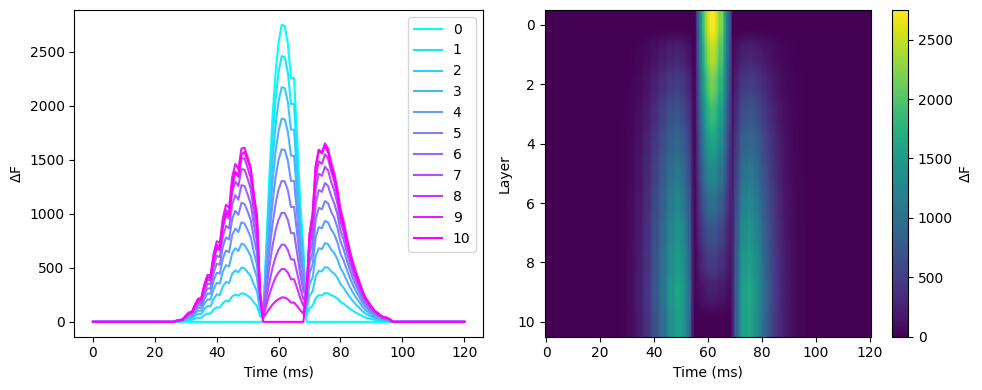

In [12]:
# Compute the relative free energy for each layer model, compared to the worst model at each time step
F_diff = np.zeros((Fs.shape[0],Fs.shape[1]))
for t in range(Fs.shape[1]):
    minF = np.min(Fs[:,t])
    F_diff[:,t] = Fs[:,t]-minF
    
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# Plot relative free energy time series
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(F_diff[l,:], label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

plt.subplot(1,2,2)
h=plt.imshow(F_diff,aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
col_r=plt.colorbar(h)
col_r.set_label(r'$\Delta$F')
plt.tight_layout()

In [13]:
spm.terminate()

# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)